In [74]:
#Data from https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
#Data size is relatively small
#Train with more data for better results.
#Might contain bugs that need to be reviewed.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip install rdkit

In [76]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [77]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [78]:
df = pd.read_parquet("de_train.parquet")

In [79]:
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [80]:
smiles=df['SMILES']

In [81]:
df = df.drop(['sm_name', 'sm_lincs_id','control', 'SMILES'], axis=1)

In [82]:
df.head()

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [143]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        self.categorical_column = 'cell_type'
        self.one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Separate columns
        self.numerical_columns = [col for col in X.columns if col != self.categorical_column]

        # Fit numerical imputer and scaler
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        self.scaler.fit(X_num_imputed)

        # Fit categorical imputer and one-hot encoder
        self.cat_imputer.fit(X[[self.categorical_column]])
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]])
        self.one_hot_encoder.fit(cell_type_imputed)

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Process numerical columns
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Process categorical column
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]])
        cell_type_encoded = self.one_hot_encoder.transform(cell_type_imputed)

        # Combine and return
        X_processed = np.hstack([cell_type_encoded, X_num_scaled])
        return X_processed

In [144]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [145]:
print(X_transformed.shape)

(614, 18217)


In [146]:
#Numerical features
num_num = len(preprocessor.numerical_columns)

In [150]:
cat_dim = preprocessor.one_hot_encoder.transform(
    preprocessor.cat_imputer.transform([['dummy']])
).shape[1]

print("Categorical feature and one-hot encoded column count:")
print(f"  cell_type: {cat_dim} one-hot columns")

print("Total features after transform:", cat_dim + len(preprocessor.numerical_columns))

Categorical feature and one-hot encoded column count:
  cell_type: 6 one-hot columns
Total features after transform: 18217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [152]:
# Number of one-hot encoded columns for 'cell_type'
cat_dims = [len(preprocessor.one_hot_encoder.categories_[0])]  # one-hot columns for 'cell_type'
num_num = len(preprocessor.numerical_columns)                  # numerical gene expression columns

print("Categorical feature and one-hot encoded column count:")
print(f"  cell_type: {cat_dims[0]} one-hot columns")

print("Total numerical features:", num_num)
print("Total features after transform:", cat_dims[0] + num_num)

Categorical feature and one-hot encoded column count:
  cell_type: 6 one-hot columns
Total numerical features: 18211
Total features after transform: 18217


In [153]:
smiles=np.array(smiles)

In [154]:
print(smiles.shape)

(614,)


In [155]:
print(X_transformed.shape)

(614, 18217)


In [156]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_smiles(smiles_list):
    # 1. Extract unique characters from SMILES strings
    charset = sorted(set("".join(smiles_list)))

    # 2. Create mapping from char → index (1-based indexing; 0 = padding)
    char_to_idx = {char: i + 1 for i, char in enumerate(charset)}
    idx_to_char = {i + 1: char for i, char in enumerate(charset)}

    # 3. Tokenize each SMILES into a list of indices
    encoded = [[char_to_idx[char] for char in smile] for smile in smiles_list]

    # 4. Pad sequences to the same length
    max_length = max(len(seq) for seq in encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=0)

    return np.array(padded), char_to_idx, idx_to_char, max_length

# === Tokenize your SMILES strings ===
smiles_encoded, char_to_idx, idx_to_char, max_smiles_length = tokenize_smiles(smiles)

In [169]:
#Wasserstein Autoencoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.models import Model

def build_encoder(input_dim, latent_dim, timesteps=None, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    if timesteps is not None:
        inputs = Input(shape=(timesteps, input_dim))  # Sequence input
        x = layers.Masking(mask_value=0.0)(inputs)
        x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(l2_reg))(x)
    else:
        inputs = Input(shape=(input_dim,))  # Flat input
        x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)

    x = layers.GaussianNoise(noise_stddev)(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inputs, z, name="encoder")

def build_decoder(latent_dim, vocab_size, max_length, embed_dim=64, l2_reg=1e-4):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

    # Project latent vector to an embedding sequence
    x = layers.Dense(max_length * embed_dim, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(latent_inputs)
    x = layers.Reshape((max_length, embed_dim))(x)

    # RNN to generate token sequence
    x = layers.GRU(128, return_sequences=True,
                   kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.TimeDistributed(layers.Dense(vocab_size + 1, activation='softmax'))(x)  # +1 for padding

    return Model(latent_inputs, outputs, name="decoder")

def build_critic(latent_dim, l2_reg=1e-4):
    inputs = Input(shape=(latent_dim,), name='critic_input')
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out = layers.Dense(1)(x)  # Wasserstein scalar score
    return Model(inputs, out, name="critic")

In [172]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# === Assume these are already prepared ===
# X_transformed: shape (N, num_features)
# smiles_encoded: shape (N, max_length), tokenized SMILES strings
# char_to_idx, idx_to_char: tokenizer mappings

# === Params ===
latent_dim = 32
batch_size = 64
epochs = 700
critic_iters = 3
lambda_gp = 10.0
vocab_size = len(char_to_idx)
max_smiles_length = smiles_encoded.shape[1]
input_dim = X_transformed.shape[1]

# === Build models ===
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, vocab_size, max_smiles_length)
critic = build_critic(latent_dim)

# === Optimizers ===
optimizer_gen = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
optimizer_critic = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

# === Dataset ===
dataset = tf.data.Dataset.from_tensor_slices((X_transformed.astype(np.float32), smiles_encoded.astype(np.int32)))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# === Warm-up ===
_ = encoder(X_transformed[:1])
_ = decoder(tf.random.normal([1, latent_dim]))
_ = critic(tf.random.normal([1, latent_dim]))

@tf.function
def train_critic(batch_x):
    critic_loss = 0.0
    for _ in tf.range(critic_iters):
        with tf.GradientTape() as tape:
            z = encoder(batch_x)
            prior_z = tf.random.normal(shape=tf.shape(z), dtype=tf.float32)

            critic_z = critic(z)
            critic_prior = critic(prior_z)

            alpha = tf.random.uniform(shape=[tf.shape(z)[0], 1], dtype=tf.float32)
            interpolates = alpha * z + (1.0 - alpha) * prior_z

            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolates)
                critic_interpolates = critic(interpolates)

            gradients = gp_tape.gradient(critic_interpolates, [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-12)
            gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

            loss = tf.reduce_mean(critic_prior) - tf.reduce_mean(critic_z)
            loss += lambda_gp * gradient_penalty

        grads = tape.gradient(loss, critic.trainable_variables)
        optimizer_critic.apply_gradients(zip(grads, critic.trainable_variables))
        critic_loss += loss
    return critic_loss / tf.cast(critic_iters, tf.float32)

@tf.function
def train_generator(batch_x, batch_smiles):
    with tf.GradientTape() as tape:
        z = encoder(batch_x)
        decoded = decoder(z)  # shape: (batch_size, max_length, vocab_size + 1)
        critic_z = critic(z)

        # Reconstruction loss: categorical crossentropy per token
        recon_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(batch_smiles, decoded)
        )

        gen_loss = recon_loss + tf.reduce_mean(critic_z)

    grads = tape.gradient(gen_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return gen_loss

# === Training Loop ===
num_batches = tf.data.experimental.cardinality(dataset).numpy()

for epoch in range(epochs):
    epoch_gen_loss = []
    epoch_critic_loss = []

    print(f"\n=== Epoch {epoch+1}/{epochs} ===", flush=True)
    for batch_idx, (batch_x, batch_smiles) in enumerate(tqdm(dataset, total=num_batches, desc=f"Epoch {epoch+1}")):
        batch_x = tf.cast(batch_x, tf.float32)
        batch_smiles = tf.cast(batch_smiles, tf.int32)

        critic_loss = train_critic(batch_x)
        gen_loss = train_generator(batch_x, batch_smiles)

        epoch_critic_loss.append(critic_loss.numpy())
        epoch_gen_loss.append(gen_loss.numpy())

        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == num_batches:
            print(f"Batch {batch_idx + 1}/{num_batches}: Gen Loss = {gen_loss.numpy():.4f}, Critic Loss = {critic_loss.numpy():.4f}", flush=True)

    print(f"\n✔ Epoch {epoch+1} Complete | Avg Gen Loss: {np.mean(epoch_gen_loss):.6f}, Avg Critic Loss: {np.mean(epoch_critic_loss):.6f}", flush=True)


=== Epoch 1/700 ===



Epoch 1:  70%|███████   | 7/10 [00:06<00:01,  1.63it/s]

Batch 10/10: Gen Loss = 0.6151, Critic Loss = 4.7750



Epoch 1: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


✔ Epoch 1 Complete | Avg Gen Loss: 2.570806, Avg Critic Loss: 2.635210

=== Epoch 2/700 ===




Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 25.74it/s]

Batch 10/10: Gen Loss = -2.0115, Critic Loss = 7.6631


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 25.42it/s]


✔ Epoch 2 Complete | Avg Gen Loss: -0.987628, Avg Critic Loss: 6.482666

=== Epoch 3/700 ===




Epoch 3:  80%|████████  | 8/10 [00:00<00:00, 30.00it/s]

Batch 10/10: Gen Loss = -2.3130, Critic Loss = 7.5410


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 29.85it/s]


✔ Epoch 3 Complete | Avg Gen Loss: -2.174680, Avg Critic Loss: 7.573239

=== Epoch 4/700 ===




Epoch 4:  80%|████████  | 8/10 [00:00<00:00, 30.24it/s]

Batch 10/10: Gen Loss = -2.6735, Critic Loss = 7.0498


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 4 Complete | Avg Gen Loss: -2.509180, Avg Critic Loss: 7.120753

=== Epoch 5/700 ===




Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 29.26it/s]

Batch 10/10: Gen Loss = -0.5836, Critic Loss = 4.6606


Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 28.35it/s]


✔ Epoch 5 Complete | Avg Gen Loss: -1.490389, Avg Critic Loss: 5.757040

=== Epoch 6/700 ===




Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 29.11it/s]

Batch 10/10: Gen Loss = 1.4747, Critic Loss = 2.7370


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 28.68it/s]


✔ Epoch 6 Complete | Avg Gen Loss: 0.786100, Avg Critic Loss: 3.474880

=== Epoch 7/700 ===




Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 28.71it/s]

Batch 10/10: Gen Loss = 1.9634, Critic Loss = 2.3869


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 7 Complete | Avg Gen Loss: 2.139169, Avg Critic Loss: 2.174225

=== Epoch 8/700 ===




Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 29.02it/s]

Batch 10/10: Gen Loss = 1.9810, Critic Loss = 1.7767


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 8 Complete | Avg Gen Loss: 2.011168, Avg Critic Loss: 2.134044

=== Epoch 9/700 ===




Epoch 9:  70%|███████   | 7/10 [00:00<00:00, 29.89it/s]

Batch 10/10: Gen Loss = -1.4438, Critic Loss = 5.4264



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 9 Complete | Avg Gen Loss: -0.066906, Avg Critic Loss: 4.073183

=== Epoch 10/700 ===




Epoch 10:  90%|█████████ | 9/10 [00:00<00:00, 27.95it/s]

Batch 10/10: Gen Loss = -3.2625, Critic Loss = 7.5113


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 10 Complete | Avg Gen Loss: -2.645981, Avg Critic Loss: 6.972770

=== Epoch 11/700 ===




Epoch 11:  90%|█████████ | 9/10 [00:00<00:00, 29.74it/s]

Batch 10/10: Gen Loss = -2.6007, Critic Loss = 7.5595


Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 11 Complete | Avg Gen Loss: -3.040061, Avg Critic Loss: 7.541520

=== Epoch 12/700 ===




Epoch 12:  60%|██████    | 6/10 [00:00<00:00, 27.01it/s]

Batch 10/10: Gen Loss = -1.2907, Critic Loss = 6.0475



Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 27.40it/s]


✔ Epoch 12 Complete | Avg Gen Loss: -2.001324, Avg Critic Loss: 6.790443

=== Epoch 13/700 ===




Epoch 13:  70%|███████   | 7/10 [00:00<00:00, 30.08it/s]

Batch 10/10: Gen Loss = -0.6254, Critic Loss = 5.9330


Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 13 Complete | Avg Gen Loss: -0.924718, Avg Critic Loss: 5.856974

=== Epoch 14/700 ===




Epoch 14:  90%|█████████ | 9/10 [00:00<00:00, 28.99it/s]

Batch 10/10: Gen Loss = -0.9102, Critic Loss = 5.7082


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 14 Complete | Avg Gen Loss: -0.697968, Avg Critic Loss: 5.883964

=== Epoch 15/700 ===




Epoch 15:  90%|█████████ | 9/10 [00:00<00:00, 29.61it/s]

Batch 10/10: Gen Loss = -2.0332, Critic Loss = 6.3411


Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 15 Complete | Avg Gen Loss: -1.716233, Avg Critic Loss: 6.206873

=== Epoch 16/700 ===




Epoch 16:  90%|█████████ | 9/10 [00:00<00:00, 29.36it/s]

Batch 10/10: Gen Loss = -2.5637, Critic Loss = 7.3282


Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 16 Complete | Avg Gen Loss: -2.486114, Avg Critic Loss: 6.879049

=== Epoch 17/700 ===




Epoch 17:  90%|█████████ | 9/10 [00:00<00:00, 28.02it/s]

Batch 10/10: Gen Loss = -2.0428, Critic Loss = 6.1316


Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 17 Complete | Avg Gen Loss: -2.379718, Avg Critic Loss: 6.670662

=== Epoch 18/700 ===




Epoch 18:  80%|████████  | 8/10 [00:00<00:00, 22.38it/s]

Batch 10/10: Gen Loss = -1.4485, Critic Loss = 5.3132


Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 18 Complete | Avg Gen Loss: -1.763642, Avg Critic Loss: 5.667408

=== Epoch 19/700 ===




Epoch 19:  80%|████████  | 8/10 [00:00<00:00, 22.01it/s]

Batch 10/10: Gen Loss = -1.0440, Critic Loss = 4.7547


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


✔ Epoch 19 Complete | Avg Gen Loss: -1.186261, Avg Critic Loss: 4.942352

=== Epoch 20/700 ===




Epoch 20:  90%|█████████ | 9/10 [00:00<00:00, 21.47it/s]

Batch 10/10: Gen Loss = -2.4987, Critic Loss = 5.9820


Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 20 Complete | Avg Gen Loss: -1.484923, Avg Critic Loss: 5.089509

=== Epoch 21/700 ===




Epoch 21:  80%|████████  | 8/10 [00:00<00:00, 21.67it/s]

Batch 10/10: Gen Loss = -3.4866, Critic Loss = 6.6028


Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 21.22it/s]


✔ Epoch 21 Complete | Avg Gen Loss: -3.304024, Avg Critic Loss: 6.658263

=== Epoch 22/700 ===




Epoch 22:  80%|████████  | 8/10 [00:00<00:00, 24.55it/s]

Batch 10/10: Gen Loss = -3.2218, Critic Loss = 6.3095


Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 22 Complete | Avg Gen Loss: -3.851129, Avg Critic Loss: 6.901216

=== Epoch 23/700 ===




Epoch 23:  90%|█████████ | 9/10 [00:00<00:00, 29.32it/s]

Batch 10/10: Gen Loss = -1.6324, Critic Loss = 4.6749


Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 28.76it/s]


✔ Epoch 23 Complete | Avg Gen Loss: -2.600636, Avg Critic Loss: 5.701020

=== Epoch 24/700 ===




Epoch 24:  90%|█████████ | 9/10 [00:00<00:00, 28.29it/s]

Batch 10/10: Gen Loss = 0.3819, Critic Loss = 2.7905


Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 24 Complete | Avg Gen Loss: -0.805099, Avg Critic Loss: 4.010121

=== Epoch 25/700 ===




Epoch 25:  90%|█████████ | 9/10 [00:00<00:00, 28.98it/s]

Batch 10/10: Gen Loss = 1.4651, Critic Loss = 2.1035


Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 25 Complete | Avg Gen Loss: 0.754323, Avg Critic Loss: 2.627896

=== Epoch 26/700 ===




Epoch 26:  90%|█████████ | 9/10 [00:00<00:00, 28.19it/s]

Batch 10/10: Gen Loss = 3.2964, Critic Loss = 0.6819


Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 26 Complete | Avg Gen Loss: 2.369894, Avg Critic Loss: 1.276592

=== Epoch 27/700 ===




Epoch 27:  90%|█████████ | 9/10 [00:00<00:00, 29.14it/s]

Batch 10/10: Gen Loss = 4.1117, Critic Loss = 0.3014


Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 28.66it/s]


✔ Epoch 27 Complete | Avg Gen Loss: 4.009860, Avg Critic Loss: 0.187384

=== Epoch 28/700 ===




Epoch 28:  90%|█████████ | 9/10 [00:00<00:00, 27.05it/s]

Batch 10/10: Gen Loss = 3.6287, Critic Loss = 1.3538


Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 27.22it/s]


✔ Epoch 28 Complete | Avg Gen Loss: 3.926401, Avg Critic Loss: 0.584982

=== Epoch 29/700 ===




Epoch 29:  90%|█████████ | 9/10 [00:00<00:00, 29.15it/s]

Batch 10/10: Gen Loss = 4.4217, Critic Loss = 0.4635


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 29 Complete | Avg Gen Loss: 4.056828, Avg Critic Loss: 0.794261

=== Epoch 30/700 ===




Epoch 30:  90%|█████████ | 9/10 [00:00<00:00, 27.58it/s]

Batch 10/10: Gen Loss = 4.9468, Critic Loss = 0.0066


Epoch 30: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 30 Complete | Avg Gen Loss: 4.740230, Avg Critic Loss: 0.039568

=== Epoch 31/700 ===




Epoch 31:  90%|█████████ | 9/10 [00:00<00:00, 29.26it/s]

Batch 10/10: Gen Loss = 5.4969, Critic Loss = -0.8669


Epoch 31: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 31 Complete | Avg Gen Loss: 5.297441, Avg Critic Loss: -0.594574

=== Epoch 32/700 ===




Epoch 32:  90%|█████████ | 9/10 [00:00<00:00, 29.37it/s]

Batch 10/10: Gen Loss = 4.9616, Critic Loss = -0.8068


Epoch 32: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 32 Complete | Avg Gen Loss: 5.468396, Avg Critic Loss: -1.193690

=== Epoch 33/700 ===




Epoch 33:  90%|█████████ | 9/10 [00:00<00:00, 28.64it/s]

Batch 10/10: Gen Loss = 2.9957, Critic Loss = 0.7101


Epoch 33: 100%|██████████| 10/10 [00:00<00:00, 27.69it/s]


✔ Epoch 33 Complete | Avg Gen Loss: 4.015126, Avg Critic Loss: -0.074767

=== Epoch 34/700 ===




Epoch 34:  90%|█████████ | 9/10 [00:00<00:00, 29.36it/s]

Batch 10/10: Gen Loss = 2.2092, Critic Loss = 2.2549


Epoch 34: 100%|██████████| 10/10 [00:00<00:00, 29.10it/s]


✔ Epoch 34 Complete | Avg Gen Loss: 2.421845, Avg Critic Loss: 1.686145

=== Epoch 35/700 ===




Epoch 35:  90%|█████████ | 9/10 [00:00<00:00, 28.70it/s]

Batch 10/10: Gen Loss = 1.8915, Critic Loss = 2.1406


Epoch 35: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 35 Complete | Avg Gen Loss: 2.186432, Avg Critic Loss: 1.853849

=== Epoch 36/700 ===




Epoch 36:  90%|█████████ | 9/10 [00:00<00:00, 28.45it/s]

Batch 10/10: Gen Loss = 0.2867, Critic Loss = 4.1516


Epoch 36: 100%|██████████| 10/10 [00:00<00:00, 27.54it/s]


✔ Epoch 36 Complete | Avg Gen Loss: 0.999493, Avg Critic Loss: 3.135278

=== Epoch 37/700 ===




Epoch 37:  90%|█████████ | 9/10 [00:00<00:00, 29.27it/s]

Batch 10/10: Gen Loss = 0.5057, Critic Loss = 3.8624


Epoch 37: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 37 Complete | Avg Gen Loss: 0.270572, Avg Critic Loss: 4.000271

=== Epoch 38/700 ===




Epoch 38:  90%|█████████ | 9/10 [00:00<00:00, 28.30it/s]

Batch 10/10: Gen Loss = 1.6157, Critic Loss = 2.9255


Epoch 38: 100%|██████████| 10/10 [00:00<00:00, 27.61it/s]


✔ Epoch 38 Complete | Avg Gen Loss: 1.114290, Avg Critic Loss: 3.211236

=== Epoch 39/700 ===




Epoch 39:  90%|█████████ | 9/10 [00:00<00:00, 28.43it/s]

Batch 10/10: Gen Loss = 2.9089, Critic Loss = 1.5917


Epoch 39: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 39 Complete | Avg Gen Loss: 2.443278, Avg Critic Loss: 1.985583

=== Epoch 40/700 ===




Epoch 40:  90%|█████████ | 9/10 [00:00<00:00, 28.24it/s]

Batch 10/10: Gen Loss = 3.2013, Critic Loss = 1.5417


Epoch 40: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 40 Complete | Avg Gen Loss: 3.079155, Avg Critic Loss: 1.480564

=== Epoch 41/700 ===




Epoch 41:  90%|█████████ | 9/10 [00:00<00:00, 22.73it/s]

Batch 10/10: Gen Loss = 3.4027, Critic Loss = 0.9592


Epoch 41: 100%|██████████| 10/10 [00:00<00:00, 22.64it/s]


✔ Epoch 41 Complete | Avg Gen Loss: 3.352778, Avg Critic Loss: 1.040072

=== Epoch 42/700 ===




Epoch 42:  80%|████████  | 8/10 [00:00<00:00, 22.02it/s]

Batch 10/10: Gen Loss = 2.7985, Critic Loss = 1.6238


Epoch 42: 100%|██████████| 10/10 [00:00<00:00, 21.69it/s]


✔ Epoch 42 Complete | Avg Gen Loss: 3.205191, Avg Critic Loss: 1.246673

=== Epoch 43/700 ===




Epoch 43:  90%|█████████ | 9/10 [00:00<00:00, 21.87it/s]

Batch 10/10: Gen Loss = 2.6410, Critic Loss = 2.0288


Epoch 43: 100%|██████████| 10/10 [00:00<00:00, 21.65it/s]


✔ Epoch 43 Complete | Avg Gen Loss: 2.720659, Avg Critic Loss: 1.894892

=== Epoch 44/700 ===




Epoch 44:  90%|█████████ | 9/10 [00:00<00:00, 21.18it/s]

Batch 10/10: Gen Loss = 3.4255, Critic Loss = 1.3121


Epoch 44: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 44 Complete | Avg Gen Loss: 3.378995, Avg Critic Loss: 1.209295

=== Epoch 45/700 ===




Epoch 45:  90%|█████████ | 9/10 [00:00<00:00, 22.84it/s]

Batch 10/10: Gen Loss = 3.7969, Critic Loss = 0.9350


Epoch 45: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 45 Complete | Avg Gen Loss: 3.839085, Avg Critic Loss: 0.810754

=== Epoch 46/700 ===




Epoch 46:  80%|████████  | 8/10 [00:00<00:00, 21.09it/s]

Batch 10/10: Gen Loss = 3.7784, Critic Loss = 0.9832


Epoch 46: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s]


✔ Epoch 46 Complete | Avg Gen Loss: 3.980597, Avg Critic Loss: 0.691130

=== Epoch 47/700 ===




Epoch 47:  90%|█████████ | 9/10 [00:00<00:00, 28.42it/s]

Batch 10/10: Gen Loss = 3.4152, Critic Loss = 0.9182


Epoch 47: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 47 Complete | Avg Gen Loss: 3.847676, Avg Critic Loss: 0.705484

=== Epoch 48/700 ===




Epoch 48:  90%|█████████ | 9/10 [00:00<00:00, 28.73it/s]

Batch 10/10: Gen Loss = 3.2496, Critic Loss = 1.0940


Epoch 48: 100%|██████████| 10/10 [00:00<00:00, 27.84it/s]


✔ Epoch 48 Complete | Avg Gen Loss: 3.525892, Avg Critic Loss: 0.874921

=== Epoch 49/700 ===




Epoch 49:  90%|█████████ | 9/10 [00:00<00:00, 28.88it/s]

Batch 10/10: Gen Loss = 3.2857, Critic Loss = 1.0384


Epoch 49: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 49 Complete | Avg Gen Loss: 3.567505, Avg Critic Loss: 0.722844

=== Epoch 50/700 ===




Epoch 50:  90%|█████████ | 9/10 [00:00<00:00, 28.60it/s]

Batch 10/10: Gen Loss = 3.2041, Critic Loss = 0.8358


Epoch 50: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 50 Complete | Avg Gen Loss: 3.410797, Avg Critic Loss: 0.774772

=== Epoch 51/700 ===




Epoch 51:  90%|█████████ | 9/10 [00:00<00:00, 28.64it/s]

Batch 10/10: Gen Loss = 2.4410, Critic Loss = 1.7521


Epoch 51: 100%|██████████| 10/10 [00:00<00:00, 27.64it/s]


✔ Epoch 51 Complete | Avg Gen Loss: 3.087021, Avg Critic Loss: 1.014564

=== Epoch 52/700 ===




Epoch 52:  90%|█████████ | 9/10 [00:00<00:00, 28.24it/s]

Batch 10/10: Gen Loss = 1.6765, Critic Loss = 2.8705


Epoch 52: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 52 Complete | Avg Gen Loss: 2.113084, Avg Critic Loss: 2.250700

=== Epoch 53/700 ===




Epoch 53:  90%|█████████ | 9/10 [00:00<00:00, 28.54it/s]

Batch 10/10: Gen Loss = 1.9097, Critic Loss = 2.3392


Epoch 53: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 53 Complete | Avg Gen Loss: 2.035807, Avg Critic Loss: 2.341460

=== Epoch 54/700 ===




Epoch 54:  90%|█████████ | 9/10 [00:00<00:00, 28.66it/s]

Batch 10/10: Gen Loss = 2.1121, Critic Loss = 2.0457


Epoch 54: 100%|██████████| 10/10 [00:00<00:00, 27.89it/s]


✔ Epoch 54 Complete | Avg Gen Loss: 2.111616, Avg Critic Loss: 2.247555

=== Epoch 55/700 ===




Epoch 55:  90%|█████████ | 9/10 [00:00<00:00, 27.60it/s]

Batch 10/10: Gen Loss = 2.2595, Critic Loss = 2.2259


Epoch 55: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 55 Complete | Avg Gen Loss: 2.355761, Avg Critic Loss: 1.953858

=== Epoch 56/700 ===




Epoch 56:  90%|█████████ | 9/10 [00:00<00:00, 29.00it/s]

Batch 10/10: Gen Loss = 2.1144, Critic Loss = 2.1183


Epoch 56: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 56 Complete | Avg Gen Loss: 2.454179, Avg Critic Loss: 1.825131

=== Epoch 57/700 ===




Epoch 57:  90%|█████████ | 9/10 [00:00<00:00, 27.56it/s]

Batch 10/10: Gen Loss = 0.9294, Critic Loss = 3.1080


Epoch 57: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 57 Complete | Avg Gen Loss: 1.326163, Avg Critic Loss: 2.748171

=== Epoch 58/700 ===




Epoch 58:  90%|█████████ | 9/10 [00:00<00:00, 28.67it/s]

Batch 10/10: Gen Loss = 1.0803, Critic Loss = 3.1587


Epoch 58: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 58 Complete | Avg Gen Loss: 0.917280, Avg Critic Loss: 3.164196

=== Epoch 59/700 ===




Epoch 59:  90%|█████████ | 9/10 [00:00<00:00, 26.88it/s]

Batch 10/10: Gen Loss = 1.0320, Critic Loss = 2.8844


Epoch 59: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 59 Complete | Avg Gen Loss: 1.106780, Avg Critic Loss: 2.903146

=== Epoch 60/700 ===




Epoch 60:  90%|█████████ | 9/10 [00:00<00:00, 27.96it/s]

Batch 10/10: Gen Loss = 1.6229, Critic Loss = 2.1712


Epoch 60: 100%|██████████| 10/10 [00:00<00:00, 26.54it/s]


✔ Epoch 60 Complete | Avg Gen Loss: 1.325625, Avg Critic Loss: 2.621222

=== Epoch 61/700 ===




Epoch 61:  90%|█████████ | 9/10 [00:00<00:00, 28.55it/s]

Batch 10/10: Gen Loss = 2.0248, Critic Loss = 1.9401


Epoch 61: 100%|██████████| 10/10 [00:00<00:00, 28.26it/s]


✔ Epoch 61 Complete | Avg Gen Loss: 1.891252, Avg Critic Loss: 2.121225

=== Epoch 62/700 ===




Epoch 62:  90%|█████████ | 9/10 [00:00<00:00, 28.40it/s]

Batch 10/10: Gen Loss = 2.0033, Critic Loss = 1.7997


Epoch 62: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 62 Complete | Avg Gen Loss: 2.183686, Avg Critic Loss: 1.699466

=== Epoch 63/700 ===




Epoch 63:  90%|█████████ | 9/10 [00:00<00:00, 27.28it/s]

Batch 10/10: Gen Loss = 2.2195, Critic Loss = 1.6781


Epoch 63: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 63 Complete | Avg Gen Loss: 2.182839, Avg Critic Loss: 1.678413

=== Epoch 64/700 ===




Epoch 64:  90%|█████████ | 9/10 [00:00<00:00, 28.75it/s]

Batch 10/10: Gen Loss = 2.4787, Critic Loss = 1.4436


Epoch 64: 100%|██████████| 10/10 [00:00<00:00, 28.10it/s]


✔ Epoch 64 Complete | Avg Gen Loss: 2.521140, Avg Critic Loss: 1.339405

=== Epoch 65/700 ===




Epoch 65:  90%|█████████ | 9/10 [00:00<00:00, 23.88it/s]

Batch 10/10: Gen Loss = 2.6449, Critic Loss = 0.6786


Epoch 65: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 65 Complete | Avg Gen Loss: 2.657274, Avg Critic Loss: 0.989630

=== Epoch 66/700 ===




Epoch 66:  80%|████████  | 8/10 [00:00<00:00, 22.70it/s]

Batch 10/10: Gen Loss = 2.6812, Critic Loss = 0.8530


Epoch 66: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s]


✔ Epoch 66 Complete | Avg Gen Loss: 2.634623, Avg Critic Loss: 1.109523

=== Epoch 67/700 ===




Epoch 67:  70%|███████   | 7/10 [00:00<00:00, 19.00it/s]

Batch 10/10: Gen Loss = 2.3757, Critic Loss = 1.2126



Epoch 67: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 67 Complete | Avg Gen Loss: 2.488593, Avg Critic Loss: 1.157208

=== Epoch 68/700 ===




Epoch 68:  80%|████████  | 8/10 [00:00<00:00, 20.68it/s]

Batch 10/10: Gen Loss = 2.0844, Critic Loss = 1.3292


Epoch 68: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 68 Complete | Avg Gen Loss: 2.285481, Avg Critic Loss: 1.286442

=== Epoch 69/700 ===




Epoch 69:  80%|████████  | 8/10 [00:00<00:00, 21.65it/s]

Batch 10/10: Gen Loss = 1.3492, Critic Loss = 2.0325


Epoch 69: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 69 Complete | Avg Gen Loss: 1.704280, Avg Critic Loss: 1.705076

=== Epoch 70/700 ===




Epoch 70:  80%|████████  | 8/10 [00:00<00:00, 24.75it/s]

Batch 10/10: Gen Loss = 1.3424, Critic Loss = 2.1506


Epoch 70: 100%|██████████| 10/10 [00:00<00:00, 24.51it/s]


✔ Epoch 70 Complete | Avg Gen Loss: 1.176570, Avg Critic Loss: 2.325918

=== Epoch 71/700 ===




Epoch 71:  90%|█████████ | 9/10 [00:00<00:00, 28.90it/s]

Batch 10/10: Gen Loss = 2.0061, Critic Loss = 1.3866


Epoch 71: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 71 Complete | Avg Gen Loss: 1.615913, Avg Critic Loss: 1.876818

=== Epoch 72/700 ===




Epoch 72:  90%|█████████ | 9/10 [00:00<00:00, 26.83it/s]

Batch 10/10: Gen Loss = 2.4091, Critic Loss = 0.7835


Epoch 72: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 72 Complete | Avg Gen Loss: 2.097344, Avg Critic Loss: 1.255201

=== Epoch 73/700 ===




Epoch 73:  90%|█████████ | 9/10 [00:00<00:00, 28.45it/s]

Batch 10/10: Gen Loss = 2.3784, Critic Loss = 0.7080


Epoch 73: 100%|██████████| 10/10 [00:00<00:00, 27.86it/s]


✔ Epoch 73 Complete | Avg Gen Loss: 2.271963, Avg Critic Loss: 0.976963

=== Epoch 74/700 ===




Epoch 74:  90%|█████████ | 9/10 [00:00<00:00, 27.51it/s]

Batch 10/10: Gen Loss = 0.1798, Critic Loss = 3.0116


Epoch 74: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 74 Complete | Avg Gen Loss: 0.689400, Avg Critic Loss: 2.498400

=== Epoch 75/700 ===




Epoch 75:  90%|█████████ | 9/10 [00:00<00:00, 28.52it/s]

Batch 10/10: Gen Loss = 0.0623, Critic Loss = 3.2556


Epoch 75: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 75 Complete | Avg Gen Loss: -0.211077, Avg Critic Loss: 3.480155

=== Epoch 76/700 ===




Epoch 76:  90%|█████████ | 9/10 [00:00<00:00, 28.02it/s]

Batch 10/10: Gen Loss = 0.9327, Critic Loss = 2.2641


Epoch 76: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 76 Complete | Avg Gen Loss: 0.273031, Avg Critic Loss: 3.064202

=== Epoch 77/700 ===




Epoch 77:  90%|█████████ | 9/10 [00:00<00:00, 28.62it/s]

Batch 10/10: Gen Loss = 1.1052, Critic Loss = 2.1910


Epoch 77: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 77 Complete | Avg Gen Loss: 0.831527, Avg Critic Loss: 2.508830

=== Epoch 78/700 ===




Epoch 78:  90%|█████████ | 9/10 [00:00<00:00, 28.57it/s]

Batch 10/10: Gen Loss = 2.0147, Critic Loss = 1.3021


Epoch 78: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 78 Complete | Avg Gen Loss: 1.597448, Avg Critic Loss: 1.816017

=== Epoch 79/700 ===




Epoch 79:  90%|█████████ | 9/10 [00:00<00:00, 28.29it/s]

Batch 10/10: Gen Loss = 2.4530, Critic Loss = 1.0341


Epoch 79: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 79 Complete | Avg Gen Loss: 2.281300, Avg Critic Loss: 1.287371

=== Epoch 80/700 ===




Epoch 80:  90%|█████████ | 9/10 [00:00<00:00, 28.50it/s]

Batch 10/10: Gen Loss = 2.4775, Critic Loss = 1.1416


Epoch 80: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 80 Complete | Avg Gen Loss: 2.547775, Avg Critic Loss: 1.124455

=== Epoch 81/700 ===




Epoch 81:  90%|█████████ | 9/10 [00:00<00:00, 28.38it/s]

Batch 10/10: Gen Loss = 2.3688, Critic Loss = 1.2429


Epoch 81: 100%|██████████| 10/10 [00:00<00:00, 27.81it/s]


✔ Epoch 81 Complete | Avg Gen Loss: 2.522690, Avg Critic Loss: 1.105732

=== Epoch 82/700 ===




Epoch 82:  90%|█████████ | 9/10 [00:00<00:00, 28.11it/s]

Batch 10/10: Gen Loss = 1.9089, Critic Loss = 1.7752


Epoch 82: 100%|██████████| 10/10 [00:00<00:00, 27.81it/s]


✔ Epoch 82 Complete | Avg Gen Loss: 2.325798, Avg Critic Loss: 1.302405

=== Epoch 83/700 ===




Epoch 83:  90%|█████████ | 9/10 [00:00<00:00, 27.30it/s]

Batch 10/10: Gen Loss = 1.4648, Critic Loss = 2.2926


Epoch 83: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 83 Complete | Avg Gen Loss: 1.830289, Avg Critic Loss: 1.906541

=== Epoch 84/700 ===




Epoch 84:  90%|█████████ | 9/10 [00:00<00:00, 28.46it/s]

Batch 10/10: Gen Loss = 1.2515, Critic Loss = 2.2631


Epoch 84: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 84 Complete | Avg Gen Loss: 1.614640, Avg Critic Loss: 2.181332

=== Epoch 85/700 ===




Epoch 85:  90%|█████████ | 9/10 [00:00<00:00, 27.45it/s]

Batch 10/10: Gen Loss = 1.1009, Critic Loss = 2.3485


Epoch 85: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 85 Complete | Avg Gen Loss: 1.417848, Avg Critic Loss: 2.115907

=== Epoch 86/700 ===




Epoch 86:  90%|█████████ | 9/10 [00:00<00:00, 28.32it/s]

Batch 10/10: Gen Loss = 1.2692, Critic Loss = 2.0544


Epoch 86: 100%|██████████| 10/10 [00:00<00:00, 27.95it/s]


✔ Epoch 86 Complete | Avg Gen Loss: 1.492838, Avg Critic Loss: 1.885102

=== Epoch 87/700 ===




Epoch 87:  90%|█████████ | 9/10 [00:00<00:00, 27.56it/s]

Batch 10/10: Gen Loss = 1.9545, Critic Loss = 1.3506


Epoch 87: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 87 Complete | Avg Gen Loss: 2.001908, Avg Critic Loss: 1.238463

=== Epoch 88/700 ===




Epoch 88:  90%|█████████ | 9/10 [00:00<00:00, 21.27it/s]

Batch 10/10: Gen Loss = 1.7982, Critic Loss = 1.2529


Epoch 88: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s]


✔ Epoch 88 Complete | Avg Gen Loss: 2.192539, Avg Critic Loss: 1.000190

=== Epoch 89/700 ===




Epoch 89:  80%|████████  | 8/10 [00:00<00:00, 20.65it/s]

Batch 10/10: Gen Loss = 1.8393, Critic Loss = 1.2407


Epoch 89: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 89 Complete | Avg Gen Loss: 2.115852, Avg Critic Loss: 1.032921

=== Epoch 90/700 ===




Epoch 90:  80%|████████  | 8/10 [00:00<00:00, 20.60it/s]

Batch 10/10: Gen Loss = 1.0501, Critic Loss = 2.0092


Epoch 90: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s]


✔ Epoch 90 Complete | Avg Gen Loss: 1.677613, Avg Critic Loss: 1.471123

=== Epoch 91/700 ===




Epoch 91:  80%|████████  | 8/10 [00:00<00:00, 21.84it/s]

Batch 10/10: Gen Loss = 0.2695, Critic Loss = 2.9920


Epoch 91: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 91 Complete | Avg Gen Loss: 0.789386, Avg Critic Loss: 2.380431

=== Epoch 92/700 ===




Epoch 92:  80%|████████  | 8/10 [00:00<00:00, 20.19it/s]

Batch 10/10: Gen Loss = -0.1513, Critic Loss = 3.4075


Epoch 92: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s]


✔ Epoch 92 Complete | Avg Gen Loss: 0.148643, Avg Critic Loss: 3.126098

=== Epoch 93/700 ===




Epoch 93:  80%|████████  | 8/10 [00:00<00:00, 19.32it/s]

Batch 10/10: Gen Loss = 0.4010, Critic Loss = 2.8539


Epoch 93: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 93 Complete | Avg Gen Loss: 0.262863, Avg Critic Loss: 3.090842

=== Epoch 94/700 ===




Epoch 94:  90%|█████████ | 9/10 [00:00<00:00, 27.45it/s]

Batch 10/10: Gen Loss = 1.0478, Critic Loss = 2.3125


Epoch 94: 100%|██████████| 10/10 [00:00<00:00, 27.22it/s]


✔ Epoch 94 Complete | Avg Gen Loss: 0.932944, Avg Critic Loss: 2.450087

=== Epoch 95/700 ===




Epoch 95:  90%|█████████ | 9/10 [00:00<00:00, 27.97it/s]

Batch 10/10: Gen Loss = 1.0076, Critic Loss = 2.5027


Epoch 95: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 95 Complete | Avg Gen Loss: 1.050130, Avg Critic Loss: 2.421290

=== Epoch 96/700 ===




Epoch 96:  90%|█████████ | 9/10 [00:00<00:00, 28.13it/s]

Batch 10/10: Gen Loss = 1.2856, Critic Loss = 2.2272


Epoch 96: 100%|██████████| 10/10 [00:00<00:00, 27.09it/s]


✔ Epoch 96 Complete | Avg Gen Loss: 1.264303, Avg Critic Loss: 2.302837

=== Epoch 97/700 ===




Epoch 97:  90%|█████████ | 9/10 [00:00<00:00, 27.88it/s]

Batch 10/10: Gen Loss = 1.5648, Critic Loss = 1.8425


Epoch 97: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 97 Complete | Avg Gen Loss: 1.456415, Avg Critic Loss: 1.979817

=== Epoch 98/700 ===




Epoch 98:  90%|█████████ | 9/10 [00:00<00:00, 28.57it/s]

Batch 10/10: Gen Loss = 0.6084, Critic Loss = 2.8319


Epoch 98: 100%|██████████| 10/10 [00:00<00:00, 27.10it/s]


✔ Epoch 98 Complete | Avg Gen Loss: 0.932217, Avg Critic Loss: 2.436784

=== Epoch 99/700 ===




Epoch 99:  90%|█████████ | 9/10 [00:00<00:00, 27.84it/s]

Batch 10/10: Gen Loss = 0.4708, Critic Loss = 3.2073


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 99 Complete | Avg Gen Loss: 0.443233, Avg Critic Loss: 3.064146

=== Epoch 100/700 ===




Epoch 100:  90%|█████████ | 9/10 [00:00<00:00, 28.11it/s]

Batch 10/10: Gen Loss = 0.8440, Critic Loss = 2.9083


Epoch 100: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 100 Complete | Avg Gen Loss: 0.764824, Avg Critic Loss: 2.964372

=== Epoch 101/700 ===




Epoch 101:  90%|█████████ | 9/10 [00:00<00:00, 27.99it/s]

Batch 10/10: Gen Loss = 0.8084, Critic Loss = 3.0038


Epoch 101: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 101 Complete | Avg Gen Loss: 0.758461, Avg Critic Loss: 3.040995

=== Epoch 102/700 ===




Epoch 102:  90%|█████████ | 9/10 [00:00<00:00, 27.40it/s]

Batch 10/10: Gen Loss = 1.7697, Critic Loss = 2.4613


Epoch 102: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 102 Complete | Avg Gen Loss: 1.460993, Avg Critic Loss: 2.599992

=== Epoch 103/700 ===




Epoch 103:  90%|█████████ | 9/10 [00:00<00:00, 27.90it/s]

Batch 10/10: Gen Loss = 2.1594, Critic Loss = 1.5686


Epoch 103: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 103 Complete | Avg Gen Loss: 2.242089, Avg Critic Loss: 1.713468

=== Epoch 104/700 ===




Epoch 104:  90%|█████████ | 9/10 [00:00<00:00, 28.20it/s]

Batch 10/10: Gen Loss = 1.8020, Critic Loss = 1.8377


Epoch 104: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 104 Complete | Avg Gen Loss: 2.012167, Avg Critic Loss: 1.910140

=== Epoch 105/700 ===




Epoch 105:  90%|█████████ | 9/10 [00:00<00:00, 27.80it/s]

Batch 10/10: Gen Loss = 1.8191, Critic Loss = 2.1932


Epoch 105: 100%|██████████| 10/10 [00:00<00:00, 27.19it/s]


✔ Epoch 105 Complete | Avg Gen Loss: 2.019874, Avg Critic Loss: 1.942540

=== Epoch 106/700 ===




Epoch 106:  90%|█████████ | 9/10 [00:00<00:00, 28.56it/s]

Batch 10/10: Gen Loss = 2.1483, Critic Loss = 1.7595


Epoch 106: 100%|██████████| 10/10 [00:00<00:00, 28.04it/s]


✔ Epoch 106 Complete | Avg Gen Loss: 2.172901, Avg Critic Loss: 1.704968

=== Epoch 107/700 ===




Epoch 107:  90%|█████████ | 9/10 [00:00<00:00, 27.94it/s]

Batch 10/10: Gen Loss = 2.5361, Critic Loss = 1.2040


Epoch 107: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 107 Complete | Avg Gen Loss: 2.507105, Avg Critic Loss: 1.302898

=== Epoch 108/700 ===




Epoch 108:  90%|█████████ | 9/10 [00:00<00:00, 27.41it/s]

Batch 10/10: Gen Loss = 2.9416, Critic Loss = 0.7839


Epoch 108: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 108 Complete | Avg Gen Loss: 2.901679, Avg Critic Loss: 0.814042

=== Epoch 109/700 ===




Epoch 109:  90%|█████████ | 9/10 [00:00<00:00, 27.21it/s]

Batch 10/10: Gen Loss = 3.0110, Critic Loss = 0.7776


Epoch 109: 100%|██████████| 10/10 [00:00<00:00, 26.75it/s]


✔ Epoch 109 Complete | Avg Gen Loss: 3.105934, Avg Critic Loss: 0.664661

=== Epoch 110/700 ===




Epoch 110:  90%|█████████ | 9/10 [00:00<00:00, 27.00it/s]

Batch 10/10: Gen Loss = 2.9197, Critic Loss = 0.6020


Epoch 110: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 110 Complete | Avg Gen Loss: 3.210072, Avg Critic Loss: 0.465973

=== Epoch 111/700 ===




Epoch 111:  90%|█████████ | 9/10 [00:00<00:00, 27.68it/s]

Batch 10/10: Gen Loss = 2.5423, Critic Loss = 0.7417


Epoch 111: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 111 Complete | Avg Gen Loss: 2.827743, Avg Critic Loss: 0.631245

=== Epoch 112/700 ===




Epoch 112:  80%|████████  | 8/10 [00:00<00:00, 10.89it/s]

Batch 10/10: Gen Loss = 1.8930, Critic Loss = 1.5326



Epoch 112: 100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


✔ Epoch 112 Complete | Avg Gen Loss: 2.266448, Avg Critic Loss: 1.241054

=== Epoch 113/700 ===




Epoch 113:  90%|█████████ | 9/10 [00:00<00:00, 14.35it/s]

Batch 10/10: Gen Loss = 1.8156, Critic Loss = 1.5668


Epoch 113: 100%|██████████| 10/10 [00:00<00:00, 10.90it/s]


✔ Epoch 113 Complete | Avg Gen Loss: 1.920531, Avg Critic Loss: 1.545525

=== Epoch 114/700 ===




Epoch 114:  70%|███████   | 7/10 [00:00<00:00, 19.76it/s]

Batch 10/10: Gen Loss = 1.8308, Critic Loss = 1.1810



Epoch 114: 100%|██████████| 10/10 [00:00<00:00, 19.94it/s]


✔ Epoch 114 Complete | Avg Gen Loss: 1.888090, Avg Critic Loss: 1.440876

=== Epoch 115/700 ===




Epoch 115:  80%|████████  | 8/10 [00:00<00:00, 21.62it/s]

Batch 10/10: Gen Loss = 0.8853, Critic Loss = 2.4073


Epoch 115: 100%|██████████| 10/10 [00:00<00:00, 20.96it/s]


✔ Epoch 115 Complete | Avg Gen Loss: 1.528677, Avg Critic Loss: 1.793495

=== Epoch 116/700 ===




Epoch 116:  70%|███████   | 7/10 [00:00<00:00, 19.86it/s]

Batch 10/10: Gen Loss = 0.4867, Critic Loss = 3.0322



Epoch 116: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 116 Complete | Avg Gen Loss: 0.437116, Avg Critic Loss: 3.060747

=== Epoch 117/700 ===




Epoch 117:  90%|█████████ | 9/10 [00:00<00:00, 26.91it/s]

Batch 10/10: Gen Loss = 1.6250, Critic Loss = 1.9144


Epoch 117: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 117 Complete | Avg Gen Loss: 0.973145, Avg Critic Loss: 2.549301

=== Epoch 118/700 ===




Epoch 118:  90%|█████████ | 9/10 [00:00<00:00, 27.94it/s]

Batch 10/10: Gen Loss = 1.0305, Critic Loss = 2.3783


Epoch 118: 100%|██████████| 10/10 [00:00<00:00, 27.24it/s]


✔ Epoch 118 Complete | Avg Gen Loss: 1.211989, Avg Critic Loss: 2.249993

=== Epoch 119/700 ===




Epoch 119:  90%|█████████ | 9/10 [00:00<00:00, 27.94it/s]

Batch 10/10: Gen Loss = 1.7179, Critic Loss = 2.1866


Epoch 119: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 119 Complete | Avg Gen Loss: 1.223210, Avg Critic Loss: 2.618626

=== Epoch 120/700 ===




Epoch 120:  90%|█████████ | 9/10 [00:00<00:00, 26.38it/s]

Batch 10/10: Gen Loss = 1.9875, Critic Loss = 1.9995


Epoch 120: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 120 Complete | Avg Gen Loss: 1.872957, Avg Critic Loss: 2.248968

=== Epoch 121/700 ===




Epoch 121:  90%|█████████ | 9/10 [00:00<00:00, 26.86it/s]

Batch 10/10: Gen Loss = 1.0626, Critic Loss = 2.5009


Epoch 121: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 121 Complete | Avg Gen Loss: 1.274209, Avg Critic Loss: 2.381666

=== Epoch 122/700 ===




Epoch 122:  90%|█████████ | 9/10 [00:00<00:00, 27.99it/s]

Batch 10/10: Gen Loss = 0.8000, Critic Loss = 3.0244


Epoch 122: 100%|██████████| 10/10 [00:00<00:00, 27.36it/s]


✔ Epoch 122 Complete | Avg Gen Loss: 0.751109, Avg Critic Loss: 2.967738

=== Epoch 123/700 ===




Epoch 123:  90%|█████████ | 9/10 [00:00<00:00, 27.58it/s]

Batch 10/10: Gen Loss = 0.5811, Critic Loss = 3.3367


Epoch 123: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 123 Complete | Avg Gen Loss: 0.513934, Avg Critic Loss: 3.293162

=== Epoch 124/700 ===




Epoch 124:  90%|█████████ | 9/10 [00:00<00:00, 27.55it/s]

Batch 10/10: Gen Loss = 1.0967, Critic Loss = 3.0468


Epoch 124: 100%|██████████| 10/10 [00:00<00:00, 26.93it/s]


✔ Epoch 124 Complete | Avg Gen Loss: 0.897797, Avg Critic Loss: 3.014923

=== Epoch 125/700 ===




Epoch 125:  90%|█████████ | 9/10 [00:00<00:00, 27.79it/s]

Batch 10/10: Gen Loss = 1.8461, Critic Loss = 1.9448


Epoch 125: 100%|██████████| 10/10 [00:00<00:00, 27.13it/s]


✔ Epoch 125 Complete | Avg Gen Loss: 1.647910, Avg Critic Loss: 2.326134

=== Epoch 126/700 ===




Epoch 126:  90%|█████████ | 9/10 [00:00<00:00, 27.53it/s]

Batch 10/10: Gen Loss = 2.2807, Critic Loss = 1.4669


Epoch 126: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 126 Complete | Avg Gen Loss: 2.053418, Avg Critic Loss: 2.042894

=== Epoch 127/700 ===




Epoch 127:  90%|█████████ | 9/10 [00:00<00:00, 27.05it/s]

Batch 10/10: Gen Loss = 1.6329, Critic Loss = 2.3121


Epoch 127: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 127 Complete | Avg Gen Loss: 1.945372, Avg Critic Loss: 2.134514

=== Epoch 128/700 ===




Epoch 128:  90%|█████████ | 9/10 [00:00<00:00, 27.58it/s]

Batch 10/10: Gen Loss = 1.6557, Critic Loss = 3.0506


Epoch 128: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 128 Complete | Avg Gen Loss: 1.671291, Avg Critic Loss: 2.702115

=== Epoch 129/700 ===




Epoch 129:  90%|█████████ | 9/10 [00:00<00:00, 27.00it/s]

Batch 10/10: Gen Loss = 1.8214, Critic Loss = 2.5137


Epoch 129: 100%|██████████| 10/10 [00:00<00:00, 26.32it/s]


✔ Epoch 129 Complete | Avg Gen Loss: 1.860208, Avg Critic Loss: 2.311902

=== Epoch 130/700 ===




Epoch 130:  90%|█████████ | 9/10 [00:00<00:00, 27.98it/s]

Batch 10/10: Gen Loss = 1.7179, Critic Loss = 2.4430


Epoch 130: 100%|██████████| 10/10 [00:00<00:00, 27.72it/s]


✔ Epoch 130 Complete | Avg Gen Loss: 1.873609, Avg Critic Loss: 2.192284

=== Epoch 131/700 ===




Epoch 131:  90%|█████████ | 9/10 [00:00<00:00, 27.67it/s]

Batch 10/10: Gen Loss = 1.9922, Critic Loss = 1.6912


Epoch 131: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 131 Complete | Avg Gen Loss: 1.964379, Avg Critic Loss: 1.987309

=== Epoch 132/700 ===




Epoch 132:  90%|█████████ | 9/10 [00:00<00:00, 27.67it/s]

Batch 10/10: Gen Loss = 2.2621, Critic Loss = 1.1985


Epoch 132: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 132 Complete | Avg Gen Loss: 2.216322, Avg Critic Loss: 1.515362

=== Epoch 133/700 ===




Epoch 133:  90%|█████████ | 9/10 [00:00<00:00, 26.68it/s]

Batch 10/10: Gen Loss = 1.8873, Critic Loss = 1.3052


Epoch 133: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 133 Complete | Avg Gen Loss: 2.177015, Avg Critic Loss: 1.161156

=== Epoch 134/700 ===




Epoch 134:  90%|█████████ | 9/10 [00:00<00:00, 27.71it/s]

Batch 10/10: Gen Loss = 1.8807, Critic Loss = 1.1734


Epoch 134: 100%|██████████| 10/10 [00:00<00:00, 27.23it/s]


✔ Epoch 134 Complete | Avg Gen Loss: 1.910514, Avg Critic Loss: 1.366535

=== Epoch 135/700 ===




Epoch 135:  90%|█████████ | 9/10 [00:00<00:00, 26.61it/s]

Batch 10/10: Gen Loss = 2.0652, Critic Loss = 1.0401


Epoch 135: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 135 Complete | Avg Gen Loss: 2.064600, Avg Critic Loss: 1.208280

=== Epoch 136/700 ===




Epoch 136:  80%|████████  | 8/10 [00:00<00:00, 21.31it/s]

Batch 10/10: Gen Loss = 1.9283, Critic Loss = 1.0794


Epoch 136: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 136 Complete | Avg Gen Loss: 2.125672, Avg Critic Loss: 1.100490

=== Epoch 137/700 ===




Epoch 137:  70%|███████   | 7/10 [00:00<00:00, 19.38it/s]

Batch 10/10: Gen Loss = 1.6618, Critic Loss = 1.5482



Epoch 137: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 137 Complete | Avg Gen Loss: 1.793669, Avg Critic Loss: 1.463279

=== Epoch 138/700 ===




Epoch 138:  80%|████████  | 8/10 [00:00<00:00, 21.09it/s]

Batch 10/10: Gen Loss = 1.7438, Critic Loss = 1.6754


Epoch 138: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s]


✔ Epoch 138 Complete | Avg Gen Loss: 1.742496, Avg Critic Loss: 1.616296

=== Epoch 139/700 ===




Epoch 139:  80%|████████  | 8/10 [00:00<00:00, 21.99it/s]

Batch 10/10: Gen Loss = 1.2972, Critic Loss = 2.0015


Epoch 139: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 139 Complete | Avg Gen Loss: 1.349838, Avg Critic Loss: 2.056215

=== Epoch 140/700 ===




Epoch 140:  70%|███████   | 7/10 [00:00<00:00, 20.59it/s]

Batch 10/10: Gen Loss = 1.3107, Critic Loss = 2.1193



Epoch 140: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


✔ Epoch 140 Complete | Avg Gen Loss: 1.147916, Avg Critic Loss: 2.222476

=== Epoch 141/700 ===




Epoch 141:  90%|█████████ | 9/10 [00:00<00:00, 27.22it/s]

Batch 10/10: Gen Loss = 1.6501, Critic Loss = 1.8040


Epoch 141: 100%|██████████| 10/10 [00:00<00:00, 26.53it/s]


✔ Epoch 141 Complete | Avg Gen Loss: 1.318125, Avg Critic Loss: 2.011189

=== Epoch 142/700 ===




Epoch 142:  90%|█████████ | 9/10 [00:00<00:00, 27.57it/s]

Batch 10/10: Gen Loss = 1.3253, Critic Loss = 2.0183


Epoch 142: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 142 Complete | Avg Gen Loss: 1.202445, Avg Critic Loss: 2.070446

=== Epoch 143/700 ===




Epoch 143:  90%|█████████ | 9/10 [00:00<00:00, 27.27it/s]

Batch 10/10: Gen Loss = 1.3147, Critic Loss = 2.2971


Epoch 143: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 143 Complete | Avg Gen Loss: 1.043542, Avg Critic Loss: 2.357756

=== Epoch 144/700 ===




Epoch 144:  90%|█████████ | 9/10 [00:00<00:00, 27.00it/s]

Batch 10/10: Gen Loss = 1.4323, Critic Loss = 2.2877


Epoch 144: 100%|██████████| 10/10 [00:00<00:00, 26.28it/s]


✔ Epoch 144 Complete | Avg Gen Loss: 1.093432, Avg Critic Loss: 2.552167

=== Epoch 145/700 ===




Epoch 145:  90%|█████████ | 9/10 [00:00<00:00, 27.77it/s]

Batch 10/10: Gen Loss = 1.5024, Critic Loss = 2.1337


Epoch 145: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 145 Complete | Avg Gen Loss: 1.177523, Avg Critic Loss: 2.470038

=== Epoch 146/700 ===




Epoch 146:  90%|█████████ | 9/10 [00:00<00:00, 26.67it/s]

Batch 10/10: Gen Loss = 1.3000, Critic Loss = 2.3797


Epoch 146: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 146 Complete | Avg Gen Loss: 1.172946, Avg Critic Loss: 2.478929

=== Epoch 147/700 ===




Epoch 147:  90%|█████████ | 9/10 [00:00<00:00, 27.48it/s]

Batch 10/10: Gen Loss = 0.7111, Critic Loss = 2.9642


Epoch 147: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 147 Complete | Avg Gen Loss: 0.699224, Avg Critic Loss: 3.184234

=== Epoch 148/700 ===




Epoch 148:  80%|████████  | 8/10 [00:00<00:00, 26.43it/s]

Batch 10/10: Gen Loss = 0.6113, Critic Loss = 3.1014


Epoch 148: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 148 Complete | Avg Gen Loss: 0.464579, Avg Critic Loss: 3.118571

=== Epoch 149/700 ===




Epoch 149:  90%|█████████ | 9/10 [00:00<00:00, 27.47it/s]

Batch 10/10: Gen Loss = 0.7547, Critic Loss = 2.7761


Epoch 149: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 149 Complete | Avg Gen Loss: 0.531289, Avg Critic Loss: 3.017203

=== Epoch 150/700 ===




Epoch 150:  90%|█████████ | 9/10 [00:00<00:00, 27.48it/s]

Batch 10/10: Gen Loss = -0.1626, Critic Loss = 3.0446


Epoch 150: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 150 Complete | Avg Gen Loss: 0.312322, Avg Critic Loss: 2.917696

=== Epoch 151/700 ===




Epoch 151:  90%|█████████ | 9/10 [00:00<00:00, 26.60it/s]

Batch 10/10: Gen Loss = -3.7099, Critic Loss = 6.6876


Epoch 151: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 151 Complete | Avg Gen Loss: -2.427709, Avg Critic Loss: 5.373619

=== Epoch 152/700 ===




Epoch 152:  90%|█████████ | 9/10 [00:00<00:00, 27.30it/s]

Batch 10/10: Gen Loss = -4.0360, Critic Loss = 7.1746


Epoch 152: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 152 Complete | Avg Gen Loss: -4.019599, Avg Critic Loss: 7.077601

=== Epoch 153/700 ===




Epoch 153:  90%|█████████ | 9/10 [00:00<00:00, 27.81it/s]

Batch 10/10: Gen Loss = -3.3252, Critic Loss = 6.5645


Epoch 153: 100%|██████████| 10/10 [00:00<00:00, 27.09it/s]


✔ Epoch 153 Complete | Avg Gen Loss: -3.667479, Avg Critic Loss: 6.784349

=== Epoch 154/700 ===




Epoch 154:  90%|█████████ | 9/10 [00:00<00:00, 27.21it/s]

Batch 10/10: Gen Loss = -2.2059, Critic Loss = 5.5867


Epoch 154: 100%|██████████| 10/10 [00:00<00:00, 26.87it/s]


✔ Epoch 154 Complete | Avg Gen Loss: -2.571261, Avg Critic Loss: 5.812352

=== Epoch 155/700 ===




Epoch 155:  90%|█████████ | 9/10 [00:00<00:00, 26.59it/s]

Batch 10/10: Gen Loss = -0.2971, Critic Loss = 4.0995


Epoch 155: 100%|██████████| 10/10 [00:00<00:00, 26.53it/s]


✔ Epoch 155 Complete | Avg Gen Loss: -1.074093, Avg Critic Loss: 4.681678

=== Epoch 156/700 ===




Epoch 156:  90%|█████████ | 9/10 [00:00<00:00, 27.70it/s]

Batch 10/10: Gen Loss = 2.0402, Critic Loss = 2.0771


Epoch 156: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 156 Complete | Avg Gen Loss: 1.281128, Avg Critic Loss: 2.646748

=== Epoch 157/700 ===




Epoch 157:  90%|█████████ | 9/10 [00:00<00:00, 26.35it/s]

Batch 10/10: Gen Loss = 3.2314, Critic Loss = 0.6629


Epoch 157: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 157 Complete | Avg Gen Loss: 3.194470, Avg Critic Loss: 0.775444

=== Epoch 158/700 ===




Epoch 158:  90%|█████████ | 9/10 [00:00<00:00, 28.09it/s]

Batch 10/10: Gen Loss = 3.7282, Critic Loss = 0.0545


Epoch 158: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 158 Complete | Avg Gen Loss: 3.969314, Avg Critic Loss: -0.033310

=== Epoch 159/700 ===




Epoch 159:  90%|█████████ | 9/10 [00:00<00:00, 19.50it/s]

Batch 10/10: Gen Loss = 2.2297, Critic Loss = 1.3156


Epoch 159: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 159 Complete | Avg Gen Loss: 3.504693, Avg Critic Loss: 0.206244

=== Epoch 160/700 ===




Epoch 160:  80%|████████  | 8/10 [00:00<00:00, 20.20it/s]

Batch 10/10: Gen Loss = 0.7016, Critic Loss = 2.7796


Epoch 160: 100%|██████████| 10/10 [00:00<00:00, 20.02it/s]


✔ Epoch 160 Complete | Avg Gen Loss: 1.712568, Avg Critic Loss: 1.898890

=== Epoch 161/700 ===




Epoch 161:  80%|████████  | 8/10 [00:00<00:00, 21.41it/s]

Batch 10/10: Gen Loss = 1.3232, Critic Loss = 2.4983


Epoch 161: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


✔ Epoch 161 Complete | Avg Gen Loss: 1.398509, Avg Critic Loss: 2.446827

=== Epoch 162/700 ===




Epoch 162:  80%|████████  | 8/10 [00:00<00:00, 21.03it/s]

Batch 10/10: Gen Loss = 2.6425, Critic Loss = 1.0914


Epoch 162: 100%|██████████| 10/10 [00:00<00:00, 20.43it/s]


✔ Epoch 162 Complete | Avg Gen Loss: 2.580769, Avg Critic Loss: 1.151177

=== Epoch 163/700 ===




Epoch 163:  80%|████████  | 8/10 [00:00<00:00, 21.09it/s]

Batch 10/10: Gen Loss = 3.6970, Critic Loss = -0.0387


Epoch 163: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s]


✔ Epoch 163 Complete | Avg Gen Loss: 3.721610, Avg Critic Loss: -0.101712

=== Epoch 164/700 ===




Epoch 164:  80%|████████  | 8/10 [00:00<00:00, 20.18it/s]

Batch 10/10: Gen Loss = 4.4256, Critic Loss = -0.8719


Epoch 164: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 164 Complete | Avg Gen Loss: 4.617439, Avg Critic Loss: -1.045209

=== Epoch 165/700 ===




Epoch 165:  90%|█████████ | 9/10 [00:00<00:00, 27.20it/s]

Batch 10/10: Gen Loss = 3.9546, Critic Loss = -0.5124


Epoch 165: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 165 Complete | Avg Gen Loss: 4.651901, Avg Critic Loss: -1.198815

=== Epoch 166/700 ===




Epoch 166:  90%|█████████ | 9/10 [00:00<00:00, 25.89it/s]

Batch 10/10: Gen Loss = 3.3910, Critic Loss = 0.1038


Epoch 166: 100%|██████████| 10/10 [00:00<00:00, 25.68it/s]


✔ Epoch 166 Complete | Avg Gen Loss: 3.943341, Avg Critic Loss: -0.467580

=== Epoch 167/700 ===




Epoch 167:  90%|█████████ | 9/10 [00:00<00:00, 26.65it/s]

Batch 10/10: Gen Loss = 3.2444, Critic Loss = 0.3451


Epoch 167: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 167 Complete | Avg Gen Loss: 3.590289, Avg Critic Loss: -0.059796

=== Epoch 168/700 ===




Epoch 168:  90%|█████████ | 9/10 [00:00<00:00, 26.03it/s]

Batch 10/10: Gen Loss = 3.0788, Critic Loss = 0.3082


Epoch 168: 100%|██████████| 10/10 [00:00<00:00, 25.48it/s]


✔ Epoch 168 Complete | Avg Gen Loss: 3.365979, Avg Critic Loss: 0.096519

=== Epoch 169/700 ===




Epoch 169:  90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]

Batch 10/10: Gen Loss = 2.3388, Critic Loss = 0.9915


Epoch 169: 100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


✔ Epoch 169 Complete | Avg Gen Loss: 2.993495, Avg Critic Loss: 0.311090

=== Epoch 170/700 ===




Epoch 170:  90%|█████████ | 9/10 [00:00<00:00, 26.81it/s]

Batch 10/10: Gen Loss = 1.7787, Critic Loss = 1.7026


Epoch 170: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 170 Complete | Avg Gen Loss: 2.144092, Avg Critic Loss: 1.254838

=== Epoch 171/700 ===




Epoch 171:  90%|█████████ | 9/10 [00:00<00:00, 27.14it/s]

Batch 10/10: Gen Loss = 1.8201, Critic Loss = 1.6246


Epoch 171: 100%|██████████| 10/10 [00:00<00:00, 26.20it/s]


✔ Epoch 171 Complete | Avg Gen Loss: 2.042490, Avg Critic Loss: 1.344265

=== Epoch 172/700 ===




Epoch 172:  90%|█████████ | 9/10 [00:00<00:00, 27.40it/s]

Batch 10/10: Gen Loss = 1.6375, Critic Loss = 1.6397


Epoch 172: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 172 Complete | Avg Gen Loss: 1.920909, Avg Critic Loss: 1.315350

=== Epoch 173/700 ===




Epoch 173:  90%|█████████ | 9/10 [00:00<00:00, 26.77it/s]

Batch 10/10: Gen Loss = 1.3321, Critic Loss = 1.7786


Epoch 173: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 173 Complete | Avg Gen Loss: 1.597746, Avg Critic Loss: 1.554767

=== Epoch 174/700 ===




Epoch 174:  90%|█████████ | 9/10 [00:00<00:00, 26.65it/s]

Batch 10/10: Gen Loss = 0.5267, Critic Loss = 2.3130


Epoch 174: 100%|██████████| 10/10 [00:00<00:00, 26.16it/s]


✔ Epoch 174 Complete | Avg Gen Loss: 0.944518, Avg Critic Loss: 2.108310

=== Epoch 175/700 ===




Epoch 175:  90%|█████████ | 9/10 [00:00<00:00, 25.95it/s]

Batch 10/10: Gen Loss = -0.1632, Critic Loss = 3.1056


Epoch 175: 100%|██████████| 10/10 [00:00<00:00, 25.00it/s]


✔ Epoch 175 Complete | Avg Gen Loss: -0.038594, Avg Critic Loss: 3.117155

=== Epoch 176/700 ===




Epoch 176:  90%|█████████ | 9/10 [00:00<00:00, 27.58it/s]

Batch 10/10: Gen Loss = -0.1284, Critic Loss = 3.3808


Epoch 176: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 176 Complete | Avg Gen Loss: -0.085690, Avg Critic Loss: 3.192206

=== Epoch 177/700 ===




Epoch 177:  90%|█████████ | 9/10 [00:00<00:00, 27.03it/s]

Batch 10/10: Gen Loss = 0.2270, Critic Loss = 2.7217


Epoch 177: 100%|██████████| 10/10 [00:00<00:00, 26.14it/s]


✔ Epoch 177 Complete | Avg Gen Loss: 0.120602, Avg Critic Loss: 2.898708

=== Epoch 178/700 ===




Epoch 178:  90%|█████████ | 9/10 [00:00<00:00, 27.71it/s]

Batch 10/10: Gen Loss = 0.4437, Critic Loss = 2.4138


Epoch 178: 100%|██████████| 10/10 [00:00<00:00, 26.70it/s]


✔ Epoch 178 Complete | Avg Gen Loss: 0.210991, Avg Critic Loss: 2.833792

=== Epoch 179/700 ===




Epoch 179:  90%|█████████ | 9/10 [00:00<00:00, 27.03it/s]

Batch 10/10: Gen Loss = -0.3523, Critic Loss = 3.2665


Epoch 179: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 179 Complete | Avg Gen Loss: 0.405016, Avg Critic Loss: 2.601046

=== Epoch 180/700 ===




Epoch 180:  90%|█████████ | 9/10 [00:00<00:00, 27.03it/s]

Batch 10/10: Gen Loss = -3.2883, Critic Loss = 6.3039


Epoch 180: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 180 Complete | Avg Gen Loss: -2.145728, Avg Critic Loss: 5.181184

=== Epoch 181/700 ===




Epoch 181:  90%|█████████ | 9/10 [00:00<00:00, 26.99it/s]

Batch 10/10: Gen Loss = -4.2941, Critic Loss = 7.4758


Epoch 181: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 181 Complete | Avg Gen Loss: -3.904022, Avg Critic Loss: 7.115945

=== Epoch 182/700 ===




Epoch 182:  90%|█████████ | 9/10 [00:00<00:00, 27.58it/s]

Batch 10/10: Gen Loss = -4.1592, Critic Loss = 7.6465


Epoch 182: 100%|██████████| 10/10 [00:00<00:00, 26.65it/s]


✔ Epoch 182 Complete | Avg Gen Loss: -4.418004, Avg Critic Loss: 7.895796

=== Epoch 183/700 ===




Epoch 183:  90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]

Batch 10/10: Gen Loss = -2.5719, Critic Loss = 6.3544


Epoch 183: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 183 Complete | Avg Gen Loss: -3.310554, Avg Critic Loss: 7.097237

=== Epoch 184/700 ===




Epoch 184:  80%|████████  | 8/10 [00:00<00:00, 19.73it/s]

Batch 10/10: Gen Loss = -0.8813, Critic Loss = 4.7902



Epoch 184: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


✔ Epoch 184 Complete | Avg Gen Loss: -1.555557, Avg Critic Loss: 5.467873

=== Epoch 185/700 ===




Epoch 185:  80%|████████  | 8/10 [00:00<00:00, 21.55it/s]

Batch 10/10: Gen Loss = 0.7792, Critic Loss = 3.2675


Epoch 185: 100%|██████████| 10/10 [00:00<00:00, 20.86it/s]


✔ Epoch 185 Complete | Avg Gen Loss: 0.126715, Avg Critic Loss: 3.878096

=== Epoch 186/700 ===




Epoch 186:  90%|█████████ | 9/10 [00:00<00:00, 20.65it/s]

Batch 10/10: Gen Loss = 2.5417, Critic Loss = 1.6632


Epoch 186: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 186 Complete | Avg Gen Loss: 2.064667, Avg Critic Loss: 1.957604

=== Epoch 187/700 ===




Epoch 187:  80%|████████  | 8/10 [00:00<00:00, 21.42it/s]

Batch 10/10: Gen Loss = 3.2054, Critic Loss = 0.5395


Epoch 187: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


✔ Epoch 187 Complete | Avg Gen Loss: 3.107238, Avg Critic Loss: 0.779307

=== Epoch 188/700 ===




Epoch 188:  90%|█████████ | 9/10 [00:01<00:00,  7.63it/s]

Batch 10/10: Gen Loss = 3.1014, Critic Loss = 0.5828



Epoch 188: 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


✔ Epoch 188 Complete | Avg Gen Loss: 3.194525, Avg Critic Loss: 0.526910

=== Epoch 189/700 ===




Epoch 189:  80%|████████  | 8/10 [00:00<00:00, 19.20it/s]

Batch 10/10: Gen Loss = 3.1260, Critic Loss = 0.5079


Epoch 189: 100%|██████████| 10/10 [00:00<00:00, 17.02it/s]


✔ Epoch 189 Complete | Avg Gen Loss: 3.216736, Avg Critic Loss: 0.383354

=== Epoch 190/700 ===




Epoch 190:  90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]

Batch 10/10: Gen Loss = 3.0012, Critic Loss = 0.8851


Epoch 190: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 190 Complete | Avg Gen Loss: 3.072541, Avg Critic Loss: 0.878804

=== Epoch 191/700 ===




Epoch 191:  90%|█████████ | 9/10 [00:00<00:00, 26.11it/s]

Batch 10/10: Gen Loss = 2.0211, Critic Loss = 1.8927


Epoch 191: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 191 Complete | Avg Gen Loss: 2.419434, Avg Critic Loss: 1.395873

=== Epoch 192/700 ===




Epoch 192:  90%|█████████ | 9/10 [00:00<00:00, 26.94it/s]

Batch 10/10: Gen Loss = 2.4890, Critic Loss = 1.2600


Epoch 192: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 192 Complete | Avg Gen Loss: 2.161164, Avg Critic Loss: 1.797356

=== Epoch 193/700 ===




Epoch 193:  90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]

Batch 10/10: Gen Loss = 3.5111, Critic Loss = 0.1729


Epoch 193: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 193 Complete | Avg Gen Loss: 2.991229, Avg Critic Loss: 0.879245

=== Epoch 194/700 ===




Epoch 194:  90%|█████████ | 9/10 [00:00<00:00, 26.07it/s]

Batch 10/10: Gen Loss = 4.2491, Critic Loss = -0.6477


Epoch 194: 100%|██████████| 10/10 [00:00<00:00, 25.45it/s]


✔ Epoch 194 Complete | Avg Gen Loss: 3.989811, Avg Critic Loss: -0.309493

=== Epoch 195/700 ===




Epoch 195:  90%|█████████ | 9/10 [00:00<00:00, 27.20it/s]

Batch 10/10: Gen Loss = 3.8286, Critic Loss = -0.1827


Epoch 195: 100%|██████████| 10/10 [00:00<00:00, 26.70it/s]


✔ Epoch 195 Complete | Avg Gen Loss: 4.152692, Avg Critic Loss: -0.550188

=== Epoch 196/700 ===




Epoch 196:  90%|█████████ | 9/10 [00:00<00:00, 27.53it/s]

Batch 10/10: Gen Loss = 3.5020, Critic Loss = 0.0340


Epoch 196: 100%|██████████| 10/10 [00:00<00:00, 26.66it/s]


✔ Epoch 196 Complete | Avg Gen Loss: 3.567682, Avg Critic Loss: 0.061895

=== Epoch 197/700 ===




Epoch 197:  90%|█████████ | 9/10 [00:00<00:00, 26.18it/s]

Batch 10/10: Gen Loss = 2.9775, Critic Loss = 0.3955


Epoch 197: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


✔ Epoch 197 Complete | Avg Gen Loss: 3.221528, Avg Critic Loss: 0.376911

=== Epoch 198/700 ===




Epoch 198:  90%|█████████ | 9/10 [00:00<00:00, 27.22it/s]

Batch 10/10: Gen Loss = 2.9671, Critic Loss = 0.4694


Epoch 198: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 198 Complete | Avg Gen Loss: 2.916631, Avg Critic Loss: 0.568026

=== Epoch 199/700 ===




Epoch 199:  90%|█████████ | 9/10 [00:00<00:00, 26.44it/s]

Batch 10/10: Gen Loss = 2.9457, Critic Loss = 0.4491


Epoch 199: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 199 Complete | Avg Gen Loss: 2.908497, Avg Critic Loss: 0.527903

=== Epoch 200/700 ===




Epoch 200:  90%|█████████ | 9/10 [00:00<00:00, 25.47it/s]

Batch 10/10: Gen Loss = 3.1496, Critic Loss = 0.1671


Epoch 200: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 200 Complete | Avg Gen Loss: 3.087054, Avg Critic Loss: 0.262666

=== Epoch 201/700 ===




Epoch 201:  90%|█████████ | 9/10 [00:00<00:00, 26.73it/s]

Batch 10/10: Gen Loss = 3.1762, Critic Loss = 0.1233


Epoch 201: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 201 Complete | Avg Gen Loss: 3.295772, Avg Critic Loss: -0.073456

=== Epoch 202/700 ===




Epoch 202:  80%|████████  | 8/10 [00:00<00:00, 25.77it/s]

Batch 10/10: Gen Loss = 2.7428, Critic Loss = 0.3072


Epoch 202: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 202 Complete | Avg Gen Loss: 2.924273, Avg Critic Loss: 0.162987

=== Epoch 203/700 ===




Epoch 203:  90%|█████████ | 9/10 [00:00<00:00, 27.04it/s]

Batch 10/10: Gen Loss = 2.5066, Critic Loss = 0.3728


Epoch 203: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 203 Complete | Avg Gen Loss: 2.704377, Avg Critic Loss: 0.363786

=== Epoch 204/700 ===




Epoch 204:  90%|█████████ | 9/10 [00:00<00:00, 27.19it/s]

Batch 10/10: Gen Loss = 1.9782, Critic Loss = 0.9844


Epoch 204: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 204 Complete | Avg Gen Loss: 2.335273, Avg Critic Loss: 0.671217

=== Epoch 205/700 ===




Epoch 205:  90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]

Batch 10/10: Gen Loss = 1.1800, Critic Loss = 1.6650


Epoch 205: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 205 Complete | Avg Gen Loss: 1.821894, Avg Critic Loss: 1.191420

=== Epoch 206/700 ===




Epoch 206:  90%|█████████ | 9/10 [00:00<00:00, 25.65it/s]

Batch 10/10: Gen Loss = -1.0931, Critic Loss = 4.1874


Epoch 206: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 206 Complete | Avg Gen Loss: 0.150945, Avg Critic Loss: 2.880526

=== Epoch 207/700 ===




Epoch 207:  80%|████████  | 8/10 [00:00<00:00, 21.52it/s]

Batch 10/10: Gen Loss = -3.1671, Critic Loss = 6.2617


Epoch 207: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 207 Complete | Avg Gen Loss: -2.482813, Avg Critic Loss: 5.574030

=== Epoch 208/700 ===




Epoch 208:  70%|███████   | 7/10 [00:00<00:00, 20.28it/s]

Batch 10/10: Gen Loss = -2.8247, Critic Loss = 5.9105



Epoch 208: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 208 Complete | Avg Gen Loss: -2.943026, Avg Critic Loss: 6.116578

=== Epoch 209/700 ===




Epoch 209:  70%|███████   | 7/10 [00:00<00:00, 19.75it/s]

Batch 10/10: Gen Loss = -1.9876, Critic Loss = 5.2731



Epoch 209: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 209 Complete | Avg Gen Loss: -2.120615, Avg Critic Loss: 5.385154

=== Epoch 210/700 ===




Epoch 210:  70%|███████   | 7/10 [00:00<00:00, 19.92it/s]

Batch 10/10: Gen Loss = -0.3797, Critic Loss = 3.7631



Epoch 210: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s]


✔ Epoch 210 Complete | Avg Gen Loss: -0.845713, Avg Critic Loss: 4.204959

=== Epoch 211/700 ===




Epoch 211:  70%|███████   | 7/10 [00:00<00:00, 18.59it/s]

Batch 10/10: Gen Loss = 1.3538, Critic Loss = 2.0667



Epoch 211: 100%|██████████| 10/10 [00:00<00:00, 19.24it/s]


✔ Epoch 211 Complete | Avg Gen Loss: 0.856077, Avg Critic Loss: 2.572865

=== Epoch 212/700 ===




Epoch 212:  90%|█████████ | 9/10 [00:00<00:00, 25.78it/s]

Batch 10/10: Gen Loss = 3.2521, Critic Loss = 0.3876


Epoch 212: 100%|██████████| 10/10 [00:00<00:00, 25.25it/s]


✔ Epoch 212 Complete | Avg Gen Loss: 2.502096, Avg Critic Loss: 1.061620

=== Epoch 213/700 ===




Epoch 213:  90%|█████████ | 9/10 [00:00<00:00, 26.95it/s]

Batch 10/10: Gen Loss = 4.6145, Critic Loss = -1.0682


Epoch 213: 100%|██████████| 10/10 [00:00<00:00, 26.04it/s]


✔ Epoch 213 Complete | Avg Gen Loss: 4.246862, Avg Critic Loss: -0.660860

=== Epoch 214/700 ===




Epoch 214:  90%|█████████ | 9/10 [00:00<00:00, 25.86it/s]

Batch 10/10: Gen Loss = 4.9485, Critic Loss = -1.5699


Epoch 214: 100%|██████████| 10/10 [00:00<00:00, 25.43it/s]


✔ Epoch 214 Complete | Avg Gen Loss: 5.061226, Avg Critic Loss: -1.457614

=== Epoch 215/700 ===




Epoch 215:  90%|█████████ | 9/10 [00:00<00:00, 26.24it/s]

Batch 10/10: Gen Loss = 4.5822, Critic Loss = -0.9671


Epoch 215: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 215 Complete | Avg Gen Loss: 4.894286, Avg Critic Loss: -1.247432

=== Epoch 216/700 ===




Epoch 216:  90%|█████████ | 9/10 [00:00<00:00, 26.85it/s]

Batch 10/10: Gen Loss = 3.9966, Critic Loss = -0.4085


Epoch 216: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 216 Complete | Avg Gen Loss: 4.397958, Avg Critic Loss: -0.793421

=== Epoch 217/700 ===




Epoch 217:  90%|█████████ | 9/10 [00:00<00:00, 27.13it/s]

Batch 10/10: Gen Loss = 3.8411, Critic Loss = -0.3753


Epoch 217: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 217 Complete | Avg Gen Loss: 4.237919, Avg Critic Loss: -0.688464

=== Epoch 218/700 ===




Epoch 218:  90%|█████████ | 9/10 [00:00<00:00, 26.79it/s]

Batch 10/10: Gen Loss = 3.4718, Critic Loss = 0.0042


Epoch 218: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 218 Complete | Avg Gen Loss: 3.874931, Avg Critic Loss: -0.429347

=== Epoch 219/700 ===




Epoch 219:  90%|█████████ | 9/10 [00:00<00:00, 26.55it/s]

Batch 10/10: Gen Loss = 2.0656, Critic Loss = 1.4031


Epoch 219: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 219 Complete | Avg Gen Loss: 2.788155, Avg Critic Loss: 0.628186

=== Epoch 220/700 ===




Epoch 220:  90%|█████████ | 9/10 [00:00<00:00, 26.94it/s]

Batch 10/10: Gen Loss = 1.6983, Critic Loss = 1.8498


Epoch 220: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 220 Complete | Avg Gen Loss: 1.797335, Avg Critic Loss: 1.731136

=== Epoch 221/700 ===




Epoch 221:  90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]

Batch 10/10: Gen Loss = 1.5939, Critic Loss = 2.0303


Epoch 221: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 221 Complete | Avg Gen Loss: 1.666737, Avg Critic Loss: 1.844374

=== Epoch 222/700 ===




Epoch 222:  90%|█████████ | 9/10 [00:00<00:00, 26.55it/s]

Batch 10/10: Gen Loss = 1.4233, Critic Loss = 1.8985


Epoch 222: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 222 Complete | Avg Gen Loss: 1.473145, Avg Critic Loss: 1.989555

=== Epoch 223/700 ===




Epoch 223:  90%|█████████ | 9/10 [00:00<00:00, 26.11it/s]

Batch 10/10: Gen Loss = 1.3334, Critic Loss = 2.0355


Epoch 223: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 223 Complete | Avg Gen Loss: 1.390490, Avg Critic Loss: 2.083299

=== Epoch 224/700 ===




Epoch 224:  90%|█████████ | 9/10 [00:00<00:00, 26.85it/s]

Batch 10/10: Gen Loss = 1.0972, Critic Loss = 2.1892


Epoch 224: 100%|██████████| 10/10 [00:00<00:00, 26.23it/s]


✔ Epoch 224 Complete | Avg Gen Loss: 1.023576, Avg Critic Loss: 2.370983

=== Epoch 225/700 ===




Epoch 225:  90%|█████████ | 9/10 [00:00<00:00, 26.09it/s]

Batch 10/10: Gen Loss = 0.6512, Critic Loss = 2.4826


Epoch 225: 100%|██████████| 10/10 [00:00<00:00, 25.59it/s]


✔ Epoch 225 Complete | Avg Gen Loss: 0.795499, Avg Critic Loss: 2.341950

=== Epoch 226/700 ===




Epoch 226:  90%|█████████ | 9/10 [00:00<00:00, 27.12it/s]

Batch 10/10: Gen Loss = 0.7507, Critic Loss = 2.2641


Epoch 226: 100%|██████████| 10/10 [00:00<00:00, 26.39it/s]


✔ Epoch 226 Complete | Avg Gen Loss: 0.639970, Avg Critic Loss: 2.472098

=== Epoch 227/700 ===




Epoch 227:  90%|█████████ | 9/10 [00:00<00:00, 27.15it/s]

Batch 10/10: Gen Loss = 1.1299, Critic Loss = 1.9718


Epoch 227: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s]


✔ Epoch 227 Complete | Avg Gen Loss: 0.878433, Avg Critic Loss: 2.227282

=== Epoch 228/700 ===




Epoch 228:  90%|█████████ | 9/10 [00:00<00:00, 26.32it/s]

Batch 10/10: Gen Loss = 1.8006, Critic Loss = 1.4873


Epoch 228: 100%|██████████| 10/10 [00:00<00:00, 25.64it/s]


✔ Epoch 228 Complete | Avg Gen Loss: 1.306871, Avg Critic Loss: 1.827446

=== Epoch 229/700 ===




Epoch 229:  90%|█████████ | 9/10 [00:00<00:00, 26.65it/s]

Batch 10/10: Gen Loss = 2.0515, Critic Loss = 1.1544


Epoch 229: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 229 Complete | Avg Gen Loss: 1.781575, Avg Critic Loss: 1.322224

=== Epoch 230/700 ===




Epoch 230:  90%|█████████ | 9/10 [00:00<00:00, 24.65it/s]

Batch 10/10: Gen Loss = 1.7789, Critic Loss = 1.4127


Epoch 230: 100%|██████████| 10/10 [00:00<00:00, 24.18it/s]


✔ Epoch 230 Complete | Avg Gen Loss: 1.772649, Avg Critic Loss: 1.307132

=== Epoch 231/700 ===




Epoch 231:  80%|████████  | 8/10 [00:00<00:00, 18.24it/s]

Batch 10/10: Gen Loss = 1.8577, Critic Loss = 1.4445


Epoch 231: 100%|██████████| 10/10 [00:00<00:00, 18.61it/s]


✔ Epoch 231 Complete | Avg Gen Loss: 1.799406, Avg Critic Loss: 1.406596



=== Epoch 232/700 ===



Epoch 232:  80%|████████  | 8/10 [00:00<00:00, 20.49it/s]

Batch 10/10: Gen Loss = 2.1703, Critic Loss = 1.2560


Epoch 232: 100%|██████████| 10/10 [00:00<00:00, 19.75it/s]


✔ Epoch 232 Complete | Avg Gen Loss: 2.023402, Avg Critic Loss: 1.154148

=== Epoch 233/700 ===




Epoch 233:  80%|████████  | 8/10 [00:00<00:00, 17.68it/s]

Batch 10/10: Gen Loss = 2.1344, Critic Loss = 1.3399


Epoch 233: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s]


✔ Epoch 233 Complete | Avg Gen Loss: 2.179963, Avg Critic Loss: 1.179927

=== Epoch 234/700 ===




Epoch 234:  70%|███████   | 7/10 [00:00<00:00, 20.27it/s]

Batch 10/10: Gen Loss = 2.3571, Critic Loss = 0.9754



Epoch 234: 100%|██████████| 10/10 [00:00<00:00, 20.13it/s]


✔ Epoch 234 Complete | Avg Gen Loss: 2.329348, Avg Critic Loss: 1.023456

=== Epoch 235/700 ===




Epoch 235:  80%|████████  | 8/10 [00:00<00:00, 20.60it/s]

Batch 10/10: Gen Loss = 2.2752, Critic Loss = 1.1737


Epoch 235: 100%|██████████| 10/10 [00:00<00:00, 19.93it/s]


✔ Epoch 235 Complete | Avg Gen Loss: 2.305221, Avg Critic Loss: 1.209444

=== Epoch 236/700 ===




Epoch 236:  80%|████████  | 8/10 [00:00<00:00, 20.44it/s]

Batch 10/10: Gen Loss = 1.8994, Critic Loss = 1.2380


Epoch 236: 100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


✔ Epoch 236 Complete | Avg Gen Loss: 2.190455, Avg Critic Loss: 1.095656

=== Epoch 237/700 ===




Epoch 237:  80%|████████  | 8/10 [00:00<00:00, 19.87it/s]

Batch 10/10: Gen Loss = 1.3420, Critic Loss = 1.8921


Epoch 237: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


✔ Epoch 237 Complete | Avg Gen Loss: 1.695788, Avg Critic Loss: 1.564766

=== Epoch 238/700 ===




Epoch 238:  90%|█████████ | 9/10 [00:00<00:00, 26.36it/s]

Batch 10/10: Gen Loss = 1.4331, Critic Loss = 1.8354


Epoch 238: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 238 Complete | Avg Gen Loss: 1.561323, Avg Critic Loss: 1.736052

=== Epoch 239/700 ===




Epoch 239:  90%|█████████ | 9/10 [00:00<00:00, 26.96it/s]

Batch 10/10: Gen Loss = 1.5951, Critic Loss = 1.5381


Epoch 239: 100%|██████████| 10/10 [00:00<00:00, 26.11it/s]


✔ Epoch 239 Complete | Avg Gen Loss: 1.598534, Avg Critic Loss: 1.618322

=== Epoch 240/700 ===




Epoch 240:  80%|████████  | 8/10 [00:00<00:00, 25.60it/s]

Batch 10/10: Gen Loss = 1.6246, Critic Loss = 1.7055


Epoch 240: 100%|██████████| 10/10 [00:00<00:00, 25.13it/s]


✔ Epoch 240 Complete | Avg Gen Loss: 1.827636, Avg Critic Loss: 1.473870

=== Epoch 241/700 ===




Epoch 241:  90%|█████████ | 9/10 [00:00<00:00, 26.76it/s]

Batch 10/10: Gen Loss = 0.5576, Critic Loss = 2.8495


Epoch 241: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 241 Complete | Avg Gen Loss: 1.276123, Avg Critic Loss: 1.958527

=== Epoch 242/700 ===




Epoch 242:  80%|████████  | 8/10 [00:00<00:00, 25.58it/s]

Batch 10/10: Gen Loss = 0.3303, Critic Loss = 3.0326


Epoch 242: 100%|██████████| 10/10 [00:00<00:00, 25.00it/s]


✔ Epoch 242 Complete | Avg Gen Loss: 0.649706, Avg Critic Loss: 2.640190

=== Epoch 243/700 ===




Epoch 243:  90%|█████████ | 9/10 [00:00<00:00, 27.15it/s]

Batch 10/10: Gen Loss = 0.6094, Critic Loss = 2.6308


Epoch 243: 100%|██████████| 10/10 [00:00<00:00, 26.47it/s]


✔ Epoch 243 Complete | Avg Gen Loss: 0.641910, Avg Critic Loss: 2.719773

=== Epoch 244/700 ===




Epoch 244:  90%|█████████ | 9/10 [00:00<00:00, 25.54it/s]

Batch 10/10: Gen Loss = 0.9242, Critic Loss = 2.5660


Epoch 244: 100%|██████████| 10/10 [00:00<00:00, 25.36it/s]


✔ Epoch 244 Complete | Avg Gen Loss: 1.000584, Avg Critic Loss: 2.505945

=== Epoch 245/700 ===




Epoch 245:  90%|█████████ | 9/10 [00:00<00:00, 27.08it/s]

Batch 10/10: Gen Loss = -0.5824, Critic Loss = 3.7598


Epoch 245: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 245 Complete | Avg Gen Loss: 0.410631, Avg Critic Loss: 2.773159

=== Epoch 246/700 ===




Epoch 246:  90%|█████████ | 9/10 [00:00<00:00, 25.82it/s]

Batch 10/10: Gen Loss = -0.0742, Critic Loss = 3.3724


Epoch 246: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 246 Complete | Avg Gen Loss: -0.126212, Avg Critic Loss: 3.315912

=== Epoch 247/700 ===




Epoch 247:  90%|█████████ | 9/10 [00:00<00:00, 27.05it/s]

Batch 10/10: Gen Loss = 0.6797, Critic Loss = 2.7178


Epoch 247: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 247 Complete | Avg Gen Loss: 0.492965, Avg Critic Loss: 2.797457

=== Epoch 248/700 ===




Epoch 248:  90%|█████████ | 9/10 [00:00<00:00, 26.39it/s]

Batch 10/10: Gen Loss = 0.4519, Critic Loss = 3.0367


Epoch 248: 100%|██████████| 10/10 [00:00<00:00, 25.47it/s]


✔ Epoch 248 Complete | Avg Gen Loss: 0.753020, Avg Critic Loss: 2.630226

=== Epoch 249/700 ===




Epoch 249:  90%|█████████ | 9/10 [00:00<00:00, 26.82it/s]

Batch 10/10: Gen Loss = 1.0596, Critic Loss = 2.5564


Epoch 249: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 249 Complete | Avg Gen Loss: 1.097935, Avg Critic Loss: 2.424019

=== Epoch 250/700 ===




Epoch 250:  90%|█████████ | 9/10 [00:00<00:00, 26.09it/s]

Batch 10/10: Gen Loss = 2.1013, Critic Loss = 1.3660


Epoch 250: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 250 Complete | Avg Gen Loss: 1.900564, Avg Critic Loss: 1.620844

=== Epoch 251/700 ===




Epoch 251:  90%|█████████ | 9/10 [00:00<00:00, 26.53it/s]

Batch 10/10: Gen Loss = 3.0325, Critic Loss = 0.4238


Epoch 251: 100%|██████████| 10/10 [00:00<00:00, 25.83it/s]


✔ Epoch 251 Complete | Avg Gen Loss: 2.918151, Avg Critic Loss: 0.562520

=== Epoch 252/700 ===




Epoch 252:  90%|█████████ | 9/10 [00:00<00:00, 25.61it/s]

Batch 10/10: Gen Loss = 3.6339, Critic Loss = -0.3085


Epoch 252: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 252 Complete | Avg Gen Loss: 3.651711, Avg Critic Loss: -0.276603

=== Epoch 253/700 ===




Epoch 253:  90%|█████████ | 9/10 [00:00<00:00, 26.51it/s]

Batch 10/10: Gen Loss = 3.5855, Critic Loss = -0.2633


Epoch 253: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 253 Complete | Avg Gen Loss: 4.005348, Avg Critic Loss: -0.689961

=== Epoch 254/700 ===




Epoch 254:  90%|█████████ | 9/10 [00:00<00:00, 26.79it/s]

Batch 10/10: Gen Loss = 3.3644, Critic Loss = -0.2221


Epoch 254: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


✔ Epoch 254 Complete | Avg Gen Loss: 3.499966, Avg Critic Loss: -0.276684

=== Epoch 255/700 ===




Epoch 255:  90%|█████████ | 9/10 [00:00<00:00, 25.46it/s]

Batch 10/10: Gen Loss = 2.8619, Critic Loss = 0.2489


Epoch 255: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 255 Complete | Avg Gen Loss: 3.167708, Avg Critic Loss: -0.023456

=== Epoch 256/700 ===




Epoch 256:  90%|█████████ | 9/10 [00:00<00:00, 25.80it/s]

Batch 10/10: Gen Loss = 2.3731, Critic Loss = 0.5272


Epoch 256: 100%|██████████| 10/10 [00:00<00:00, 25.17it/s]


✔ Epoch 256 Complete | Avg Gen Loss: 2.672700, Avg Critic Loss: 0.331230

=== Epoch 257/700 ===




Epoch 257:  70%|███████   | 7/10 [00:00<00:00, 18.99it/s]

Batch 10/10: Gen Loss = 2.0644, Critic Loss = 0.7851



Epoch 257: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 257 Complete | Avg Gen Loss: 2.276380, Avg Critic Loss: 0.684270

=== Epoch 258/700 ===




Epoch 258:  80%|████████  | 8/10 [00:00<00:00, 21.62it/s]

Batch 10/10: Gen Loss = 1.6673, Critic Loss = 1.3824


Epoch 258: 100%|██████████| 10/10 [00:00<00:00, 20.85it/s]


✔ Epoch 258 Complete | Avg Gen Loss: 1.887265, Avg Critic Loss: 1.015617

=== Epoch 259/700 ===




Epoch 259:  80%|████████  | 8/10 [00:00<00:00, 20.01it/s]

Batch 10/10: Gen Loss = 1.4073, Critic Loss = 1.2837



Epoch 259: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 259 Complete | Avg Gen Loss: 1.574643, Avg Critic Loss: 1.251255

=== Epoch 260/700 ===




Epoch 260:  90%|█████████ | 9/10 [00:00<00:00, 19.45it/s]

Batch 10/10: Gen Loss = 0.8500, Critic Loss = 1.9892


Epoch 260: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 260 Complete | Avg Gen Loss: 1.122624, Avg Critic Loss: 1.638341

=== Epoch 261/700 ===




Epoch 261:  80%|████████  | 8/10 [00:00<00:00, 18.11it/s]

Batch 10/10: Gen Loss = 0.4603, Critic Loss = 2.2680


Epoch 261: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s]


✔ Epoch 261 Complete | Avg Gen Loss: 0.634652, Avg Critic Loss: 2.037913

=== Epoch 262/700 ===




Epoch 262:  90%|█████████ | 9/10 [00:00<00:00, 19.25it/s]

Batch 10/10: Gen Loss = -0.2648, Critic Loss = 2.8734


Epoch 262: 100%|██████████| 10/10 [00:00<00:00, 18.07it/s]


✔ Epoch 262 Complete | Avg Gen Loss: 0.001897, Avg Critic Loss: 2.700021

=== Epoch 263/700 ===




Epoch 263:  80%|████████  | 8/10 [00:00<00:00, 25.50it/s]

Batch 10/10: Gen Loss = -0.4333, Critic Loss = 3.1508


Epoch 263: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 263 Complete | Avg Gen Loss: -0.427725, Avg Critic Loss: 3.199211

=== Epoch 264/700 ===




Epoch 264:  90%|█████████ | 9/10 [00:00<00:00, 26.43it/s]

Batch 10/10: Gen Loss = -0.8528, Critic Loss = 3.5236


Epoch 264: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 264 Complete | Avg Gen Loss: -0.667571, Avg Critic Loss: 3.399567

=== Epoch 265/700 ===




Epoch 265:  90%|█████████ | 9/10 [00:00<00:00, 26.65it/s]

Batch 10/10: Gen Loss = -0.6839, Critic Loss = 3.4533


Epoch 265: 100%|██████████| 10/10 [00:00<00:00, 25.46it/s]


✔ Epoch 265 Complete | Avg Gen Loss: -0.817052, Avg Critic Loss: 3.550115

=== Epoch 266/700 ===




Epoch 266:  90%|█████████ | 9/10 [00:00<00:00, 26.84it/s]

Batch 10/10: Gen Loss = -0.6255, Critic Loss = 3.4283


Epoch 266: 100%|██████████| 10/10 [00:00<00:00, 26.14it/s]


✔ Epoch 266 Complete | Avg Gen Loss: -0.510557, Avg Critic Loss: 3.282576

=== Epoch 267/700 ===




Epoch 267:  80%|████████  | 8/10 [00:00<00:00, 25.39it/s]

Batch 10/10: Gen Loss = -0.5223, Critic Loss = 3.5404


Epoch 267: 100%|██████████| 10/10 [00:00<00:00, 24.56it/s]


✔ Epoch 267 Complete | Avg Gen Loss: -0.438355, Avg Critic Loss: 3.348332

=== Epoch 268/700 ===




Epoch 268:  90%|█████████ | 9/10 [00:00<00:00, 26.59it/s]

Batch 10/10: Gen Loss = -0.0590, Critic Loss = 3.0141


Epoch 268: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 268 Complete | Avg Gen Loss: -0.253412, Avg Critic Loss: 3.164690

=== Epoch 269/700 ===




Epoch 269:  80%|████████  | 8/10 [00:00<00:00, 25.51it/s]

Batch 10/10: Gen Loss = 0.5427, Critic Loss = 2.2620


Epoch 269: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 269 Complete | Avg Gen Loss: 0.273849, Avg Critic Loss: 2.616516

=== Epoch 270/700 ===




Epoch 270:  90%|█████████ | 9/10 [00:00<00:00, 26.36it/s]

Batch 10/10: Gen Loss = 0.8223, Critic Loss = 2.2323


Epoch 270: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 270 Complete | Avg Gen Loss: 0.703939, Avg Critic Loss: 2.265003

=== Epoch 271/700 ===




Epoch 271:  90%|█████████ | 9/10 [00:00<00:00, 25.81it/s]

Batch 10/10: Gen Loss = 1.3131, Critic Loss = 1.5500


Epoch 271: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 271 Complete | Avg Gen Loss: 1.102207, Avg Critic Loss: 1.825425

=== Epoch 272/700 ===




Epoch 272:  90%|█████████ | 9/10 [00:00<00:00, 25.70it/s]

Batch 10/10: Gen Loss = 1.0504, Critic Loss = 1.7660


Epoch 272: 100%|██████████| 10/10 [00:00<00:00, 24.86it/s]


✔ Epoch 272 Complete | Avg Gen Loss: 1.387258, Avg Critic Loss: 1.403712

=== Epoch 273/700 ===




Epoch 273:  90%|█████████ | 9/10 [00:00<00:00, 26.55it/s]

Batch 10/10: Gen Loss = 1.5043, Critic Loss = 1.3896


Epoch 273: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 273 Complete | Avg Gen Loss: 1.300086, Avg Critic Loss: 1.630307

=== Epoch 274/700 ===




Epoch 274:  90%|█████████ | 9/10 [00:00<00:00, 25.40it/s]

Batch 10/10: Gen Loss = 2.8843, Critic Loss = 0.0070


Epoch 274: 100%|██████████| 10/10 [00:00<00:00, 24.63it/s]


✔ Epoch 274 Complete | Avg Gen Loss: 2.368518, Avg Critic Loss: 0.549838

=== Epoch 275/700 ===




Epoch 275:  90%|█████████ | 9/10 [00:00<00:00, 25.23it/s]

Batch 10/10: Gen Loss = 3.2176, Critic Loss = -0.2678


Epoch 275: 100%|██████████| 10/10 [00:00<00:00, 24.81it/s]


✔ Epoch 275 Complete | Avg Gen Loss: 3.332877, Avg Critic Loss: -0.475610

=== Epoch 276/700 ===




Epoch 276:  90%|█████████ | 9/10 [00:00<00:00, 25.50it/s]

Batch 10/10: Gen Loss = 1.8572, Critic Loss = 1.0090


Epoch 276: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 276 Complete | Avg Gen Loss: 2.629923, Avg Critic Loss: 0.252944

=== Epoch 277/700 ===




Epoch 277:  90%|█████████ | 9/10 [00:00<00:00, 26.41it/s]

Batch 10/10: Gen Loss = 1.2918, Critic Loss = 1.7341


Epoch 277: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 277 Complete | Avg Gen Loss: 1.623835, Avg Critic Loss: 1.421347

=== Epoch 278/700 ===




Epoch 278:  90%|█████████ | 9/10 [00:00<00:00, 25.63it/s]

Batch 10/10: Gen Loss = 0.7246, Critic Loss = 2.2885


Epoch 278: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


✔ Epoch 278 Complete | Avg Gen Loss: 1.051450, Avg Critic Loss: 1.997560

=== Epoch 279/700 ===




Epoch 279:  90%|█████████ | 9/10 [00:00<00:00, 25.87it/s]

Batch 10/10: Gen Loss = 0.7017, Critic Loss = 2.4782


Epoch 279: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 279 Complete | Avg Gen Loss: 0.650696, Avg Critic Loss: 2.465685

=== Epoch 280/700 ===




Epoch 280:  90%|█████████ | 9/10 [00:00<00:00, 26.32it/s]

Batch 10/10: Gen Loss = 1.0909, Critic Loss = 2.0751


Epoch 280: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 280 Complete | Avg Gen Loss: 1.120550, Avg Critic Loss: 2.095196

=== Epoch 281/700 ===




Epoch 281:  90%|█████████ | 9/10 [00:00<00:00, 19.38it/s]

Batch 10/10: Gen Loss = 1.4959, Critic Loss = 1.6677


Epoch 281: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 281 Complete | Avg Gen Loss: 1.553467, Avg Critic Loss: 1.657207

=== Epoch 282/700 ===




Epoch 282:  90%|█████████ | 9/10 [00:00<00:00, 20.23it/s]

Batch 10/10: Gen Loss = 2.0129, Critic Loss = 1.1377


Epoch 282: 100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


✔ Epoch 282 Complete | Avg Gen Loss: 2.052368, Avg Critic Loss: 1.202936

=== Epoch 283/700 ===




Epoch 283:  90%|█████████ | 9/10 [00:00<00:00, 19.11it/s]

Batch 10/10: Gen Loss = 2.7584, Critic Loss = 0.5041


Epoch 283: 100%|██████████| 10/10 [00:00<00:00, 18.51it/s]


✔ Epoch 283 Complete | Avg Gen Loss: 2.563092, Avg Critic Loss: 0.698489



=== Epoch 284/700 ===



Epoch 284:  80%|████████  | 8/10 [00:00<00:00, 20.48it/s]

Batch 10/10: Gen Loss = 3.3245, Critic Loss = -0.1672


Epoch 284: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 284 Complete | Avg Gen Loss: 3.200540, Avg Critic Loss: -0.023884

=== Epoch 285/700 ===




Epoch 285:  90%|█████████ | 9/10 [00:00<00:00, 19.30it/s]

Batch 10/10: Gen Loss = 2.6345, Critic Loss = 0.3253


Epoch 285: 100%|██████████| 10/10 [00:00<00:00, 18.96it/s]


✔ Epoch 285 Complete | Avg Gen Loss: 3.167195, Avg Critic Loss: -0.089424

=== Epoch 286/700 ===




Epoch 286:  90%|█████████ | 9/10 [00:00<00:00, 20.91it/s]

Batch 10/10: Gen Loss = 1.1852, Critic Loss = 1.5951


Epoch 286: 100%|██████████| 10/10 [00:00<00:00, 19.97it/s]


✔ Epoch 286 Complete | Avg Gen Loss: 2.167204, Avg Critic Loss: 0.761876

=== Epoch 287/700 ===




Epoch 287:  90%|█████████ | 9/10 [00:00<00:00, 19.06it/s]

Batch 10/10: Gen Loss = 0.6931, Critic Loss = 2.4851


Epoch 287: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 287 Complete | Avg Gen Loss: 1.059180, Avg Critic Loss: 1.873800

=== Epoch 288/700 ===




Epoch 288:  90%|█████████ | 9/10 [00:00<00:00, 27.11it/s]

Batch 10/10: Gen Loss = 1.1376, Critic Loss = 1.7054


Epoch 288: 100%|██████████| 10/10 [00:00<00:00, 26.37it/s]


✔ Epoch 288 Complete | Avg Gen Loss: 1.124321, Avg Critic Loss: 1.848742

=== Epoch 289/700 ===




Epoch 289:  90%|█████████ | 9/10 [00:00<00:00, 24.85it/s]

Batch 10/10: Gen Loss = 1.3385, Critic Loss = 1.6854


Epoch 289: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 289 Complete | Avg Gen Loss: 1.332079, Avg Critic Loss: 1.633722

=== Epoch 290/700 ===




Epoch 290:  90%|█████████ | 9/10 [00:00<00:00, 26.72it/s]

Batch 10/10: Gen Loss = 1.4899, Critic Loss = 1.5354


Epoch 290: 100%|██████████| 10/10 [00:00<00:00, 25.64it/s]


✔ Epoch 290 Complete | Avg Gen Loss: 1.615936, Avg Critic Loss: 1.347167

=== Epoch 291/700 ===




Epoch 291:  90%|█████████ | 9/10 [00:00<00:00, 24.63it/s]

Batch 10/10: Gen Loss = 1.1862, Critic Loss = 1.8960


Epoch 291: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 291 Complete | Avg Gen Loss: 1.490406, Avg Critic Loss: 1.546014

=== Epoch 292/700 ===




Epoch 292:  90%|█████████ | 9/10 [00:00<00:00, 26.69it/s]

Batch 10/10: Gen Loss = 1.0839, Critic Loss = 1.7247


Epoch 292: 100%|██████████| 10/10 [00:00<00:00, 25.62it/s]


✔ Epoch 292 Complete | Avg Gen Loss: 1.333340, Avg Critic Loss: 1.607401

=== Epoch 293/700 ===




Epoch 293:  90%|█████████ | 9/10 [00:00<00:00, 25.19it/s]

Batch 10/10: Gen Loss = 0.1276, Critic Loss = 3.3171


Epoch 293: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 293 Complete | Avg Gen Loss: 1.022772, Avg Critic Loss: 1.944516

=== Epoch 294/700 ===




Epoch 294:  90%|█████████ | 9/10 [00:00<00:00, 26.03it/s]

Batch 10/10: Gen Loss = -0.6220, Critic Loss = 4.9829


Epoch 294: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 294 Complete | Avg Gen Loss: -0.222606, Avg Critic Loss: 3.831794

=== Epoch 295/700 ===




Epoch 295:  80%|████████  | 8/10 [00:00<00:00, 25.07it/s]

Batch 10/10: Gen Loss = -0.4861, Critic Loss = 4.6646


Epoch 295: 100%|██████████| 10/10 [00:00<00:00, 24.62it/s]


✔ Epoch 295 Complete | Avg Gen Loss: -0.410270, Avg Critic Loss: 4.100419

=== Epoch 296/700 ===




Epoch 296:  90%|█████████ | 9/10 [00:00<00:00, 25.93it/s]

Batch 10/10: Gen Loss = 0.5404, Critic Loss = 3.4189


Epoch 296: 100%|██████████| 10/10 [00:00<00:00, 25.08it/s]


✔ Epoch 296 Complete | Avg Gen Loss: 0.286067, Avg Critic Loss: 3.338909

=== Epoch 297/700 ===




Epoch 297:  90%|█████████ | 9/10 [00:00<00:00, 25.21it/s]

Batch 10/10: Gen Loss = 1.3674, Critic Loss = 2.3968


Epoch 297: 100%|██████████| 10/10 [00:00<00:00, 24.88it/s]


✔ Epoch 297 Complete | Avg Gen Loss: 1.188077, Avg Critic Loss: 2.412100

=== Epoch 298/700 ===




Epoch 298:  90%|█████████ | 9/10 [00:00<00:00, 26.81it/s]

Batch 10/10: Gen Loss = 1.6265, Critic Loss = 1.4329


Epoch 298: 100%|██████████| 10/10 [00:00<00:00, 25.80it/s]


✔ Epoch 298 Complete | Avg Gen Loss: 1.737073, Avg Critic Loss: 1.582397

=== Epoch 299/700 ===




Epoch 299:  90%|█████████ | 9/10 [00:00<00:00, 26.15it/s]

Batch 10/10: Gen Loss = 1.1153, Critic Loss = 1.6727


Epoch 299: 100%|██████████| 10/10 [00:00<00:00, 25.40it/s]


✔ Epoch 299 Complete | Avg Gen Loss: 1.370520, Avg Critic Loss: 1.657283

=== Epoch 300/700 ===




Epoch 300:  90%|█████████ | 9/10 [00:00<00:00, 25.65it/s]

Batch 10/10: Gen Loss = 1.3512, Critic Loss = 1.7910


Epoch 300: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 300 Complete | Avg Gen Loss: 1.412019, Avg Critic Loss: 1.624411

=== Epoch 301/700 ===




Epoch 301:  90%|█████████ | 9/10 [00:00<00:00, 26.18it/s]

Batch 10/10: Gen Loss = 1.4950, Critic Loss = 1.7310


Epoch 301: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 301 Complete | Avg Gen Loss: 1.659031, Avg Critic Loss: 1.474038

=== Epoch 302/700 ===




Epoch 302:  90%|█████████ | 9/10 [00:00<00:00, 26.71it/s]

Batch 10/10: Gen Loss = 1.9454, Critic Loss = 1.1349


Epoch 302: 100%|██████████| 10/10 [00:00<00:00, 25.80it/s]


✔ Epoch 302 Complete | Avg Gen Loss: 1.996876, Avg Critic Loss: 1.176835

=== Epoch 303/700 ===




Epoch 303:  90%|█████████ | 9/10 [00:00<00:00, 26.18it/s]

Batch 10/10: Gen Loss = 2.4015, Critic Loss = 0.7833


Epoch 303: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 303 Complete | Avg Gen Loss: 2.498502, Avg Critic Loss: 0.673621

=== Epoch 304/700 ===




Epoch 304:  90%|█████████ | 9/10 [00:00<00:00, 26.75it/s]

Batch 10/10: Gen Loss = 2.5730, Critic Loss = 0.6872


Epoch 304: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 304 Complete | Avg Gen Loss: 2.788776, Avg Critic Loss: 0.482148

=== Epoch 305/700 ===




Epoch 305:  90%|█████████ | 9/10 [00:00<00:00, 24.92it/s]

Batch 10/10: Gen Loss = 3.0413, Critic Loss = 0.0571


Epoch 305: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 305 Complete | Avg Gen Loss: 3.058621, Avg Critic Loss: 0.156456

=== Epoch 306/700 ===




Epoch 306:  90%|█████████ | 9/10 [00:00<00:00, 25.27it/s]

Batch 10/10: Gen Loss = 2.9932, Critic Loss = 0.3496


Epoch 306: 100%|██████████| 10/10 [00:00<00:00, 24.75it/s]


✔ Epoch 306 Complete | Avg Gen Loss: 3.162252, Avg Critic Loss: -0.015535

=== Epoch 307/700 ===




Epoch 307:  90%|█████████ | 9/10 [00:00<00:00, 22.70it/s]

Batch 10/10: Gen Loss = 2.6201, Critic Loss = 0.4533


Epoch 307: 100%|██████████| 10/10 [00:00<00:00, 22.54it/s]


✔ Epoch 307 Complete | Avg Gen Loss: 3.148728, Avg Critic Loss: -0.107651

=== Epoch 308/700 ===




Epoch 308:  80%|████████  | 8/10 [00:00<00:00, 19.35it/s]

Batch 10/10: Gen Loss = 1.6874, Critic Loss = 1.3205


Epoch 308: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 308 Complete | Avg Gen Loss: 2.190877, Avg Critic Loss: 0.850143

=== Epoch 309/700 ===




Epoch 309:  90%|█████████ | 9/10 [00:00<00:00, 18.51it/s]

Batch 10/10: Gen Loss = 1.2616, Critic Loss = 1.7324


Epoch 309: 100%|██████████| 10/10 [00:00<00:00, 17.56it/s]


✔ Epoch 309 Complete | Avg Gen Loss: 1.500181, Avg Critic Loss: 1.425589

=== Epoch 310/700 ===




Epoch 310:  90%|█████████ | 9/10 [00:00<00:00, 19.76it/s]

Batch 10/10: Gen Loss = 1.2320, Critic Loss = 1.4148


Epoch 310: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s]


✔ Epoch 310 Complete | Avg Gen Loss: 1.390814, Avg Critic Loss: 1.500561

=== Epoch 311/700 ===




Epoch 311:  80%|████████  | 8/10 [00:00<00:00, 18.20it/s]

Batch 10/10: Gen Loss = 0.7600, Critic Loss = 2.1506


Epoch 311: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 311 Complete | Avg Gen Loss: 0.936448, Avg Critic Loss: 1.884724

=== Epoch 312/700 ===




Epoch 312:  70%|███████   | 7/10 [00:00<00:00, 18.68it/s]

Batch 10/10: Gen Loss = 1.1178, Critic Loss = 1.8258



Epoch 312: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 312 Complete | Avg Gen Loss: 1.084719, Avg Critic Loss: 1.856400

=== Epoch 313/700 ===




Epoch 313:  70%|███████   | 7/10 [00:00<00:00, 17.85it/s]

Batch 10/10: Gen Loss = 1.2752, Critic Loss = 1.7005



Epoch 313: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s]


✔ Epoch 313 Complete | Avg Gen Loss: 1.373118, Avg Critic Loss: 1.559163

=== Epoch 314/700 ===




Epoch 314:  80%|████████  | 8/10 [00:00<00:00, 23.81it/s]

Batch 10/10: Gen Loss = 1.2445, Critic Loss = 1.6848


Epoch 314: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 314 Complete | Avg Gen Loss: 1.404082, Avg Critic Loss: 1.507685

=== Epoch 315/700 ===




Epoch 315:  90%|█████████ | 9/10 [00:00<00:00, 26.29it/s]

Batch 10/10: Gen Loss = 1.4832, Critic Loss = 1.3778


Epoch 315: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 315 Complete | Avg Gen Loss: 1.510088, Avg Critic Loss: 1.419412

=== Epoch 316/700 ===




Epoch 316:  90%|█████████ | 9/10 [00:00<00:00, 26.44it/s]

Batch 10/10: Gen Loss = 1.1590, Critic Loss = 1.7351


Epoch 316: 100%|██████████| 10/10 [00:00<00:00, 24.99it/s]


✔ Epoch 316 Complete | Avg Gen Loss: 1.383612, Avg Critic Loss: 1.516913

=== Epoch 317/700 ===




Epoch 317:  90%|█████████ | 9/10 [00:00<00:00, 26.10it/s]

Batch 10/10: Gen Loss = 0.8496, Critic Loss = 1.6960


Epoch 317: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 317 Complete | Avg Gen Loss: 1.085739, Avg Critic Loss: 1.710466

=== Epoch 318/700 ===




Epoch 318:  90%|█████████ | 9/10 [00:00<00:00, 26.35it/s]

Batch 10/10: Gen Loss = 0.7706, Critic Loss = 1.9671


Epoch 318: 100%|██████████| 10/10 [00:00<00:00, 24.57it/s]


✔ Epoch 318 Complete | Avg Gen Loss: 0.870617, Avg Critic Loss: 1.924790

=== Epoch 319/700 ===




Epoch 319:  90%|█████████ | 9/10 [00:00<00:00, 26.24it/s]

Batch 10/10: Gen Loss = 1.2714, Critic Loss = 1.6280


Epoch 319: 100%|██████████| 10/10 [00:00<00:00, 25.51it/s]


✔ Epoch 319 Complete | Avg Gen Loss: 1.116074, Avg Critic Loss: 1.732857

=== Epoch 320/700 ===




Epoch 320:  90%|█████████ | 9/10 [00:00<00:00, 25.63it/s]

Batch 10/10: Gen Loss = 1.5555, Critic Loss = 1.2211


Epoch 320: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


✔ Epoch 320 Complete | Avg Gen Loss: 1.685292, Avg Critic Loss: 1.196573

=== Epoch 321/700 ===




Epoch 321:  90%|█████████ | 9/10 [00:00<00:00, 26.07it/s]

Batch 10/10: Gen Loss = 1.5825, Critic Loss = 1.2782


Epoch 321: 100%|██████████| 10/10 [00:00<00:00, 25.25it/s]


✔ Epoch 321 Complete | Avg Gen Loss: 1.753541, Avg Critic Loss: 1.070154

=== Epoch 322/700 ===




Epoch 322:  90%|█████████ | 9/10 [00:00<00:00, 26.05it/s]

Batch 10/10: Gen Loss = 1.7551, Critic Loss = 0.9115


Epoch 322: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 322 Complete | Avg Gen Loss: 1.922120, Avg Critic Loss: 0.854211

=== Epoch 323/700 ===




Epoch 323:  90%|█████████ | 9/10 [00:00<00:00, 26.16it/s]

Batch 10/10: Gen Loss = 1.4344, Critic Loss = 1.3231


Epoch 323: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 323 Complete | Avg Gen Loss: 1.984746, Avg Critic Loss: 0.791697

=== Epoch 324/700 ===




Epoch 324:  90%|█████████ | 9/10 [00:00<00:00, 26.29it/s]

Batch 10/10: Gen Loss = 1.0829, Critic Loss = 1.6563


Epoch 324: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 324 Complete | Avg Gen Loss: 1.682063, Avg Critic Loss: 1.070454

=== Epoch 325/700 ===




Epoch 325:  90%|█████████ | 9/10 [00:00<00:00, 26.04it/s]

Batch 10/10: Gen Loss = 0.2450, Critic Loss = 2.6483


Epoch 325: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 325 Complete | Avg Gen Loss: 0.859293, Avg Critic Loss: 1.962061

=== Epoch 326/700 ===




Epoch 326:  90%|█████████ | 9/10 [00:00<00:00, 24.59it/s]

Batch 10/10: Gen Loss = 0.3282, Critic Loss = 2.4742


Epoch 326: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 326 Complete | Avg Gen Loss: 0.334518, Avg Critic Loss: 2.533951

=== Epoch 327/700 ===




Epoch 327:  90%|█████████ | 9/10 [00:00<00:00, 26.32it/s]

Batch 10/10: Gen Loss = 0.3184, Critic Loss = 2.6688


Epoch 327: 100%|██████████| 10/10 [00:00<00:00, 25.37it/s]


✔ Epoch 327 Complete | Avg Gen Loss: 0.576733, Avg Critic Loss: 2.336461

=== Epoch 328/700 ===




Epoch 328:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 0.8808, Critic Loss = 1.9753


Epoch 328: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 328 Complete | Avg Gen Loss: 1.080228, Avg Critic Loss: 1.802216

=== Epoch 329/700 ===




Epoch 329:  90%|█████████ | 9/10 [00:00<00:00, 26.33it/s]

Batch 10/10: Gen Loss = 1.4788, Critic Loss = 1.4698


Epoch 329: 100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


✔ Epoch 329 Complete | Avg Gen Loss: 1.682600, Avg Critic Loss: 1.235815

=== Epoch 330/700 ===




Epoch 330:  90%|█████████ | 9/10 [00:00<00:00, 25.31it/s]

Batch 10/10: Gen Loss = 1.8485, Critic Loss = 1.0845


Epoch 330: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 330 Complete | Avg Gen Loss: 2.101045, Avg Critic Loss: 0.806723

=== Epoch 331/700 ===




Epoch 331:  90%|█████████ | 9/10 [00:00<00:00, 25.40it/s]

Batch 10/10: Gen Loss = 2.0149, Critic Loss = 0.9980


Epoch 331: 100%|██████████| 10/10 [00:00<00:00, 24.80it/s]


✔ Epoch 331 Complete | Avg Gen Loss: 2.352174, Avg Critic Loss: 0.518226

=== Epoch 332/700 ===




Epoch 332:  90%|█████████ | 9/10 [00:00<00:00, 24.35it/s]

Batch 10/10: Gen Loss = 1.9370, Critic Loss = 0.9829


Epoch 332: 100%|██████████| 10/10 [00:00<00:00, 23.81it/s]


✔ Epoch 332 Complete | Avg Gen Loss: 2.403109, Avg Critic Loss: 0.450399

=== Epoch 333/700 ===




Epoch 333:  80%|████████  | 8/10 [00:00<00:00, 18.14it/s]

Batch 10/10: Gen Loss = 1.9306, Critic Loss = 0.9117



Epoch 333: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 333 Complete | Avg Gen Loss: 2.399344, Avg Critic Loss: 0.480160

=== Epoch 334/700 ===




Epoch 334:  90%|█████████ | 9/10 [00:00<00:00, 19.28it/s]

Batch 10/10: Gen Loss = 2.2541, Critic Loss = 0.5944


Epoch 334: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 334 Complete | Avg Gen Loss: 2.437020, Avg Critic Loss: 0.443173

=== Epoch 335/700 ===




Epoch 335:  80%|████████  | 8/10 [00:00<00:00, 18.16it/s]

Batch 10/10: Gen Loss = 2.1220, Critic Loss = 0.7909


Epoch 335: 100%|██████████| 10/10 [00:00<00:00, 18.32it/s]


✔ Epoch 335 Complete | Avg Gen Loss: 2.357010, Avg Critic Loss: 0.527688

=== Epoch 336/700 ===




Epoch 336:  80%|████████  | 8/10 [00:00<00:00, 18.13it/s]

Batch 10/10: Gen Loss = 1.6361, Critic Loss = 1.1672



Epoch 336: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


✔ Epoch 336 Complete | Avg Gen Loss: 2.062750, Avg Critic Loss: 0.770951

=== Epoch 337/700 ===




Epoch 337:  80%|████████  | 8/10 [00:00<00:00, 18.01it/s]

Batch 10/10: Gen Loss = 1.1807, Critic Loss = 1.6874



Epoch 337: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s]


✔ Epoch 337 Complete | Avg Gen Loss: 1.678477, Avg Critic Loss: 1.180804

=== Epoch 338/700 ===




Epoch 338:  90%|█████████ | 9/10 [00:00<00:00, 19.24it/s]

Batch 10/10: Gen Loss = 1.0310, Critic Loss = 2.0050


Epoch 338: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 338 Complete | Avg Gen Loss: 1.394749, Avg Critic Loss: 1.544026

=== Epoch 339/700 ===




Epoch 339:  70%|███████   | 7/10 [00:00<00:00, 19.62it/s]

Batch 10/10: Gen Loss = 0.8516, Critic Loss = 2.0240



Epoch 339: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s]


✔ Epoch 339 Complete | Avg Gen Loss: 1.151438, Avg Critic Loss: 1.751842

=== Epoch 340/700 ===




Epoch 340:  90%|█████████ | 9/10 [00:00<00:00, 26.17it/s]

Batch 10/10: Gen Loss = 0.7552, Critic Loss = 2.2165


Epoch 340: 100%|██████████| 10/10 [00:00<00:00, 25.23it/s]


✔ Epoch 340 Complete | Avg Gen Loss: 0.837718, Avg Critic Loss: 2.154838

=== Epoch 341/700 ===




Epoch 341:  90%|█████████ | 9/10 [00:00<00:00, 26.38it/s]

Batch 10/10: Gen Loss = 0.5655, Critic Loss = 2.5873


Epoch 341: 100%|██████████| 10/10 [00:00<00:00, 25.63it/s]


✔ Epoch 341 Complete | Avg Gen Loss: 0.831376, Avg Critic Loss: 2.267485

=== Epoch 342/700 ===




Epoch 342:  80%|████████  | 8/10 [00:00<00:00, 25.12it/s]

Batch 10/10: Gen Loss = 0.5102, Critic Loss = 2.4450


Epoch 342: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 342 Complete | Avg Gen Loss: 0.714712, Avg Critic Loss: 2.378991

=== Epoch 343/700 ===




Epoch 343:  90%|█████████ | 9/10 [00:00<00:00, 25.87it/s]

Batch 10/10: Gen Loss = 1.0120, Critic Loss = 1.9484


Epoch 343: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 343 Complete | Avg Gen Loss: 1.006352, Avg Critic Loss: 2.071676

=== Epoch 344/700 ===




Epoch 344:  90%|█████████ | 9/10 [00:00<00:00, 26.12it/s]

Batch 10/10: Gen Loss = 1.2622, Critic Loss = 1.7585


Epoch 344: 100%|██████████| 10/10 [00:00<00:00, 24.96it/s]


✔ Epoch 344 Complete | Avg Gen Loss: 1.437268, Avg Critic Loss: 1.637806

=== Epoch 345/700 ===




Epoch 345:  90%|█████████ | 9/10 [00:00<00:00, 26.30it/s]

Batch 10/10: Gen Loss = 1.3898, Critic Loss = 1.6823


Epoch 345: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 345 Complete | Avg Gen Loss: 1.629473, Avg Critic Loss: 1.390833

=== Epoch 346/700 ===




Epoch 346:  90%|█████████ | 9/10 [00:00<00:00, 25.78it/s]

Batch 10/10: Gen Loss = 1.4756, Critic Loss = 1.4963


Epoch 346: 100%|██████████| 10/10 [00:00<00:00, 24.78it/s]


✔ Epoch 346 Complete | Avg Gen Loss: 1.590687, Avg Critic Loss: 1.422354

=== Epoch 347/700 ===




Epoch 347:  90%|█████████ | 9/10 [00:00<00:00, 26.19it/s]

Batch 10/10: Gen Loss = 1.3806, Critic Loss = 1.6403


Epoch 347: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 347 Complete | Avg Gen Loss: 1.571548, Avg Critic Loss: 1.486578

=== Epoch 348/700 ===




Epoch 348:  90%|█████████ | 9/10 [00:00<00:00, 26.34it/s]

Batch 10/10: Gen Loss = 1.4421, Critic Loss = 1.4570


Epoch 348: 100%|██████████| 10/10 [00:00<00:00, 25.31it/s]


✔ Epoch 348 Complete | Avg Gen Loss: 1.542629, Avg Critic Loss: 1.476556

=== Epoch 349/700 ===




Epoch 349:  90%|█████████ | 9/10 [00:00<00:00, 26.04it/s]

Batch 10/10: Gen Loss = 1.5448, Critic Loss = 1.4027


Epoch 349: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 349 Complete | Avg Gen Loss: 1.352590, Avg Critic Loss: 1.522184

=== Epoch 350/700 ===




Epoch 350:  90%|█████████ | 9/10 [00:00<00:00, 26.26it/s]

Batch 10/10: Gen Loss = 1.2969, Critic Loss = 1.2169


Epoch 350: 100%|██████████| 10/10 [00:00<00:00, 25.14it/s]


✔ Epoch 350 Complete | Avg Gen Loss: 1.281975, Avg Critic Loss: 1.519287

=== Epoch 351/700 ===




Epoch 351:  90%|█████████ | 9/10 [00:00<00:00, 26.28it/s]

Batch 10/10: Gen Loss = 1.6465, Critic Loss = 0.8283


Epoch 351: 100%|██████████| 10/10 [00:00<00:00, 25.32it/s]


✔ Epoch 351 Complete | Avg Gen Loss: 1.585609, Avg Critic Loss: 1.247355

=== Epoch 352/700 ===




Epoch 352:  80%|████████  | 8/10 [00:00<00:00, 24.84it/s]

Batch 10/10: Gen Loss = 1.5068, Critic Loss = 1.0927


Epoch 352: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 352 Complete | Avg Gen Loss: 1.542966, Avg Critic Loss: 1.293926

=== Epoch 353/700 ===




Epoch 353:  90%|█████████ | 9/10 [00:00<00:00, 26.03it/s]

Batch 10/10: Gen Loss = 1.3595, Critic Loss = 1.1770


Epoch 353: 100%|██████████| 10/10 [00:00<00:00, 25.03it/s]


✔ Epoch 353 Complete | Avg Gen Loss: 1.484243, Avg Critic Loss: 1.236415

=== Epoch 354/700 ===




Epoch 354:  90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]

Batch 10/10: Gen Loss = 1.0567, Critic Loss = 1.4587


Epoch 354: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 354 Complete | Avg Gen Loss: 1.592979, Avg Critic Loss: 0.924020

=== Epoch 355/700 ===




Epoch 355:  90%|█████████ | 9/10 [00:00<00:00, 25.89it/s]

Batch 10/10: Gen Loss = 0.5386, Critic Loss = 1.9606


Epoch 355: 100%|██████████| 10/10 [00:00<00:00, 24.98it/s]


✔ Epoch 355 Complete | Avg Gen Loss: 0.937279, Avg Critic Loss: 1.531270

=== Epoch 356/700 ===




Epoch 356:  90%|█████████ | 9/10 [00:00<00:00, 25.83it/s]

Batch 10/10: Gen Loss = 0.5524, Critic Loss = 2.0248


Epoch 356: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 356 Complete | Avg Gen Loss: 0.746312, Avg Critic Loss: 1.786103

=== Epoch 357/700 ===




Epoch 357:  90%|█████████ | 9/10 [00:00<00:00, 26.40it/s]

Batch 10/10: Gen Loss = 1.0503, Critic Loss = 1.5495


Epoch 357: 100%|██████████| 10/10 [00:00<00:00, 25.26it/s]


✔ Epoch 357 Complete | Avg Gen Loss: 0.837499, Avg Critic Loss: 1.793866

=== Epoch 358/700 ===




Epoch 358:  90%|█████████ | 9/10 [00:00<00:00, 25.66it/s]

Batch 10/10: Gen Loss = 1.3418, Critic Loss = 1.2622


Epoch 358: 100%|██████████| 10/10 [00:00<00:00, 24.69it/s]


✔ Epoch 358 Complete | Avg Gen Loss: 0.881024, Avg Critic Loss: 1.757004

=== Epoch 359/700 ===




Epoch 359:  90%|█████████ | 9/10 [00:00<00:00, 21.89it/s]

Batch 10/10: Gen Loss = 1.1352, Critic Loss = 1.5470


Epoch 359: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s]


✔ Epoch 359 Complete | Avg Gen Loss: 1.049496, Avg Critic Loss: 1.639212

=== Epoch 360/700 ===




Epoch 360:  80%|████████  | 8/10 [00:00<00:00, 18.25it/s]

Batch 10/10: Gen Loss = 1.6719, Critic Loss = 1.1690



Epoch 360: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 360 Complete | Avg Gen Loss: 1.197806, Avg Critic Loss: 1.534359

=== Epoch 361/700 ===




Epoch 361:  90%|█████████ | 9/10 [00:00<00:00, 19.54it/s]

Batch 10/10: Gen Loss = 1.2006, Critic Loss = 1.3474


Epoch 361: 100%|██████████| 10/10 [00:00<00:00, 18.37it/s]


✔ Epoch 361 Complete | Avg Gen Loss: 1.179647, Avg Critic Loss: 1.581168

=== Epoch 362/700 ===




Epoch 362:  80%|████████  | 8/10 [00:00<00:00, 17.26it/s]

Batch 10/10: Gen Loss = 0.6137, Critic Loss = 2.3552



Epoch 362: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


✔ Epoch 362 Complete | Avg Gen Loss: 0.735630, Avg Critic Loss: 2.213689

=== Epoch 363/700 ===




Epoch 363:  90%|█████████ | 9/10 [00:00<00:00, 19.96it/s]

Batch 10/10: Gen Loss = 0.5013, Critic Loss = 2.2446


Epoch 363: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 363 Complete | Avg Gen Loss: 0.610049, Avg Critic Loss: 2.351932

=== Epoch 364/700 ===




Epoch 364:  80%|████████  | 8/10 [00:00<00:00, 18.14it/s]

Batch 10/10: Gen Loss = 0.6544, Critic Loss = 2.2133


Epoch 364: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 364 Complete | Avg Gen Loss: 0.751483, Avg Critic Loss: 2.115701

=== Epoch 365/700 ===




Epoch 365:  80%|████████  | 8/10 [00:00<00:00, 18.28it/s]

Batch 10/10: Gen Loss = 1.2690, Critic Loss = 1.2812



Epoch 365: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s]


✔ Epoch 365 Complete | Avg Gen Loss: 1.125193, Avg Critic Loss: 1.613973

=== Epoch 366/700 ===




Epoch 366:  80%|████████  | 8/10 [00:00<00:00, 22.94it/s]

Batch 10/10: Gen Loss = 1.3145, Critic Loss = 1.6337


Epoch 366: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s]


✔ Epoch 366 Complete | Avg Gen Loss: 1.330635, Avg Critic Loss: 1.545236

=== Epoch 367/700 ===




Epoch 367:  90%|█████████ | 9/10 [00:00<00:00, 25.81it/s]

Batch 10/10: Gen Loss = 1.4344, Critic Loss = 1.5494


Epoch 367: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s]


✔ Epoch 367 Complete | Avg Gen Loss: 1.584836, Avg Critic Loss: 1.219271

=== Epoch 368/700 ===




Epoch 368:  90%|█████████ | 9/10 [00:00<00:00, 25.73it/s]

Batch 10/10: Gen Loss = 1.3522, Critic Loss = 1.2966


Epoch 368: 100%|██████████| 10/10 [00:00<00:00, 24.82it/s]


✔ Epoch 368 Complete | Avg Gen Loss: 1.631207, Avg Critic Loss: 1.021889

=== Epoch 369/700 ===




Epoch 369:  90%|█████████ | 9/10 [00:00<00:00, 26.34it/s]

Batch 10/10: Gen Loss = 1.4831, Critic Loss = 1.2167


Epoch 369: 100%|██████████| 10/10 [00:00<00:00, 25.52it/s]


✔ Epoch 369 Complete | Avg Gen Loss: 1.711316, Avg Critic Loss: 0.968693

=== Epoch 370/700 ===




Epoch 370:  90%|█████████ | 9/10 [00:00<00:00, 25.79it/s]

Batch 10/10: Gen Loss = 1.5243, Critic Loss = 1.0299


Epoch 370: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s]


✔ Epoch 370 Complete | Avg Gen Loss: 1.834281, Avg Critic Loss: 0.755227

=== Epoch 371/700 ===




Epoch 371:  90%|█████████ | 9/10 [00:00<00:00, 26.50it/s]

Batch 10/10: Gen Loss = 1.7130, Critic Loss = 1.1104


Epoch 371: 100%|██████████| 10/10 [00:00<00:00, 25.58it/s]


✔ Epoch 371 Complete | Avg Gen Loss: 1.929914, Avg Critic Loss: 0.679611

=== Epoch 372/700 ===




Epoch 372:  90%|█████████ | 9/10 [00:00<00:00, 25.69it/s]

Batch 10/10: Gen Loss = 1.6232, Critic Loss = 0.8857


Epoch 372: 100%|██████████| 10/10 [00:00<00:00, 24.95it/s]


✔ Epoch 372 Complete | Avg Gen Loss: 1.871166, Avg Critic Loss: 0.668297

=== Epoch 373/700 ===




Epoch 373:  80%|████████  | 8/10 [00:00<00:00, 25.18it/s]

Batch 10/10: Gen Loss = 0.8268, Critic Loss = 1.9509


Epoch 373: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 373 Complete | Avg Gen Loss: 1.304856, Avg Critic Loss: 1.264731

=== Epoch 374/700 ===




Epoch 374:  90%|█████████ | 9/10 [00:00<00:00, 26.05it/s]

Batch 10/10: Gen Loss = 0.4508, Critic Loss = 2.2590


Epoch 374: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 374 Complete | Avg Gen Loss: 0.791963, Avg Critic Loss: 1.858089

=== Epoch 375/700 ===




Epoch 375:  90%|█████████ | 9/10 [00:00<00:00, 26.14it/s]

Batch 10/10: Gen Loss = -0.6462, Critic Loss = 3.7434


Epoch 375: 100%|██████████| 10/10 [00:00<00:00, 25.29it/s]


✔ Epoch 375 Complete | Avg Gen Loss: 0.054075, Avg Critic Loss: 2.708551

=== Epoch 376/700 ===




Epoch 376:  90%|█████████ | 9/10 [00:00<00:00, 25.37it/s]

Batch 10/10: Gen Loss = -0.8250, Critic Loss = 3.8466


Epoch 376: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 376 Complete | Avg Gen Loss: -0.629346, Avg Critic Loss: 3.532268

=== Epoch 377/700 ===




Epoch 377:  90%|█████████ | 9/10 [00:00<00:00, 25.33it/s]

Batch 10/10: Gen Loss = -0.2177, Critic Loss = 3.1872


Epoch 377: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 377 Complete | Avg Gen Loss: -0.270263, Avg Critic Loss: 3.148697

=== Epoch 378/700 ===




Epoch 378:  90%|█████████ | 9/10 [00:00<00:00, 24.45it/s]

Batch 10/10: Gen Loss = 0.8705, Critic Loss = 1.7820


Epoch 378: 100%|██████████| 10/10 [00:00<00:00, 23.78it/s]


✔ Epoch 378 Complete | Avg Gen Loss: 0.607935, Avg Critic Loss: 2.093414

=== Epoch 379/700 ===




Epoch 379:  90%|█████████ | 9/10 [00:00<00:00, 25.90it/s]

Batch 10/10: Gen Loss = 1.5207, Critic Loss = 1.0164


Epoch 379: 100%|██████████| 10/10 [00:00<00:00, 25.12it/s]


✔ Epoch 379 Complete | Avg Gen Loss: 1.373769, Avg Critic Loss: 1.299139

=== Epoch 380/700 ===




Epoch 380:  90%|█████████ | 9/10 [00:00<00:00, 25.73it/s]

Batch 10/10: Gen Loss = 1.5846, Critic Loss = 1.0966


Epoch 380: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 380 Complete | Avg Gen Loss: 1.821917, Avg Critic Loss: 0.837245

=== Epoch 381/700 ===




Epoch 381:  90%|█████████ | 9/10 [00:00<00:00, 25.69it/s]

Batch 10/10: Gen Loss = 1.2985, Critic Loss = 1.4999


Epoch 381: 100%|██████████| 10/10 [00:00<00:00, 24.76it/s]


✔ Epoch 381 Complete | Avg Gen Loss: 1.592280, Avg Critic Loss: 1.112130

=== Epoch 382/700 ===




Epoch 382:  90%|█████████ | 9/10 [00:00<00:00, 25.31it/s]

Batch 10/10: Gen Loss = 0.7562, Critic Loss = 2.8273


Epoch 382: 100%|██████████| 10/10 [00:00<00:00, 24.62it/s]


✔ Epoch 382 Complete | Avg Gen Loss: 1.079853, Avg Critic Loss: 1.984837

=== Epoch 383/700 ===




Epoch 383:  80%|████████  | 8/10 [00:00<00:00, 24.96it/s]

Batch 10/10: Gen Loss = 0.8437, Critic Loss = 2.3275


Epoch 383: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 383 Complete | Avg Gen Loss: 0.933677, Avg Critic Loss: 2.094426

=== Epoch 384/700 ===




Epoch 384:  80%|████████  | 8/10 [00:00<00:00, 23.96it/s]

Batch 10/10: Gen Loss = 0.8334, Critic Loss = 2.4423


Epoch 384: 100%|██████████| 10/10 [00:00<00:00, 23.08it/s]


✔ Epoch 384 Complete | Avg Gen Loss: 0.873083, Avg Critic Loss: 2.060171

=== Epoch 385/700 ===




Epoch 385:  90%|█████████ | 9/10 [00:00<00:00, 25.95it/s]

Batch 10/10: Gen Loss = 1.2363, Critic Loss = 1.5751


Epoch 385: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 385 Complete | Avg Gen Loss: 1.069089, Avg Critic Loss: 1.774887

=== Epoch 386/700 ===




Epoch 386:  90%|█████████ | 9/10 [00:00<00:00, 21.69it/s]

Batch 10/10: Gen Loss = 1.2110, Critic Loss = 1.4553


Epoch 386: 100%|██████████| 10/10 [00:00<00:00, 21.12it/s]


✔ Epoch 386 Complete | Avg Gen Loss: 1.295877, Avg Critic Loss: 1.501393

=== Epoch 387/700 ===




Epoch 387:  90%|█████████ | 9/10 [00:00<00:00, 19.43it/s]

Batch 10/10: Gen Loss = 1.0221, Critic Loss = 1.9460


Epoch 387: 100%|██████████| 10/10 [00:00<00:00, 19.19it/s]


✔ Epoch 387 Complete | Avg Gen Loss: 1.201391, Avg Critic Loss: 1.707334

=== Epoch 388/700 ===




Epoch 388:  80%|████████  | 8/10 [00:00<00:00, 17.61it/s]

Batch 10/10: Gen Loss = 0.9135, Critic Loss = 2.0456



Epoch 388: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 388 Complete | Avg Gen Loss: 0.895711, Avg Critic Loss: 1.961697

=== Epoch 389/700 ===




Epoch 389:  80%|████████  | 8/10 [00:00<00:00, 18.58it/s]

Batch 10/10: Gen Loss = 1.4024, Critic Loss = 1.4127



Epoch 389: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 389 Complete | Avg Gen Loss: 1.259311, Avg Critic Loss: 1.470235

=== Epoch 390/700 ===




Epoch 390:  80%|████████  | 8/10 [00:00<00:00, 17.56it/s]

Batch 10/10: Gen Loss = 1.7049, Critic Loss = 1.1122


Epoch 390: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 390 Complete | Avg Gen Loss: 1.589888, Avg Critic Loss: 1.129909

=== Epoch 391/700 ===




Epoch 391:  80%|████████  | 8/10 [00:00<00:00, 17.57it/s]

Batch 10/10: Gen Loss = 1.1185, Critic Loss = 1.9340



Epoch 391: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 391 Complete | Avg Gen Loss: 1.311663, Avg Critic Loss: 1.652409

=== Epoch 392/700 ===




Epoch 392:  90%|█████████ | 9/10 [00:00<00:00, 19.14it/s]

Batch 10/10: Gen Loss = 0.8009, Critic Loss = 1.9799


Epoch 392: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s]


✔ Epoch 392 Complete | Avg Gen Loss: 0.935842, Avg Critic Loss: 1.887294

=== Epoch 393/700 ===




Epoch 393:  90%|█████████ | 9/10 [00:00<00:00, 20.97it/s]

Batch 10/10: Gen Loss = 0.5087, Critic Loss = 2.3427


Epoch 393: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 393 Complete | Avg Gen Loss: 0.696768, Avg Critic Loss: 1.950647

=== Epoch 394/700 ===




Epoch 394:  90%|█████████ | 9/10 [00:00<00:00, 25.52it/s]

Batch 10/10: Gen Loss = 0.7282, Critic Loss = 1.7039


Epoch 394: 100%|██████████| 10/10 [00:00<00:00, 24.85it/s]


✔ Epoch 394 Complete | Avg Gen Loss: 0.733726, Avg Critic Loss: 1.710687

=== Epoch 395/700 ===




Epoch 395:  90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]

Batch 10/10: Gen Loss = 0.9884, Critic Loss = 1.4048


Epoch 395: 100%|██████████| 10/10 [00:00<00:00, 24.78it/s]


✔ Epoch 395 Complete | Avg Gen Loss: 0.982662, Avg Critic Loss: 1.460281

=== Epoch 396/700 ===




Epoch 396:  90%|█████████ | 9/10 [00:00<00:00, 25.66it/s]

Batch 10/10: Gen Loss = 1.0484, Critic Loss = 1.4543


Epoch 396: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 396 Complete | Avg Gen Loss: 1.180688, Avg Critic Loss: 1.300923

=== Epoch 397/700 ===




Epoch 397:  90%|█████████ | 9/10 [00:00<00:00, 23.78it/s]

Batch 10/10: Gen Loss = 1.0610, Critic Loss = 1.4801


Epoch 397: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 397 Complete | Avg Gen Loss: 1.187310, Avg Critic Loss: 1.326831

=== Epoch 398/700 ===




Epoch 398:  90%|█████████ | 9/10 [00:00<00:00, 25.01it/s]

Batch 10/10: Gen Loss = 1.2418, Critic Loss = 1.3312


Epoch 398: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 398 Complete | Avg Gen Loss: 1.261183, Avg Critic Loss: 1.298743

=== Epoch 399/700 ===




Epoch 399:  90%|█████████ | 9/10 [00:00<00:00, 25.58it/s]

Batch 10/10: Gen Loss = 1.4452, Critic Loss = 1.0064


Epoch 399: 100%|██████████| 10/10 [00:00<00:00, 24.68it/s]


✔ Epoch 399 Complete | Avg Gen Loss: 1.435743, Avg Critic Loss: 0.996716

=== Epoch 400/700 ===




Epoch 400:  90%|█████████ | 9/10 [00:00<00:00, 24.87it/s]

Batch 10/10: Gen Loss = 1.1907, Critic Loss = 1.2569


Epoch 400: 100%|██████████| 10/10 [00:00<00:00, 23.73it/s]


✔ Epoch 400 Complete | Avg Gen Loss: 1.162752, Avg Critic Loss: 1.435585

=== Epoch 401/700 ===




Epoch 401:  90%|█████████ | 9/10 [00:00<00:00, 26.14it/s]

Batch 10/10: Gen Loss = 0.5878, Critic Loss = 2.2966


Epoch 401: 100%|██████████| 10/10 [00:00<00:00, 25.34it/s]


✔ Epoch 401 Complete | Avg Gen Loss: 0.964506, Avg Critic Loss: 1.632238

=== Epoch 402/700 ===




Epoch 402:  90%|█████████ | 9/10 [00:00<00:00, 24.64it/s]

Batch 10/10: Gen Loss = 0.6971, Critic Loss = 2.2122


Epoch 402: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 402 Complete | Avg Gen Loss: 0.883938, Avg Critic Loss: 1.880993

=== Epoch 403/700 ===




Epoch 403:  90%|█████████ | 9/10 [00:00<00:00, 25.54it/s]

Batch 10/10: Gen Loss = 1.2637, Critic Loss = 1.2742


Epoch 403: 100%|██████████| 10/10 [00:00<00:00, 24.58it/s]


✔ Epoch 403 Complete | Avg Gen Loss: 1.177543, Avg Critic Loss: 1.607816

=== Epoch 404/700 ===




Epoch 404:  90%|█████████ | 9/10 [00:00<00:00, 24.51it/s]

Batch 10/10: Gen Loss = 1.6531, Critic Loss = 1.1008


Epoch 404: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 404 Complete | Avg Gen Loss: 1.821632, Avg Critic Loss: 0.853058

=== Epoch 405/700 ===




Epoch 405:  90%|█████████ | 9/10 [00:00<00:00, 26.19it/s]

Batch 10/10: Gen Loss = 1.0921, Critic Loss = 1.3518


Epoch 405: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 405 Complete | Avg Gen Loss: 1.646476, Avg Critic Loss: 0.950915

=== Epoch 406/700 ===




Epoch 406:  90%|█████████ | 9/10 [00:00<00:00, 25.42it/s]

Batch 10/10: Gen Loss = 0.9930, Critic Loss = 1.3257


Epoch 406: 100%|██████████| 10/10 [00:00<00:00, 24.78it/s]


✔ Epoch 406 Complete | Avg Gen Loss: 1.225492, Avg Critic Loss: 1.325057

=== Epoch 407/700 ===




Epoch 407:  90%|█████████ | 9/10 [00:00<00:00, 26.27it/s]

Batch 10/10: Gen Loss = 1.2452, Critic Loss = 1.0488


Epoch 407: 100%|██████████| 10/10 [00:00<00:00, 25.46it/s]


✔ Epoch 407 Complete | Avg Gen Loss: 1.206295, Avg Critic Loss: 1.194889

=== Epoch 408/700 ===




Epoch 408:  90%|█████████ | 9/10 [00:00<00:00, 24.48it/s]

Batch 10/10: Gen Loss = 1.1837, Critic Loss = 1.0048


Epoch 408: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


✔ Epoch 408 Complete | Avg Gen Loss: 1.404312, Avg Critic Loss: 1.042937

=== Epoch 409/700 ===




Epoch 409:  90%|█████████ | 9/10 [00:00<00:00, 25.78it/s]

Batch 10/10: Gen Loss = 1.1201, Critic Loss = 1.1002


Epoch 409: 100%|██████████| 10/10 [00:00<00:00, 25.11it/s]


✔ Epoch 409 Complete | Avg Gen Loss: 1.331005, Avg Critic Loss: 1.069055

=== Epoch 410/700 ===




Epoch 410:  90%|█████████ | 9/10 [00:00<00:00, 24.79it/s]

Batch 10/10: Gen Loss = 0.8888, Critic Loss = 1.4254


Epoch 410: 100%|██████████| 10/10 [00:00<00:00, 24.07it/s]


✔ Epoch 410 Complete | Avg Gen Loss: 1.334658, Avg Critic Loss: 0.909740

=== Epoch 411/700 ===




Epoch 411:  90%|█████████ | 9/10 [00:00<00:00, 26.36it/s]

Batch 10/10: Gen Loss = 0.6039, Critic Loss = 1.4584


Epoch 411: 100%|██████████| 10/10 [00:00<00:00, 25.43it/s]


✔ Epoch 411 Complete | Avg Gen Loss: 1.121688, Avg Critic Loss: 1.030533

=== Epoch 412/700 ===




Epoch 412:  90%|█████████ | 9/10 [00:00<00:00, 25.91it/s]

Batch 10/10: Gen Loss = 0.4038, Critic Loss = 1.7604


Epoch 412: 100%|██████████| 10/10 [00:00<00:00, 24.45it/s]


✔ Epoch 412 Complete | Avg Gen Loss: 0.598492, Avg Critic Loss: 1.577478

=== Epoch 413/700 ===




Epoch 413:  90%|█████████ | 9/10 [00:00<00:00, 24.95it/s]

Batch 10/10: Gen Loss = 0.3731, Critic Loss = 1.7577


Epoch 413: 100%|██████████| 10/10 [00:00<00:00, 23.90it/s]


✔ Epoch 413 Complete | Avg Gen Loss: 0.530754, Avg Critic Loss: 1.598993

=== Epoch 414/700 ===




Epoch 414:  70%|███████   | 7/10 [00:00<00:00, 19.01it/s]

Batch 10/10: Gen Loss = 0.3619, Critic Loss = 1.7745



Epoch 414: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 414 Complete | Avg Gen Loss: 0.385607, Avg Critic Loss: 1.788321

=== Epoch 415/700 ===




Epoch 415:  80%|████████  | 8/10 [00:00<00:00, 18.22it/s]

Batch 10/10: Gen Loss = 1.0851, Critic Loss = 1.5812


Epoch 415: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 415 Complete | Avg Gen Loss: 0.553662, Avg Critic Loss: 1.716236

=== Epoch 416/700 ===




Epoch 416:  80%|████████  | 8/10 [00:00<00:00, 18.21it/s]

Batch 10/10: Gen Loss = 0.6739, Critic Loss = 1.5505



Epoch 416: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 416 Complete | Avg Gen Loss: 0.904179, Avg Critic Loss: 1.405411

=== Epoch 417/700 ===




Epoch 417:  90%|█████████ | 9/10 [00:00<00:00, 19.44it/s]

Batch 10/10: Gen Loss = 0.9555, Critic Loss = 1.2917


Epoch 417: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 417 Complete | Avg Gen Loss: 0.948121, Avg Critic Loss: 1.434934

=== Epoch 418/700 ===




Epoch 418:  80%|████████  | 8/10 [00:00<00:00, 18.45it/s]

Batch 10/10: Gen Loss = 1.1420, Critic Loss = 1.3069



Epoch 418: 100%|██████████| 10/10 [00:00<00:00, 18.41it/s]


✔ Epoch 418 Complete | Avg Gen Loss: 1.190612, Avg Critic Loss: 1.176401

=== Epoch 419/700 ===




Epoch 419:  80%|████████  | 8/10 [00:00<00:00, 18.02it/s]

Batch 10/10: Gen Loss = 1.3958, Critic Loss = 1.0984



Epoch 419: 100%|██████████| 10/10 [00:00<00:00, 17.42it/s]


✔ Epoch 419 Complete | Avg Gen Loss: 1.361198, Avg Critic Loss: 1.042336

=== Epoch 420/700 ===




Epoch 420:  80%|████████  | 8/10 [00:00<00:00, 16.41it/s]

Batch 10/10: Gen Loss = 1.1870, Critic Loss = 1.4399



Epoch 420: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 420 Complete | Avg Gen Loss: 1.312334, Avg Critic Loss: 1.299526

=== Epoch 421/700 ===




Epoch 421:  80%|████████  | 8/10 [00:00<00:00, 24.12it/s]

Batch 10/10: Gen Loss = 0.7305, Critic Loss = 1.6074


Epoch 421: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 421 Complete | Avg Gen Loss: 1.180456, Avg Critic Loss: 1.798023

=== Epoch 422/700 ===




Epoch 422:  90%|█████████ | 9/10 [00:00<00:00, 25.21it/s]

Batch 10/10: Gen Loss = 0.5355, Critic Loss = 1.8088


Epoch 422: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 422 Complete | Avg Gen Loss: 0.761911, Avg Critic Loss: 1.986215

=== Epoch 423/700 ===




Epoch 423:  90%|█████████ | 9/10 [00:00<00:00, 25.58it/s]

Batch 10/10: Gen Loss = 0.7485, Critic Loss = 1.5212


Epoch 423: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 423 Complete | Avg Gen Loss: 0.663430, Avg Critic Loss: 2.006648

=== Epoch 424/700 ===




Epoch 424:  90%|█████████ | 9/10 [00:00<00:00, 25.82it/s]

Batch 10/10: Gen Loss = 0.9174, Critic Loss = 1.4828


Epoch 424: 100%|██████████| 10/10 [00:00<00:00, 24.67it/s]


✔ Epoch 424 Complete | Avg Gen Loss: 0.917748, Avg Critic Loss: 1.750564

=== Epoch 425/700 ===




Epoch 425:  90%|█████████ | 9/10 [00:00<00:00, 25.51it/s]

Batch 10/10: Gen Loss = 0.9950, Critic Loss = 1.5782


Epoch 425: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 425 Complete | Avg Gen Loss: 1.033113, Avg Critic Loss: 1.716071

=== Epoch 426/700 ===




Epoch 426:  90%|█████████ | 9/10 [00:00<00:00, 25.81it/s]

Batch 10/10: Gen Loss = 0.7429, Critic Loss = 1.6778


Epoch 426: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 426 Complete | Avg Gen Loss: 1.017425, Avg Critic Loss: 1.720781

=== Epoch 427/700 ===




Epoch 427:  90%|█████████ | 9/10 [00:00<00:00, 24.91it/s]

Batch 10/10: Gen Loss = 0.6441, Critic Loss = 1.7340


Epoch 427: 100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


✔ Epoch 427 Complete | Avg Gen Loss: 0.792811, Avg Critic Loss: 1.778865

=== Epoch 428/700 ===




Epoch 428:  90%|█████████ | 9/10 [00:00<00:00, 25.27it/s]

Batch 10/10: Gen Loss = 0.9005, Critic Loss = 1.5674


Epoch 428: 100%|██████████| 10/10 [00:00<00:00, 24.74it/s]


✔ Epoch 428 Complete | Avg Gen Loss: 0.871597, Avg Critic Loss: 1.588220

=== Epoch 429/700 ===




Epoch 429:  90%|█████████ | 9/10 [00:00<00:00, 25.63it/s]

Batch 10/10: Gen Loss = 1.0495, Critic Loss = 1.2494


Epoch 429: 100%|██████████| 10/10 [00:00<00:00, 24.10it/s]


✔ Epoch 429 Complete | Avg Gen Loss: 1.495848, Avg Critic Loss: 0.843576

=== Epoch 430/700 ===




Epoch 430:  90%|█████████ | 9/10 [00:00<00:00, 25.35it/s]

Batch 10/10: Gen Loss = 1.2320, Critic Loss = 0.7885


Epoch 430: 100%|██████████| 10/10 [00:00<00:00, 24.70it/s]


✔ Epoch 430 Complete | Avg Gen Loss: 1.778427, Avg Critic Loss: 0.417863

=== Epoch 431/700 ===




Epoch 431:  90%|█████████ | 9/10 [00:00<00:00, 25.80it/s]

Batch 10/10: Gen Loss = 0.9537, Critic Loss = 0.9952


Epoch 431: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 431 Complete | Avg Gen Loss: 1.280880, Avg Critic Loss: 0.983401

=== Epoch 432/700 ===




Epoch 432:  90%|█████████ | 9/10 [00:00<00:00, 24.97it/s]

Batch 10/10: Gen Loss = 0.7340, Critic Loss = 1.4252


Epoch 432: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 432 Complete | Avg Gen Loss: 1.037858, Avg Critic Loss: 1.065817

=== Epoch 433/700 ===




Epoch 433:  90%|█████████ | 9/10 [00:00<00:00, 24.97it/s]

Batch 10/10: Gen Loss = 0.2409, Critic Loss = 1.8215


Epoch 433: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 433 Complete | Avg Gen Loss: 0.641986, Avg Critic Loss: 1.362957

=== Epoch 434/700 ===




Epoch 434:  90%|█████████ | 9/10 [00:00<00:00, 25.51it/s]

Batch 10/10: Gen Loss = 0.7909, Critic Loss = 1.3554


Epoch 434: 100%|██████████| 10/10 [00:00<00:00, 24.72it/s]


✔ Epoch 434 Complete | Avg Gen Loss: 0.882339, Avg Critic Loss: 1.155026

=== Epoch 435/700 ===




Epoch 435:  90%|█████████ | 9/10 [00:00<00:00, 24.35it/s]

Batch 10/10: Gen Loss = 1.9052, Critic Loss = 0.2020


Epoch 435: 100%|██████████| 10/10 [00:00<00:00, 23.80it/s]


✔ Epoch 435 Complete | Avg Gen Loss: 1.661873, Avg Critic Loss: 0.443419

=== Epoch 436/700 ===




Epoch 436:  90%|█████████ | 9/10 [00:00<00:00, 26.20it/s]

Batch 10/10: Gen Loss = 1.8415, Critic Loss = 0.3540


Epoch 436: 100%|██████████| 10/10 [00:00<00:00, 25.18it/s]


✔ Epoch 436 Complete | Avg Gen Loss: 1.741655, Avg Critic Loss: 0.477660

=== Epoch 437/700 ===




Epoch 437:  90%|█████████ | 9/10 [00:00<00:00, 25.98it/s]

Batch 10/10: Gen Loss = 1.1530, Critic Loss = 1.0308


Epoch 437: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 437 Complete | Avg Gen Loss: 1.402011, Avg Critic Loss: 0.906957

=== Epoch 438/700 ===




Epoch 438:  90%|█████████ | 9/10 [00:00<00:00, 25.06it/s]

Batch 10/10: Gen Loss = 0.8674, Critic Loss = 1.3735


Epoch 438: 100%|██████████| 10/10 [00:00<00:00, 24.53it/s]


✔ Epoch 438 Complete | Avg Gen Loss: 1.111442, Avg Critic Loss: 1.141907

=== Epoch 439/700 ===




Epoch 439:  90%|█████████ | 9/10 [00:00<00:00, 24.81it/s]

Batch 10/10: Gen Loss = 0.9841, Critic Loss = 1.2271


Epoch 439: 100%|██████████| 10/10 [00:00<00:00, 23.94it/s]


✔ Epoch 439 Complete | Avg Gen Loss: 1.133607, Avg Critic Loss: 1.065560

=== Epoch 440/700 ===




Epoch 440:  90%|█████████ | 9/10 [00:00<00:00, 21.97it/s]

Batch 10/10: Gen Loss = 1.3756, Critic Loss = 0.8410


Epoch 440: 100%|██████████| 10/10 [00:00<00:00, 21.43it/s]


✔ Epoch 440 Complete | Avg Gen Loss: 1.512176, Avg Critic Loss: 0.672754

=== Epoch 441/700 ===




Epoch 441:  90%|█████████ | 9/10 [00:00<00:00, 18.70it/s]

Batch 10/10: Gen Loss = 1.4345, Critic Loss = 0.7026


Epoch 441: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 441 Complete | Avg Gen Loss: 1.525233, Avg Critic Loss: 0.605492

=== Epoch 442/700 ===




Epoch 442:  70%|███████   | 7/10 [00:00<00:00, 19.12it/s]

Batch 10/10: Gen Loss = 1.5039, Critic Loss = 0.8104



Epoch 442: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s]


✔ Epoch 442 Complete | Avg Gen Loss: 1.547087, Avg Critic Loss: 0.595716

=== Epoch 443/700 ===




Epoch 443:  80%|████████  | 8/10 [00:00<00:00, 17.81it/s]

Batch 10/10: Gen Loss = 1.7198, Critic Loss = 0.2002


Epoch 443: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s]


✔ Epoch 443 Complete | Avg Gen Loss: 1.749655, Avg Critic Loss: 0.340575

=== Epoch 444/700 ===




Epoch 444:  80%|████████  | 8/10 [00:00<00:00, 17.43it/s]

Batch 10/10: Gen Loss = 2.0295, Critic Loss = 0.0947



Epoch 444: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 444 Complete | Avg Gen Loss: 1.901577, Avg Critic Loss: 0.160818

=== Epoch 445/700 ===




Epoch 445:  90%|█████████ | 9/10 [00:00<00:00, 18.40it/s]

Batch 10/10: Gen Loss = 1.3807, Critic Loss = 1.0568


Epoch 445: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s]


✔ Epoch 445 Complete | Avg Gen Loss: 1.562794, Avg Critic Loss: 0.586461

=== Epoch 446/700 ===




Epoch 446:  80%|████████  | 8/10 [00:00<00:00, 16.89it/s]

Batch 10/10: Gen Loss = 0.9887, Critic Loss = 1.3201



Epoch 446: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 446 Complete | Avg Gen Loss: 1.113495, Avg Critic Loss: 1.141990

=== Epoch 447/700 ===




Epoch 447:  80%|████████  | 8/10 [00:00<00:00, 16.45it/s]

Batch 10/10: Gen Loss = 0.6938, Critic Loss = 1.5390



Epoch 447: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s]


✔ Epoch 447 Complete | Avg Gen Loss: 0.859606, Avg Critic Loss: 1.425300

=== Epoch 448/700 ===




Epoch 448:  80%|████████  | 8/10 [00:00<00:00, 22.65it/s]

Batch 10/10: Gen Loss = 0.8870, Critic Loss = 1.6054


Epoch 448: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 448 Complete | Avg Gen Loss: 1.037227, Avg Critic Loss: 1.296902

=== Epoch 449/700 ===




Epoch 449:  90%|█████████ | 9/10 [00:00<00:00, 24.95it/s]

Batch 10/10: Gen Loss = 0.8072, Critic Loss = 1.6985


Epoch 449: 100%|██████████| 10/10 [00:00<00:00, 24.02it/s]


✔ Epoch 449 Complete | Avg Gen Loss: 1.043749, Avg Critic Loss: 1.320052

=== Epoch 450/700 ===




Epoch 450:  90%|█████████ | 9/10 [00:00<00:00, 24.66it/s]

Batch 10/10: Gen Loss = 0.5588, Critic Loss = 1.7246


Epoch 450: 100%|██████████| 10/10 [00:00<00:00, 23.81it/s]


✔ Epoch 450 Complete | Avg Gen Loss: 1.005310, Avg Critic Loss: 1.416932

=== Epoch 451/700 ===




Epoch 451:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 0.4552, Critic Loss = 1.9489


Epoch 451: 100%|██████████| 10/10 [00:00<00:00, 23.75it/s]


✔ Epoch 451 Complete | Avg Gen Loss: 0.748152, Avg Critic Loss: 1.637819

=== Epoch 452/700 ===




Epoch 452:  90%|█████████ | 9/10 [00:00<00:00, 24.64it/s]

Batch 10/10: Gen Loss = 0.6821, Critic Loss = 1.8559


Epoch 452: 100%|██████████| 10/10 [00:00<00:00, 23.84it/s]


✔ Epoch 452 Complete | Avg Gen Loss: 0.885987, Avg Critic Loss: 1.470906

=== Epoch 453/700 ===




Epoch 453:  90%|█████████ | 9/10 [00:00<00:00, 25.25it/s]

Batch 10/10: Gen Loss = 0.9963, Critic Loss = 1.2827


Epoch 453: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 453 Complete | Avg Gen Loss: 1.014098, Avg Critic Loss: 1.423839

=== Epoch 454/700 ===




Epoch 454:  90%|█████████ | 9/10 [00:00<00:00, 25.33it/s]

Batch 10/10: Gen Loss = 0.9292, Critic Loss = 1.2715


Epoch 454: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 454 Complete | Avg Gen Loss: 1.143271, Avg Critic Loss: 1.263755

=== Epoch 455/700 ===




Epoch 455:  90%|█████████ | 9/10 [00:00<00:00, 24.79it/s]

Batch 10/10: Gen Loss = 0.7343, Critic Loss = 1.7282


Epoch 455: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 455 Complete | Avg Gen Loss: 1.119447, Avg Critic Loss: 1.289724

=== Epoch 456/700 ===




Epoch 456:  90%|█████████ | 9/10 [00:00<00:00, 24.91it/s]

Batch 10/10: Gen Loss = 0.6249, Critic Loss = 1.5066


Epoch 456: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


✔ Epoch 456 Complete | Avg Gen Loss: 0.799326, Avg Critic Loss: 1.526607

=== Epoch 457/700 ===




Epoch 457:  90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]

Batch 10/10: Gen Loss = 0.2186, Critic Loss = 1.9231


Epoch 457: 100%|██████████| 10/10 [00:00<00:00, 23.36it/s]


✔ Epoch 457 Complete | Avg Gen Loss: 0.681854, Avg Critic Loss: 1.548038

=== Epoch 458/700 ===




Epoch 458:  90%|█████████ | 9/10 [00:00<00:00, 26.14it/s]

Batch 10/10: Gen Loss = -0.1894, Critic Loss = 2.3397


Epoch 458: 100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


✔ Epoch 458 Complete | Avg Gen Loss: 0.301199, Avg Critic Loss: 1.932248

=== Epoch 459/700 ===




Epoch 459:  90%|█████████ | 9/10 [00:00<00:00, 24.36it/s]

Batch 10/10: Gen Loss = -0.0652, Critic Loss = 2.3863


Epoch 459: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 459 Complete | Avg Gen Loss: 0.093102, Avg Critic Loss: 2.075497

=== Epoch 460/700 ===




Epoch 460:  90%|█████████ | 9/10 [00:00<00:00, 25.42it/s]

Batch 10/10: Gen Loss = 0.2517, Critic Loss = 2.0357


Epoch 460: 100%|██████████| 10/10 [00:00<00:00, 24.57it/s]


✔ Epoch 460 Complete | Avg Gen Loss: 0.281077, Avg Critic Loss: 1.945791

=== Epoch 461/700 ===




Epoch 461:  90%|█████████ | 9/10 [00:00<00:00, 24.15it/s]

Batch 10/10: Gen Loss = 0.4460, Critic Loss = 1.6539


Epoch 461: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s]


✔ Epoch 461 Complete | Avg Gen Loss: 0.375671, Avg Critic Loss: 1.810383

=== Epoch 462/700 ===




Epoch 462:  90%|█████████ | 9/10 [00:00<00:00, 25.82it/s]

Batch 10/10: Gen Loss = 0.7120, Critic Loss = 1.7592


Epoch 462: 100%|██████████| 10/10 [00:00<00:00, 25.17it/s]


✔ Epoch 462 Complete | Avg Gen Loss: 0.798161, Avg Critic Loss: 1.524800

=== Epoch 463/700 ===




Epoch 463:  90%|█████████ | 9/10 [00:00<00:00, 25.14it/s]

Batch 10/10: Gen Loss = 1.0110, Critic Loss = 1.8916


Epoch 463: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 463 Complete | Avg Gen Loss: 1.011506, Avg Critic Loss: 1.544092

=== Epoch 464/700 ===




Epoch 464:  90%|█████████ | 9/10 [00:00<00:00, 25.06it/s]

Batch 10/10: Gen Loss = 1.1173, Critic Loss = 1.7208


Epoch 464: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 464 Complete | Avg Gen Loss: 1.039922, Avg Critic Loss: 1.511745

=== Epoch 465/700 ===




Epoch 465:  90%|█████████ | 9/10 [00:00<00:00, 24.01it/s]

Batch 10/10: Gen Loss = 1.3517, Critic Loss = 1.2005


Epoch 465: 100%|██████████| 10/10 [00:00<00:00, 23.66it/s]


✔ Epoch 465 Complete | Avg Gen Loss: 1.239030, Avg Critic Loss: 1.138624

=== Epoch 466/700 ===




Epoch 466:  90%|█████████ | 9/10 [00:00<00:00, 25.22it/s]

Batch 10/10: Gen Loss = 2.0524, Critic Loss = 0.2116


Epoch 466: 100%|██████████| 10/10 [00:00<00:00, 24.34it/s]


✔ Epoch 466 Complete | Avg Gen Loss: 1.794088, Avg Critic Loss: 0.519964

=== Epoch 467/700 ===




Epoch 467:  90%|█████████ | 9/10 [00:00<00:00, 25.39it/s]

Batch 10/10: Gen Loss = 2.2697, Critic Loss = -0.1149


Epoch 467: 100%|██████████| 10/10 [00:00<00:00, 24.34it/s]


✔ Epoch 467 Complete | Avg Gen Loss: 2.347192, Avg Critic Loss: -0.220775

=== Epoch 468/700 ===




Epoch 468:  80%|████████  | 8/10 [00:00<00:00, 18.66it/s]

Batch 10/10: Gen Loss = 1.9895, Critic Loss = 0.0004



Epoch 468: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 468 Complete | Avg Gen Loss: 2.355807, Avg Critic Loss: -0.329915

=== Epoch 469/700 ===




Epoch 469:  80%|████████  | 8/10 [00:00<00:00, 18.98it/s]

Batch 10/10: Gen Loss = 1.7289, Critic Loss = 0.4268


Epoch 469: 100%|██████████| 10/10 [00:00<00:00, 19.34it/s]


✔ Epoch 469 Complete | Avg Gen Loss: 2.038759, Avg Critic Loss: -0.001298

=== Epoch 470/700 ===




Epoch 470:  80%|████████  | 8/10 [00:00<00:00, 18.10it/s]

Batch 10/10: Gen Loss = 1.2595, Critic Loss = 0.8872



Epoch 470: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 470 Complete | Avg Gen Loss: 1.634430, Avg Critic Loss: 0.449727

=== Epoch 471/700 ===




Epoch 471:  80%|████████  | 8/10 [00:00<00:00, 18.25it/s]

Batch 10/10: Gen Loss = 1.2174, Critic Loss = 0.7113



Epoch 471: 100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


✔ Epoch 471 Complete | Avg Gen Loss: 1.318905, Avg Critic Loss: 0.807445

=== Epoch 472/700 ===




Epoch 472:  80%|████████  | 8/10 [00:00<00:00, 16.82it/s]

Batch 10/10: Gen Loss = 0.9293, Critic Loss = 1.3926



Epoch 472: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s]


✔ Epoch 472 Complete | Avg Gen Loss: 1.079699, Avg Critic Loss: 1.176154

=== Epoch 473/700 ===




Epoch 473:  80%|████████  | 8/10 [00:00<00:00, 18.14it/s]

Batch 10/10: Gen Loss = 0.0504, Critic Loss = 2.3547


Epoch 473: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 473 Complete | Avg Gen Loss: 0.376224, Avg Critic Loss: 1.918954

=== Epoch 474/700 ===




Epoch 474:  80%|████████  | 8/10 [00:00<00:00, 17.28it/s]

Batch 10/10: Gen Loss = 0.0558, Critic Loss = 2.1750



Epoch 474: 100%|██████████| 10/10 [00:00<00:00, 15.89it/s]


✔ Epoch 474 Complete | Avg Gen Loss: 0.245646, Avg Critic Loss: 2.054399

=== Epoch 475/700 ===




Epoch 475:  80%|████████  | 8/10 [00:00<00:00, 17.24it/s]

Batch 10/10: Gen Loss = 0.5733, Critic Loss = 1.7393


Epoch 475: 100%|██████████| 10/10 [00:00<00:00, 18.07it/s]


✔ Epoch 475 Complete | Avg Gen Loss: 0.678826, Avg Critic Loss: 1.717311



=== Epoch 476/700 ===



Epoch 476:  90%|█████████ | 9/10 [00:00<00:00, 24.37it/s]

Batch 10/10: Gen Loss = 0.6869, Critic Loss = 1.8282


Epoch 476: 100%|██████████| 10/10 [00:00<00:00, 23.67it/s]


✔ Epoch 476 Complete | Avg Gen Loss: 0.844409, Avg Critic Loss: 1.686126

=== Epoch 477/700 ===




Epoch 477:  90%|█████████ | 9/10 [00:00<00:00, 24.19it/s]

Batch 10/10: Gen Loss = 0.8996, Critic Loss = 1.4218


Epoch 477: 100%|██████████| 10/10 [00:00<00:00, 23.45it/s]


✔ Epoch 477 Complete | Avg Gen Loss: 0.858591, Avg Critic Loss: 1.824377

=== Epoch 478/700 ===




Epoch 478:  90%|█████████ | 9/10 [00:00<00:00, 24.82it/s]

Batch 10/10: Gen Loss = 0.7384, Critic Loss = 1.8080


Epoch 478: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 478 Complete | Avg Gen Loss: 0.900903, Avg Critic Loss: 1.671347

=== Epoch 479/700 ===




Epoch 479:  90%|█████████ | 9/10 [00:00<00:00, 24.44it/s]

Batch 10/10: Gen Loss = 0.6003, Critic Loss = 1.9295


Epoch 479: 100%|██████████| 10/10 [00:00<00:00, 23.46it/s]


✔ Epoch 479 Complete | Avg Gen Loss: 0.767265, Avg Critic Loss: 1.765634

=== Epoch 480/700 ===




Epoch 480:  90%|█████████ | 9/10 [00:00<00:00, 24.74it/s]

Batch 10/10: Gen Loss = 1.0290, Critic Loss = 1.4461


Epoch 480: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 480 Complete | Avg Gen Loss: 0.988626, Avg Critic Loss: 1.490811

=== Epoch 481/700 ===




Epoch 481:  90%|█████████ | 9/10 [00:00<00:00, 24.85it/s]

Batch 10/10: Gen Loss = 1.7095, Critic Loss = 0.4251


Epoch 481: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 481 Complete | Avg Gen Loss: 1.606475, Avg Critic Loss: 0.813154

=== Epoch 482/700 ===




Epoch 482:  90%|█████████ | 9/10 [00:00<00:00, 25.32it/s]

Batch 10/10: Gen Loss = 1.9667, Critic Loss = 0.2122


Epoch 482: 100%|██████████| 10/10 [00:00<00:00, 24.34it/s]


✔ Epoch 482 Complete | Avg Gen Loss: 1.996371, Avg Critic Loss: 0.315729

=== Epoch 483/700 ===




Epoch 483:  90%|█████████ | 9/10 [00:00<00:00, 24.04it/s]

Batch 10/10: Gen Loss = 1.4931, Critic Loss = 0.8705


Epoch 483: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 483 Complete | Avg Gen Loss: 1.754765, Avg Critic Loss: 0.580117

=== Epoch 484/700 ===




Epoch 484:  90%|█████████ | 9/10 [00:00<00:00, 25.62it/s]

Batch 10/10: Gen Loss = 1.1634, Critic Loss = 1.0356


Epoch 484: 100%|██████████| 10/10 [00:00<00:00, 24.65it/s]


✔ Epoch 484 Complete | Avg Gen Loss: 1.417633, Avg Critic Loss: 0.950086

=== Epoch 485/700 ===




Epoch 485:  90%|█████████ | 9/10 [00:00<00:00, 23.74it/s]

Batch 10/10: Gen Loss = 1.1007, Critic Loss = 1.1743


Epoch 485: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 485 Complete | Avg Gen Loss: 1.238376, Avg Critic Loss: 1.014645

=== Epoch 486/700 ===




Epoch 486:  80%|████████  | 8/10 [00:00<00:00, 25.13it/s]

Batch 10/10: Gen Loss = 1.1774, Critic Loss = 0.9120


Epoch 486: 100%|██████████| 10/10 [00:00<00:00, 24.41it/s]


✔ Epoch 486 Complete | Avg Gen Loss: 1.254064, Avg Critic Loss: 0.934106

=== Epoch 487/700 ===




Epoch 487:  90%|█████████ | 9/10 [00:00<00:00, 24.06it/s]

Batch 10/10: Gen Loss = 0.9411, Critic Loss = 1.2031


Epoch 487: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 487 Complete | Avg Gen Loss: 1.235759, Avg Critic Loss: 1.106065

=== Epoch 488/700 ===




Epoch 488:  90%|█████████ | 9/10 [00:00<00:00, 25.04it/s]

Batch 10/10: Gen Loss = 0.9107, Critic Loss = 1.3407


Epoch 488: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 488 Complete | Avg Gen Loss: 1.094608, Avg Critic Loss: 1.294847

=== Epoch 489/700 ===




Epoch 489:  90%|█████████ | 9/10 [00:00<00:00, 24.82it/s]

Batch 10/10: Gen Loss = 0.6739, Critic Loss = 1.6931


Epoch 489: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 489 Complete | Avg Gen Loss: 0.858049, Avg Critic Loss: 1.537608

=== Epoch 490/700 ===




Epoch 490:  90%|█████████ | 9/10 [00:00<00:00, 24.14it/s]

Batch 10/10: Gen Loss = 0.9087, Critic Loss = 1.3345


Epoch 490: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 490 Complete | Avg Gen Loss: 0.795862, Avg Critic Loss: 1.461076

=== Epoch 491/700 ===




Epoch 491:  90%|█████████ | 9/10 [00:00<00:00, 24.81it/s]

Batch 10/10: Gen Loss = 0.9694, Critic Loss = 1.1831


Epoch 491: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 491 Complete | Avg Gen Loss: 0.860459, Avg Critic Loss: 1.242415

=== Epoch 492/700 ===




Epoch 492:  90%|█████████ | 9/10 [00:00<00:00, 24.87it/s]

Batch 10/10: Gen Loss = 1.0066, Critic Loss = 1.1729


Epoch 492: 100%|██████████| 10/10 [00:00<00:00, 23.95it/s]


✔ Epoch 492 Complete | Avg Gen Loss: 1.076354, Avg Critic Loss: 1.063665

=== Epoch 493/700 ===




Epoch 493:  90%|█████████ | 9/10 [00:00<00:00, 25.16it/s]

Batch 10/10: Gen Loss = 0.8296, Critic Loss = 1.3895


Epoch 493: 100%|██████████| 10/10 [00:00<00:00, 24.39it/s]


✔ Epoch 493 Complete | Avg Gen Loss: 1.198907, Avg Critic Loss: 0.999175

=== Epoch 494/700 ===




Epoch 494:  90%|█████████ | 9/10 [00:00<00:00, 20.39it/s]

Batch 10/10: Gen Loss = 0.7866, Critic Loss = 1.4946


Epoch 494: 100%|██████████| 10/10 [00:00<00:00, 20.87it/s]


✔ Epoch 494 Complete | Avg Gen Loss: 0.976479, Avg Critic Loss: 1.247517

=== Epoch 495/700 ===




Epoch 495:  80%|████████  | 8/10 [00:00<00:00, 17.33it/s]

Batch 10/10: Gen Loss = 0.9838, Critic Loss = 1.2564


Epoch 495: 100%|██████████| 10/10 [00:00<00:00, 17.59it/s]


✔ Epoch 495 Complete | Avg Gen Loss: 1.257712, Avg Critic Loss: 0.980435

=== Epoch 496/700 ===




Epoch 496:  80%|████████  | 8/10 [00:00<00:00, 15.64it/s]

Batch 10/10: Gen Loss = 1.1911, Critic Loss = 0.8769


Epoch 496: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 496 Complete | Avg Gen Loss: 1.338491, Avg Critic Loss: 0.926020

=== Epoch 497/700 ===




Epoch 497:  80%|████████  | 8/10 [00:00<00:00, 18.48it/s]

Batch 10/10: Gen Loss = 1.0193, Critic Loss = 1.1509



Epoch 497: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 497 Complete | Avg Gen Loss: 1.338122, Avg Critic Loss: 1.088483

=== Epoch 498/700 ===




Epoch 498:  80%|████████  | 8/10 [00:00<00:00, 17.15it/s]

Batch 10/10: Gen Loss = 0.9646, Critic Loss = 1.3936



Epoch 498: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 498 Complete | Avg Gen Loss: 1.188811, Avg Critic Loss: 1.231137

=== Epoch 499/700 ===




Epoch 499:  80%|████████  | 8/10 [00:00<00:00, 18.04it/s]

Batch 10/10: Gen Loss = 0.6520, Critic Loss = 1.5898



Epoch 499: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 499 Complete | Avg Gen Loss: 0.929610, Avg Critic Loss: 1.394075

=== Epoch 500/700 ===




Epoch 500:  80%|████████  | 8/10 [00:00<00:00, 17.77it/s]

Batch 10/10: Gen Loss = 0.5640, Critic Loss = 1.4931



Epoch 500: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s]


✔ Epoch 500 Complete | Avg Gen Loss: 0.847001, Avg Critic Loss: 1.381677

=== Epoch 501/700 ===




Epoch 501:  80%|████████  | 8/10 [00:00<00:00, 17.33it/s]

Batch 10/10: Gen Loss = 0.5809, Critic Loss = 1.4268



Epoch 501: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 501 Complete | Avg Gen Loss: 0.761841, Avg Critic Loss: 1.433660

=== Epoch 502/700 ===




Epoch 502:  70%|███████   | 7/10 [00:00<00:00, 19.42it/s]

Batch 10/10: Gen Loss = 0.8085, Critic Loss = 1.2467



Epoch 502: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 502 Complete | Avg Gen Loss: 0.879299, Avg Critic Loss: 1.346405

=== Epoch 503/700 ===




Epoch 503:  90%|█████████ | 9/10 [00:00<00:00, 23.81it/s]

Batch 10/10: Gen Loss = 0.5150, Critic Loss = 1.7478


Epoch 503: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 503 Complete | Avg Gen Loss: 0.839459, Avg Critic Loss: 1.337916

=== Epoch 504/700 ===




Epoch 504:  80%|████████  | 8/10 [00:00<00:00, 23.99it/s]

Batch 10/10: Gen Loss = 0.5955, Critic Loss = 1.5905


Epoch 504: 100%|██████████| 10/10 [00:00<00:00, 23.50it/s]


✔ Epoch 504 Complete | Avg Gen Loss: 1.070866, Avg Critic Loss: 1.131456

=== Epoch 505/700 ===




Epoch 505:  90%|█████████ | 9/10 [00:00<00:00, 23.34it/s]

Batch 10/10: Gen Loss = 0.8092, Critic Loss = 1.3201


Epoch 505: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


✔ Epoch 505 Complete | Avg Gen Loss: 1.080124, Avg Critic Loss: 1.105932

=== Epoch 506/700 ===




Epoch 506:  90%|█████████ | 9/10 [00:00<00:00, 24.77it/s]

Batch 10/10: Gen Loss = 0.9996, Critic Loss = 1.1625


Epoch 506: 100%|██████████| 10/10 [00:00<00:00, 23.80it/s]


✔ Epoch 506 Complete | Avg Gen Loss: 1.187516, Avg Critic Loss: 1.066018

=== Epoch 507/700 ===




Epoch 507:  90%|█████████ | 9/10 [00:00<00:00, 23.56it/s]

Batch 10/10: Gen Loss = 1.1423, Critic Loss = 0.7359


Epoch 507: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 507 Complete | Avg Gen Loss: 1.290092, Avg Critic Loss: 0.976914

=== Epoch 508/700 ===




Epoch 508:  90%|█████████ | 9/10 [00:00<00:00, 25.22it/s]

Batch 10/10: Gen Loss = 1.2472, Critic Loss = 0.8301


Epoch 508: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 508 Complete | Avg Gen Loss: 1.294456, Avg Critic Loss: 0.971926

=== Epoch 509/700 ===




Epoch 509:  80%|████████  | 8/10 [00:00<00:00, 22.48it/s]

Batch 10/10: Gen Loss = 1.2169, Critic Loss = 0.9205


Epoch 509: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 509 Complete | Avg Gen Loss: 1.267084, Avg Critic Loss: 1.027265

=== Epoch 510/700 ===




Epoch 510:  80%|████████  | 8/10 [00:00<00:00, 24.30it/s]

Batch 10/10: Gen Loss = 1.1054, Critic Loss = 0.8092


Epoch 510: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 510 Complete | Avg Gen Loss: 1.167591, Avg Critic Loss: 0.851766

=== Epoch 511/700 ===




Epoch 511:  90%|█████████ | 9/10 [00:00<00:00, 24.28it/s]

Batch 10/10: Gen Loss = 0.5859, Critic Loss = 1.2189


Epoch 511: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 511 Complete | Avg Gen Loss: 0.677915, Avg Critic Loss: 1.147826

=== Epoch 512/700 ===




Epoch 512:  90%|█████████ | 9/10 [00:00<00:00, 24.09it/s]

Batch 10/10: Gen Loss = -0.0796, Critic Loss = 2.1329


Epoch 512: 100%|██████████| 10/10 [00:00<00:00, 23.91it/s]


✔ Epoch 512 Complete | Avg Gen Loss: 0.256758, Avg Critic Loss: 1.746095

=== Epoch 513/700 ===




Epoch 513:  90%|█████████ | 9/10 [00:00<00:00, 25.50it/s]

Batch 10/10: Gen Loss = -0.4299, Critic Loss = 2.4631


Epoch 513: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 513 Complete | Avg Gen Loss: -0.157423, Avg Critic Loss: 2.162763

=== Epoch 514/700 ===




Epoch 514:  90%|█████████ | 9/10 [00:00<00:00, 24.32it/s]

Batch 10/10: Gen Loss = -0.2623, Critic Loss = 2.4924


Epoch 514: 100%|██████████| 10/10 [00:00<00:00, 23.85it/s]


✔ Epoch 514 Complete | Avg Gen Loss: -0.190244, Avg Critic Loss: 2.287950

=== Epoch 515/700 ===




Epoch 515:  90%|█████████ | 9/10 [00:00<00:00, 24.78it/s]

Batch 10/10: Gen Loss = 0.0436, Critic Loss = 2.2331


Epoch 515: 100%|██████████| 10/10 [00:00<00:00, 23.83it/s]


✔ Epoch 515 Complete | Avg Gen Loss: 0.076309, Avg Critic Loss: 2.148416

=== Epoch 516/700 ===




Epoch 516:  90%|█████████ | 9/10 [00:00<00:00, 24.52it/s]

Batch 10/10: Gen Loss = -0.2712, Critic Loss = 2.7661


Epoch 516: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s]


✔ Epoch 516 Complete | Avg Gen Loss: -0.081612, Avg Critic Loss: 2.503024

=== Epoch 517/700 ===




Epoch 517:  90%|█████████ | 9/10 [00:00<00:00, 24.34it/s]

Batch 10/10: Gen Loss = 0.3300, Critic Loss = 2.4547


Epoch 517: 100%|██████████| 10/10 [00:00<00:00, 23.63it/s]


✔ Epoch 517 Complete | Avg Gen Loss: 0.016223, Avg Critic Loss: 2.607926

=== Epoch 518/700 ===




Epoch 518:  90%|█████████ | 9/10 [00:00<00:00, 24.79it/s]

Batch 10/10: Gen Loss = 1.2096, Critic Loss = 1.4697


Epoch 518: 100%|██████████| 10/10 [00:00<00:00, 23.86it/s]


✔ Epoch 518 Complete | Avg Gen Loss: 0.933585, Avg Critic Loss: 1.716030

=== Epoch 519/700 ===




Epoch 519:  90%|█████████ | 9/10 [00:00<00:00, 24.11it/s]

Batch 10/10: Gen Loss = 1.5234, Critic Loss = 0.9167


Epoch 519: 100%|██████████| 10/10 [00:00<00:00, 23.54it/s]


✔ Epoch 519 Complete | Avg Gen Loss: 1.552153, Avg Critic Loss: 0.992784

=== Epoch 520/700 ===




Epoch 520:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 1.1392, Critic Loss = 1.2267


Epoch 520: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 520 Complete | Avg Gen Loss: 1.484953, Avg Critic Loss: 1.110687

=== Epoch 521/700 ===




Epoch 521:  80%|████████  | 8/10 [00:00<00:00, 18.29it/s]

Batch 10/10: Gen Loss = 0.9489, Critic Loss = 1.7641



Epoch 521: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 521 Complete | Avg Gen Loss: 1.192066, Avg Critic Loss: 1.528104

=== Epoch 522/700 ===




Epoch 522:  90%|█████████ | 9/10 [00:00<00:00, 19.65it/s]

Batch 10/10: Gen Loss = 0.8761, Critic Loss = 1.5753


Epoch 522: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


✔ Epoch 522 Complete | Avg Gen Loss: 1.046654, Avg Critic Loss: 1.894698

=== Epoch 523/700 ===




Epoch 523:  80%|████████  | 8/10 [00:00<00:00, 17.11it/s]

Batch 10/10: Gen Loss = 0.7484, Critic Loss = 1.5051



Epoch 523: 100%|██████████| 10/10 [00:00<00:00, 17.32it/s]


✔ Epoch 523 Complete | Avg Gen Loss: 1.024255, Avg Critic Loss: 1.731797

=== Epoch 524/700 ===




Epoch 524:  80%|████████  | 8/10 [00:00<00:00, 18.21it/s]

Batch 10/10: Gen Loss = 0.5286, Critic Loss = 1.7596



Epoch 524: 100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


✔ Epoch 524 Complete | Avg Gen Loss: 0.764642, Avg Critic Loss: 1.702695

=== Epoch 525/700 ===




Epoch 525:  80%|████████  | 8/10 [00:00<00:00, 18.33it/s]

Batch 10/10: Gen Loss = 0.8078, Critic Loss = 1.1210



Epoch 525: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 525 Complete | Avg Gen Loss: 0.828072, Avg Critic Loss: 1.334498

=== Epoch 526/700 ===




Epoch 526:  80%|████████  | 8/10 [00:00<00:00, 17.53it/s]

Batch 10/10: Gen Loss = 1.0178, Critic Loss = 0.9632



Epoch 526: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s]


✔ Epoch 526 Complete | Avg Gen Loss: 1.161095, Avg Critic Loss: 0.969859

=== Epoch 527/700 ===




Epoch 527:  80%|████████  | 8/10 [00:00<00:00, 18.02it/s]

Batch 10/10: Gen Loss = 1.2265, Critic Loss = 0.8133



Epoch 527: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s]


✔ Epoch 527 Complete | Avg Gen Loss: 1.347327, Avg Critic Loss: 0.839420

=== Epoch 528/700 ===




Epoch 528:  80%|████████  | 8/10 [00:00<00:00, 16.53it/s]

Batch 10/10: Gen Loss = 0.5740, Critic Loss = 1.0840



Epoch 528: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 528 Complete | Avg Gen Loss: 1.073708, Avg Critic Loss: 1.212239

=== Epoch 529/700 ===




Epoch 529:  80%|████████  | 8/10 [00:00<00:00, 20.21it/s]

Batch 10/10: Gen Loss = -0.0209, Critic Loss = 2.0595


Epoch 529: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 529 Complete | Avg Gen Loss: 0.307970, Avg Critic Loss: 1.695037

=== Epoch 530/700 ===




Epoch 530:  90%|█████████ | 9/10 [00:00<00:00, 23.10it/s]

Batch 10/10: Gen Loss = 0.7901, Critic Loss = 1.4906


Epoch 530: 100%|██████████| 10/10 [00:00<00:00, 22.87it/s]


✔ Epoch 530 Complete | Avg Gen Loss: 0.448798, Avg Critic Loss: 1.727745

=== Epoch 531/700 ===




Epoch 531:  90%|█████████ | 9/10 [00:00<00:00, 24.83it/s]

Batch 10/10: Gen Loss = 0.9610, Critic Loss = 1.2331


Epoch 531: 100%|██████████| 10/10 [00:00<00:00, 23.89it/s]


✔ Epoch 531 Complete | Avg Gen Loss: 1.007165, Avg Critic Loss: 1.278644

=== Epoch 532/700 ===




Epoch 532:  90%|█████████ | 9/10 [00:00<00:00, 24.64it/s]

Batch 10/10: Gen Loss = 0.8584, Critic Loss = 1.3407


Epoch 532: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 532 Complete | Avg Gen Loss: 1.083936, Avg Critic Loss: 1.165128

=== Epoch 533/700 ===




Epoch 533:  90%|█████████ | 9/10 [00:00<00:00, 25.30it/s]

Batch 10/10: Gen Loss = 0.6501, Critic Loss = 1.5857


Epoch 533: 100%|██████████| 10/10 [00:00<00:00, 24.23it/s]


✔ Epoch 533 Complete | Avg Gen Loss: 0.873192, Avg Critic Loss: 1.522774

=== Epoch 534/700 ===




Epoch 534:  90%|█████████ | 9/10 [00:00<00:00, 24.86it/s]

Batch 10/10: Gen Loss = 0.7597, Critic Loss = 1.7626


Epoch 534: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 534 Complete | Avg Gen Loss: 0.970160, Avg Critic Loss: 1.554927

=== Epoch 535/700 ===




Epoch 535:  90%|█████████ | 9/10 [00:00<00:00, 24.93it/s]

Batch 10/10: Gen Loss = 0.5787, Critic Loss = 1.2411


Epoch 535: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 535 Complete | Avg Gen Loss: 0.803148, Avg Critic Loss: 1.581691

=== Epoch 536/700 ===




Epoch 536:  90%|█████████ | 9/10 [00:00<00:00, 24.62it/s]

Batch 10/10: Gen Loss = 0.4751, Critic Loss = 1.3266


Epoch 536: 100%|██████████| 10/10 [00:00<00:00, 23.71it/s]


✔ Epoch 536 Complete | Avg Gen Loss: 0.518660, Avg Critic Loss: 1.601894

=== Epoch 537/700 ===




Epoch 537:  90%|█████████ | 9/10 [00:00<00:00, 25.13it/s]

Batch 10/10: Gen Loss = 0.0943, Critic Loss = 1.6872


Epoch 537: 100%|██████████| 10/10 [00:00<00:00, 24.36it/s]


✔ Epoch 537 Complete | Avg Gen Loss: 0.345497, Avg Critic Loss: 1.638273

=== Epoch 538/700 ===




Epoch 538:  90%|█████████ | 9/10 [00:00<00:00, 24.82it/s]

Batch 10/10: Gen Loss = 0.2781, Critic Loss = 1.6484


Epoch 538: 100%|██████████| 10/10 [00:00<00:00, 23.34it/s]


✔ Epoch 538 Complete | Avg Gen Loss: 0.281733, Avg Critic Loss: 1.671850

=== Epoch 539/700 ===




Epoch 539:  90%|█████████ | 9/10 [00:00<00:00, 25.00it/s]

Batch 10/10: Gen Loss = 1.2860, Critic Loss = 0.7563


Epoch 539: 100%|██████████| 10/10 [00:00<00:00, 24.18it/s]


✔ Epoch 539 Complete | Avg Gen Loss: 0.869672, Avg Critic Loss: 1.171309

=== Epoch 540/700 ===




Epoch 540:  90%|█████████ | 9/10 [00:00<00:00, 24.68it/s]

Batch 10/10: Gen Loss = 1.6981, Critic Loss = 0.3951


Epoch 540: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 540 Complete | Avg Gen Loss: 1.559178, Avg Critic Loss: 0.549335

=== Epoch 541/700 ===




Epoch 541:  90%|█████████ | 9/10 [00:00<00:00, 24.96it/s]

Batch 10/10: Gen Loss = 1.5926, Critic Loss = 0.5079


Epoch 541: 100%|██████████| 10/10 [00:00<00:00, 24.12it/s]


✔ Epoch 541 Complete | Avg Gen Loss: 1.699141, Avg Critic Loss: 0.401173

=== Epoch 542/700 ===




Epoch 542:  90%|█████████ | 9/10 [00:00<00:00, 24.46it/s]

Batch 10/10: Gen Loss = 1.1805, Critic Loss = 1.1064


Epoch 542: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


✔ Epoch 542 Complete | Avg Gen Loss: 1.256288, Avg Critic Loss: 0.995139

=== Epoch 543/700 ===




Epoch 543:  90%|█████████ | 9/10 [00:00<00:00, 25.36it/s]

Batch 10/10: Gen Loss = 0.7464, Critic Loss = 1.2460


Epoch 543: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 543 Complete | Avg Gen Loss: 0.879372, Avg Critic Loss: 1.315269

=== Epoch 544/700 ===




Epoch 544:  90%|█████████ | 9/10 [00:00<00:00, 23.70it/s]

Batch 10/10: Gen Loss = 0.8659, Critic Loss = 1.3352


Epoch 544: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


✔ Epoch 544 Complete | Avg Gen Loss: 0.930908, Avg Critic Loss: 1.320328

=== Epoch 545/700 ===




Epoch 545:  90%|█████████ | 9/10 [00:00<00:00, 24.66it/s]

Batch 10/10: Gen Loss = 1.3012, Critic Loss = 1.1798


Epoch 545: 100%|██████████| 10/10 [00:00<00:00, 23.99it/s]


✔ Epoch 545 Complete | Avg Gen Loss: 1.170644, Avg Critic Loss: 1.082524

=== Epoch 546/700 ===




Epoch 546:  80%|████████  | 8/10 [00:00<00:00, 23.66it/s]

Batch 10/10: Gen Loss = 1.4022, Critic Loss = 0.7903


Epoch 546: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 546 Complete | Avg Gen Loss: 1.387239, Avg Critic Loss: 0.793612

=== Epoch 547/700 ===




Epoch 547:  90%|█████████ | 9/10 [00:00<00:00, 24.69it/s]

Batch 10/10: Gen Loss = 1.2433, Critic Loss = 0.9067


Epoch 547: 100%|██████████| 10/10 [00:00<00:00, 23.54it/s]


✔ Epoch 547 Complete | Avg Gen Loss: 1.333408, Avg Critic Loss: 0.879412

=== Epoch 548/700 ===




Epoch 548:  90%|█████████ | 9/10 [00:00<00:00, 20.61it/s]

Batch 10/10: Gen Loss = 0.9561, Critic Loss = 1.1472


Epoch 548: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


✔ Epoch 548 Complete | Avg Gen Loss: 1.109505, Avg Critic Loss: 1.047551

=== Epoch 549/700 ===




Epoch 549:  80%|████████  | 8/10 [00:00<00:00, 16.89it/s]

Batch 10/10: Gen Loss = 0.1599, Critic Loss = 1.7980


Epoch 549: 100%|██████████| 10/10 [00:00<00:00, 17.71it/s]


✔ Epoch 549 Complete | Avg Gen Loss: 0.519118, Avg Critic Loss: 1.473882

=== Epoch 550/700 ===




Epoch 550:  80%|████████  | 8/10 [00:00<00:00, 17.41it/s]

Batch 10/10: Gen Loss = 0.0101, Critic Loss = 2.0250



Epoch 550: 100%|██████████| 10/10 [00:00<00:00, 17.11it/s]


✔ Epoch 550 Complete | Avg Gen Loss: 0.293816, Avg Critic Loss: 1.742921

=== Epoch 551/700 ===




Epoch 551:  80%|████████  | 8/10 [00:00<00:00, 17.57it/s]

Batch 10/10: Gen Loss = 0.2910, Critic Loss = 1.8568



Epoch 551: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 551 Complete | Avg Gen Loss: 0.381648, Avg Critic Loss: 1.703761

=== Epoch 552/700 ===




Epoch 552:  80%|████████  | 8/10 [00:00<00:00, 16.50it/s]

Batch 10/10: Gen Loss = 0.5374, Critic Loss = 1.7531



Epoch 552: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 552 Complete | Avg Gen Loss: 0.624221, Avg Critic Loss: 1.617541

=== Epoch 553/700 ===




Epoch 553:  80%|████████  | 8/10 [00:00<00:00, 18.01it/s]

Batch 10/10: Gen Loss = 0.7530, Critic Loss = 1.8297



Epoch 553: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 553 Complete | Avg Gen Loss: 0.917327, Avg Critic Loss: 1.463990

=== Epoch 554/700 ===




Epoch 554:  80%|████████  | 8/10 [00:00<00:00, 17.02it/s]

Batch 10/10: Gen Loss = 0.8783, Critic Loss = 1.5828



Epoch 554: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 554 Complete | Avg Gen Loss: 0.935271, Avg Critic Loss: 1.431918

=== Epoch 555/700 ===




Epoch 555:  80%|████████  | 8/10 [00:00<00:00, 18.25it/s]

Batch 10/10: Gen Loss = 1.0892, Critic Loss = 1.3288



Epoch 555: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s]


✔ Epoch 555 Complete | Avg Gen Loss: 1.080418, Avg Critic Loss: 1.336678

=== Epoch 556/700 ===




Epoch 556:  80%|████████  | 8/10 [00:00<00:00, 17.14it/s]

Batch 10/10: Gen Loss = 1.0963, Critic Loss = 1.5804



Epoch 556: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 556 Complete | Avg Gen Loss: 1.140615, Avg Critic Loss: 1.393406

=== Epoch 557/700 ===




Epoch 557:  80%|████████  | 8/10 [00:00<00:00, 19.88it/s]

Batch 10/10: Gen Loss = 1.1332, Critic Loss = 1.0411


Epoch 557: 100%|██████████| 10/10 [00:00<00:00, 20.30it/s]


✔ Epoch 557 Complete | Avg Gen Loss: 1.050277, Avg Critic Loss: 1.303846

=== Epoch 558/700 ===




Epoch 558:  90%|█████████ | 9/10 [00:00<00:00, 23.14it/s]

Batch 10/10: Gen Loss = 0.5407, Critic Loss = 1.4971


Epoch 558: 100%|██████████| 10/10 [00:00<00:00, 22.35it/s]


✔ Epoch 558 Complete | Avg Gen Loss: 0.725634, Avg Critic Loss: 1.410407

=== Epoch 559/700 ===




Epoch 559:  90%|█████████ | 9/10 [00:00<00:00, 25.01it/s]

Batch 10/10: Gen Loss = -0.3619, Critic Loss = 1.9491


Epoch 559: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 559 Complete | Avg Gen Loss: 0.147748, Avg Critic Loss: 1.621192

=== Epoch 560/700 ===




Epoch 560:  80%|████████  | 8/10 [00:00<00:00, 24.10it/s]

Batch 10/10: Gen Loss = -0.9554, Critic Loss = 2.8562


Epoch 560: 100%|██████████| 10/10 [00:00<00:00, 23.59it/s]


✔ Epoch 560 Complete | Avg Gen Loss: -0.777237, Avg Critic Loss: 2.619794



=== Epoch 561/700 ===



Epoch 561:  90%|█████████ | 9/10 [00:00<00:00, 24.39it/s]

Batch 10/10: Gen Loss = -0.8607, Critic Loss = 2.9000


Epoch 561: 100%|██████████| 10/10 [00:00<00:00, 23.88it/s]


✔ Epoch 561 Complete | Avg Gen Loss: -0.810566, Avg Critic Loss: 2.871540

=== Epoch 562/700 ===




Epoch 562:  90%|█████████ | 9/10 [00:00<00:00, 23.83it/s]

Batch 10/10: Gen Loss = 0.2953, Critic Loss = 2.0672


Epoch 562: 100%|██████████| 10/10 [00:00<00:00, 23.22it/s]


✔ Epoch 562 Complete | Avg Gen Loss: -0.190401, Avg Critic Loss: 2.449359

=== Epoch 563/700 ===




Epoch 563:  90%|█████████ | 9/10 [00:00<00:00, 25.03it/s]

Batch 10/10: Gen Loss = 1.3186, Critic Loss = 1.0009


Epoch 563: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 563 Complete | Avg Gen Loss: 1.082840, Avg Critic Loss: 1.217515

=== Epoch 564/700 ===




Epoch 564:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 0.6031, Critic Loss = 1.6760


Epoch 564: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 564 Complete | Avg Gen Loss: 0.917560, Avg Critic Loss: 1.375142

=== Epoch 565/700 ===




Epoch 565:  90%|█████████ | 9/10 [00:00<00:00, 23.80it/s]

Batch 10/10: Gen Loss = 0.8663, Critic Loss = 1.4384


Epoch 565: 100%|██████████| 10/10 [00:00<00:00, 23.59it/s]


✔ Epoch 565 Complete | Avg Gen Loss: 0.864722, Avg Critic Loss: 1.461530

=== Epoch 566/700 ===




Epoch 566:  90%|█████████ | 9/10 [00:00<00:00, 24.44it/s]

Batch 10/10: Gen Loss = 1.2031, Critic Loss = 1.1875


Epoch 566: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 566 Complete | Avg Gen Loss: 1.179059, Avg Critic Loss: 1.125765

=== Epoch 567/700 ===




Epoch 567:  90%|█████████ | 9/10 [00:00<00:00, 22.69it/s]

Batch 10/10: Gen Loss = 1.2084, Critic Loss = 1.1243


Epoch 567: 100%|██████████| 10/10 [00:00<00:00, 22.65it/s]


✔ Epoch 567 Complete | Avg Gen Loss: 1.327053, Avg Critic Loss: 0.977766

=== Epoch 568/700 ===




Epoch 568:  90%|█████████ | 9/10 [00:00<00:00, 24.34it/s]

Batch 10/10: Gen Loss = 0.9895, Critic Loss = 1.1693


Epoch 568: 100%|██████████| 10/10 [00:00<00:00, 23.66it/s]


✔ Epoch 568 Complete | Avg Gen Loss: 1.265463, Avg Critic Loss: 0.963903

=== Epoch 569/700 ===




Epoch 569:  90%|█████████ | 9/10 [00:00<00:00, 23.45it/s]

Batch 10/10: Gen Loss = 0.8579, Critic Loss = 1.2922


Epoch 569: 100%|██████████| 10/10 [00:00<00:00, 22.59it/s]


✔ Epoch 569 Complete | Avg Gen Loss: 0.973550, Avg Critic Loss: 1.193723

=== Epoch 570/700 ===




Epoch 570:  80%|████████  | 8/10 [00:00<00:00, 22.81it/s]

Batch 10/10: Gen Loss = 0.7341, Critic Loss = 1.5138


Epoch 570: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 570 Complete | Avg Gen Loss: 1.020260, Avg Critic Loss: 1.144313

=== Epoch 571/700 ===




Epoch 571:  90%|█████████ | 9/10 [00:00<00:00, 24.81it/s]

Batch 10/10: Gen Loss = 0.9817, Critic Loss = 1.0401


Epoch 571: 100%|██████████| 10/10 [00:00<00:00, 23.92it/s]


✔ Epoch 571 Complete | Avg Gen Loss: 1.027555, Avg Critic Loss: 1.076099

=== Epoch 572/700 ===




Epoch 572:  80%|████████  | 8/10 [00:00<00:00, 22.97it/s]

Batch 10/10: Gen Loss = 1.0780, Critic Loss = 1.1648


Epoch 572: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 572 Complete | Avg Gen Loss: 1.109523, Avg Critic Loss: 1.160494

=== Epoch 573/700 ===




Epoch 573:  90%|█████████ | 9/10 [00:00<00:00, 23.84it/s]

Batch 10/10: Gen Loss = 1.1151, Critic Loss = 1.4742


Epoch 573: 100%|██████████| 10/10 [00:00<00:00, 23.31it/s]


✔ Epoch 573 Complete | Avg Gen Loss: 1.165956, Avg Critic Loss: 1.261847

=== Epoch 574/700 ===




Epoch 574:  80%|████████  | 8/10 [00:00<00:00, 23.64it/s]

Batch 10/10: Gen Loss = 1.1453, Critic Loss = 1.1496


Epoch 574: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


✔ Epoch 574 Complete | Avg Gen Loss: 1.221817, Avg Critic Loss: 1.210754

=== Epoch 575/700 ===




Epoch 575:  90%|█████████ | 9/10 [00:00<00:00, 24.69it/s]

Batch 10/10: Gen Loss = 1.5626, Critic Loss = 1.1825


Epoch 575: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s]


✔ Epoch 575 Complete | Avg Gen Loss: 1.418861, Avg Critic Loss: 1.139238

=== Epoch 576/700 ===




Epoch 576:  90%|█████████ | 9/10 [00:00<00:00, 23.21it/s]

Batch 10/10: Gen Loss = 1.3290, Critic Loss = 1.0052


Epoch 576: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 576 Complete | Avg Gen Loss: 1.460171, Avg Critic Loss: 0.943680

=== Epoch 577/700 ===




Epoch 577:  80%|████████  | 8/10 [00:00<00:00, 16.63it/s]

Batch 10/10: Gen Loss = 1.2143, Critic Loss = 1.5383



Epoch 577: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 577 Complete | Avg Gen Loss: 1.295570, Avg Critic Loss: 1.306612

=== Epoch 578/700 ===




Epoch 578:  80%|████████  | 8/10 [00:00<00:00, 17.68it/s]

Batch 10/10: Gen Loss = 1.2674, Critic Loss = 1.7284



Epoch 578: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


✔ Epoch 578 Complete | Avg Gen Loss: 1.262515, Avg Critic Loss: 1.325301

=== Epoch 579/700 ===




Epoch 579:  80%|████████  | 8/10 [00:00<00:00, 17.20it/s]

Batch 10/10: Gen Loss = 0.6575, Critic Loss = 1.2495



Epoch 579: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 579 Complete | Avg Gen Loss: 1.131978, Avg Critic Loss: 1.325576

=== Epoch 580/700 ===




Epoch 580:  90%|█████████ | 9/10 [00:00<00:00, 18.14it/s]

Batch 10/10: Gen Loss = 0.2881, Critic Loss = 1.4852


Epoch 580: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 580 Complete | Avg Gen Loss: 0.527735, Avg Critic Loss: 1.243565

=== Epoch 581/700 ===




Epoch 581:  80%|████████  | 8/10 [00:00<00:00, 18.06it/s]

Batch 10/10: Gen Loss = 0.0693, Critic Loss = 1.7479


Epoch 581: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 581 Complete | Avg Gen Loss: 0.318065, Avg Critic Loss: 1.573882

=== Epoch 582/700 ===




Epoch 582:  80%|████████  | 8/10 [00:00<00:00, 17.78it/s]

Batch 10/10: Gen Loss = 0.9564, Critic Loss = 0.9979



Epoch 582: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 582 Complete | Avg Gen Loss: 0.764854, Avg Critic Loss: 1.245831

=== Epoch 583/700 ===




Epoch 583:  90%|█████████ | 9/10 [00:00<00:00, 18.77it/s]

Batch 10/10: Gen Loss = 1.6148, Critic Loss = 0.5015


Epoch 583: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


✔ Epoch 583 Complete | Avg Gen Loss: 1.527186, Avg Critic Loss: 0.553916

=== Epoch 584/700 ===




Epoch 584:  90%|█████████ | 9/10 [00:00<00:00, 22.61it/s]

Batch 10/10: Gen Loss = 1.1054, Critic Loss = 0.8169


Epoch 584: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s]


✔ Epoch 584 Complete | Avg Gen Loss: 1.470505, Avg Critic Loss: 0.661546

=== Epoch 585/700 ===




Epoch 585:  90%|█████████ | 9/10 [00:00<00:00, 24.78it/s]

Batch 10/10: Gen Loss = 1.1200, Critic Loss = 0.8851


Epoch 585: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 585 Complete | Avg Gen Loss: 1.258274, Avg Critic Loss: 0.838601

=== Epoch 586/700 ===




Epoch 586:  90%|█████████ | 9/10 [00:00<00:00, 23.43it/s]

Batch 10/10: Gen Loss = 0.8937, Critic Loss = 1.1494


Epoch 586: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 586 Complete | Avg Gen Loss: 1.135459, Avg Critic Loss: 1.049219

=== Epoch 587/700 ===




Epoch 587:  80%|████████  | 8/10 [00:00<00:00, 24.14it/s]

Batch 10/10: Gen Loss = 0.7227, Critic Loss = 1.2942


Epoch 587: 100%|██████████| 10/10 [00:00<00:00, 23.17it/s]


✔ Epoch 587 Complete | Avg Gen Loss: 0.963929, Avg Critic Loss: 1.268481

=== Epoch 588/700 ===




Epoch 588:  90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]

Batch 10/10: Gen Loss = 0.6191, Critic Loss = 1.5521


Epoch 588: 100%|██████████| 10/10 [00:00<00:00, 22.15it/s]


✔ Epoch 588 Complete | Avg Gen Loss: 0.640328, Avg Critic Loss: 1.508872



=== Epoch 589/700 ===



Epoch 589:  90%|█████████ | 9/10 [00:00<00:00, 24.21it/s]

Batch 10/10: Gen Loss = 0.6134, Critic Loss = 1.4963


Epoch 589: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 589 Complete | Avg Gen Loss: 0.590421, Avg Critic Loss: 1.546675

=== Epoch 590/700 ===




Epoch 590:  90%|█████████ | 9/10 [00:00<00:00, 23.88it/s]

Batch 10/10: Gen Loss = 1.0026, Critic Loss = 1.1909


Epoch 590: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 590 Complete | Avg Gen Loss: 0.814574, Avg Critic Loss: 1.431053

=== Epoch 591/700 ===




Epoch 591:  90%|█████████ | 9/10 [00:00<00:00, 23.80it/s]

Batch 10/10: Gen Loss = 1.2979, Critic Loss = 0.9885


Epoch 591: 100%|██████████| 10/10 [00:00<00:00, 23.01it/s]


✔ Epoch 591 Complete | Avg Gen Loss: 1.124442, Avg Critic Loss: 1.190716

=== Epoch 592/700 ===




Epoch 592:  90%|█████████ | 9/10 [00:00<00:00, 23.58it/s]

Batch 10/10: Gen Loss = 1.5562, Critic Loss = 0.5625


Epoch 592: 100%|██████████| 10/10 [00:00<00:00, 22.95it/s]


✔ Epoch 592 Complete | Avg Gen Loss: 1.572004, Avg Critic Loss: 0.731587

=== Epoch 593/700 ===




Epoch 593:  90%|█████████ | 9/10 [00:00<00:00, 23.96it/s]

Batch 10/10: Gen Loss = 1.6610, Critic Loss = 0.3035


Epoch 593: 100%|██████████| 10/10 [00:00<00:00, 23.32it/s]


✔ Epoch 593 Complete | Avg Gen Loss: 1.699817, Avg Critic Loss: 0.446111

=== Epoch 594/700 ===




Epoch 594:  90%|█████████ | 9/10 [00:00<00:00, 23.69it/s]

Batch 10/10: Gen Loss = 1.3875, Critic Loss = 0.7985


Epoch 594: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 594 Complete | Avg Gen Loss: 1.621629, Avg Critic Loss: 0.491864

=== Epoch 595/700 ===




Epoch 595:  90%|█████████ | 9/10 [00:00<00:00, 24.70it/s]

Batch 10/10: Gen Loss = 1.5328, Critic Loss = 0.7111


Epoch 595: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


✔ Epoch 595 Complete | Avg Gen Loss: 1.519192, Avg Critic Loss: 0.646424

=== Epoch 596/700 ===




Epoch 596:  90%|█████████ | 9/10 [00:00<00:00, 23.87it/s]

Batch 10/10: Gen Loss = 0.9932, Critic Loss = 1.3654


Epoch 596: 100%|██████████| 10/10 [00:00<00:00, 23.18it/s]


✔ Epoch 596 Complete | Avg Gen Loss: 1.169967, Avg Critic Loss: 1.128855

=== Epoch 597/700 ===




Epoch 597:  90%|█████████ | 9/10 [00:00<00:00, 24.31it/s]

Batch 10/10: Gen Loss = 0.7132, Critic Loss = 1.3112


Epoch 597: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s]


✔ Epoch 597 Complete | Avg Gen Loss: 0.960241, Avg Critic Loss: 1.228142

=== Epoch 598/700 ===




Epoch 598:  90%|█████████ | 9/10 [00:00<00:00, 24.17it/s]

Batch 10/10: Gen Loss = 0.8723, Critic Loss = 1.2975


Epoch 598: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 598 Complete | Avg Gen Loss: 0.927175, Avg Critic Loss: 1.240293

=== Epoch 599/700 ===




Epoch 599:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 0.8102, Critic Loss = 1.2494


Epoch 599: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 599 Complete | Avg Gen Loss: 1.037705, Avg Critic Loss: 1.066376

=== Epoch 600/700 ===




Epoch 600:  90%|█████████ | 9/10 [00:00<00:00, 23.80it/s]

Batch 10/10: Gen Loss = 0.2285, Critic Loss = 1.8890


Epoch 600: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 600 Complete | Avg Gen Loss: 0.592326, Avg Critic Loss: 1.543209

=== Epoch 601/700 ===




Epoch 601:  90%|█████████ | 9/10 [00:00<00:00, 24.95it/s]

Batch 10/10: Gen Loss = 0.3579, Critic Loss = 1.7550


Epoch 601: 100%|██████████| 10/10 [00:00<00:00, 23.99it/s]


✔ Epoch 601 Complete | Avg Gen Loss: 0.410001, Avg Critic Loss: 1.774094

=== Epoch 602/700 ===




Epoch 602:  90%|█████████ | 9/10 [00:00<00:00, 19.59it/s]

Batch 10/10: Gen Loss = 0.5839, Critic Loss = 1.6285


Epoch 602: 100%|██████████| 10/10 [00:00<00:00, 19.54it/s]


✔ Epoch 602 Complete | Avg Gen Loss: 0.634101, Avg Critic Loss: 1.710742

=== Epoch 603/700 ===




Epoch 603:  90%|█████████ | 9/10 [00:00<00:00, 18.90it/s]

Batch 10/10: Gen Loss = 0.8500, Critic Loss = 1.5264


Epoch 603: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s]


✔ Epoch 603 Complete | Avg Gen Loss: 0.782443, Avg Critic Loss: 1.586947

=== Epoch 604/700 ===




Epoch 604:  90%|█████████ | 9/10 [00:00<00:00, 18.45it/s]

Batch 10/10: Gen Loss = 0.9970, Critic Loss = 1.3191


Epoch 604: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s]


✔ Epoch 604 Complete | Avg Gen Loss: 1.013058, Avg Critic Loss: 1.341550

=== Epoch 605/700 ===




Epoch 605:  80%|████████  | 8/10 [00:00<00:00, 17.38it/s]

Batch 10/10: Gen Loss = 1.3421, Critic Loss = 0.8875



Epoch 605: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 605 Complete | Avg Gen Loss: 1.225024, Avg Critic Loss: 1.043967

=== Epoch 606/700 ===




Epoch 606:  80%|████████  | 8/10 [00:00<00:00, 17.33it/s]

Batch 10/10: Gen Loss = 0.9166, Critic Loss = 1.2364



Epoch 606: 100%|██████████| 10/10 [00:00<00:00, 16.85it/s]


✔ Epoch 606 Complete | Avg Gen Loss: 1.064162, Avg Critic Loss: 1.179937

=== Epoch 607/700 ===




Epoch 607:  80%|████████  | 8/10 [00:00<00:00, 17.23it/s]

Batch 10/10: Gen Loss = 0.8926, Critic Loss = 1.4136



Epoch 607: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s]


✔ Epoch 607 Complete | Avg Gen Loss: 0.921136, Avg Critic Loss: 1.264629

=== Epoch 608/700 ===




Epoch 608:  80%|████████  | 8/10 [00:00<00:00, 16.02it/s]

Batch 10/10: Gen Loss = 0.9056, Critic Loss = 1.1187



Epoch 608: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 608 Complete | Avg Gen Loss: 0.988590, Avg Critic Loss: 1.217629

=== Epoch 609/700 ===




Epoch 609:  80%|████████  | 8/10 [00:00<00:00, 16.79it/s]

Batch 10/10: Gen Loss = 0.9452, Critic Loss = 1.0411



Epoch 609: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 609 Complete | Avg Gen Loss: 1.008213, Avg Critic Loss: 1.109855

=== Epoch 610/700 ===




Epoch 610:  70%|███████   | 7/10 [00:00<00:00, 18.04it/s]

Batch 10/10: Gen Loss = 0.8902, Critic Loss = 0.8624



Epoch 610: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 610 Complete | Avg Gen Loss: 1.019335, Avg Critic Loss: 1.053038

=== Epoch 611/700 ===




Epoch 611:  80%|████████  | 8/10 [00:00<00:00, 20.33it/s]

Batch 10/10: Gen Loss = 0.8470, Critic Loss = 1.2316


Epoch 611: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 611 Complete | Avg Gen Loss: 1.004617, Avg Critic Loss: 1.030311

=== Epoch 612/700 ===




Epoch 612:  90%|█████████ | 9/10 [00:00<00:00, 21.82it/s]

Batch 10/10: Gen Loss = 0.9537, Critic Loss = 1.0888


Epoch 612: 100%|██████████| 10/10 [00:00<00:00, 21.28it/s]


✔ Epoch 612 Complete | Avg Gen Loss: 0.981663, Avg Critic Loss: 1.073642

=== Epoch 613/700 ===




Epoch 613:  90%|█████████ | 9/10 [00:00<00:00, 23.42it/s]

Batch 10/10: Gen Loss = 0.8530, Critic Loss = 1.1582


Epoch 613: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 613 Complete | Avg Gen Loss: 0.944137, Avg Critic Loss: 1.093949

=== Epoch 614/700 ===




Epoch 614:  90%|█████████ | 9/10 [00:00<00:00, 24.40it/s]

Batch 10/10: Gen Loss = 0.7786, Critic Loss = 1.4222


Epoch 614: 100%|██████████| 10/10 [00:00<00:00, 23.57it/s]


✔ Epoch 614 Complete | Avg Gen Loss: 0.966602, Avg Critic Loss: 1.173045

=== Epoch 615/700 ===




Epoch 615:  90%|█████████ | 9/10 [00:00<00:00, 23.71it/s]

Batch 10/10: Gen Loss = 0.4898, Critic Loss = 1.7525


Epoch 615: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s]


✔ Epoch 615 Complete | Avg Gen Loss: 0.791394, Avg Critic Loss: 1.451336

=== Epoch 616/700 ===




Epoch 616:  90%|█████████ | 9/10 [00:00<00:00, 24.14it/s]

Batch 10/10: Gen Loss = 0.3141, Critic Loss = 1.8837


Epoch 616: 100%|██████████| 10/10 [00:00<00:00, 23.37it/s]


✔ Epoch 616 Complete | Avg Gen Loss: 0.474298, Avg Critic Loss: 1.795412

=== Epoch 617/700 ===




Epoch 617:  90%|█████████ | 9/10 [00:00<00:00, 24.69it/s]

Batch 10/10: Gen Loss = 0.6718, Critic Loss = 1.6912


Epoch 617: 100%|██████████| 10/10 [00:00<00:00, 23.87it/s]


✔ Epoch 617 Complete | Avg Gen Loss: 0.600916, Avg Critic Loss: 1.749003

=== Epoch 618/700 ===




Epoch 618:  80%|████████  | 8/10 [00:00<00:00, 23.10it/s]

Batch 10/10: Gen Loss = 1.2952, Critic Loss = 0.9544


Epoch 618: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 618 Complete | Avg Gen Loss: 1.072143, Avg Critic Loss: 1.272020

=== Epoch 619/700 ===




Epoch 619:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 1.4088, Critic Loss = 0.9916


Epoch 619: 100%|██████████| 10/10 [00:00<00:00, 23.61it/s]


✔ Epoch 619 Complete | Avg Gen Loss: 1.379274, Avg Critic Loss: 1.105116

=== Epoch 620/700 ===




Epoch 620:  80%|████████  | 8/10 [00:00<00:00, 21.58it/s]

Batch 10/10: Gen Loss = 1.2688, Critic Loss = 1.0356


Epoch 620: 100%|██████████| 10/10 [00:00<00:00, 21.38it/s]


✔ Epoch 620 Complete | Avg Gen Loss: 1.378747, Avg Critic Loss: 1.098925

=== Epoch 621/700 ===




Epoch 621:  90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]

Batch 10/10: Gen Loss = 1.2477, Critic Loss = 1.0794


Epoch 621: 100%|██████████| 10/10 [00:00<00:00, 23.43it/s]


✔ Epoch 621 Complete | Avg Gen Loss: 1.202010, Avg Critic Loss: 1.232614

=== Epoch 622/700 ===




Epoch 622:  90%|█████████ | 9/10 [00:00<00:00, 23.39it/s]

Batch 10/10: Gen Loss = 1.3050, Critic Loss = 1.0992


Epoch 622: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


✔ Epoch 622 Complete | Avg Gen Loss: 1.357594, Avg Critic Loss: 1.080561

=== Epoch 623/700 ===




Epoch 623:  90%|█████████ | 9/10 [00:00<00:00, 25.08it/s]

Batch 10/10: Gen Loss = 1.2707, Critic Loss = 0.9529


Epoch 623: 100%|██████████| 10/10 [00:00<00:00, 24.37it/s]


✔ Epoch 623 Complete | Avg Gen Loss: 1.357103, Avg Critic Loss: 0.929477

=== Epoch 624/700 ===




Epoch 624:  90%|█████████ | 9/10 [00:00<00:00, 23.12it/s]

Batch 10/10: Gen Loss = 0.9148, Critic Loss = 1.0153


Epoch 624: 100%|██████████| 10/10 [00:00<00:00, 22.64it/s]


✔ Epoch 624 Complete | Avg Gen Loss: 1.082851, Avg Critic Loss: 1.153515

=== Epoch 625/700 ===




Epoch 625:  90%|█████████ | 9/10 [00:00<00:00, 24.34it/s]

Batch 10/10: Gen Loss = 0.6967, Critic Loss = 1.3623


Epoch 625: 100%|██████████| 10/10 [00:00<00:00, 23.72it/s]


✔ Epoch 625 Complete | Avg Gen Loss: 0.813963, Avg Critic Loss: 1.300636

=== Epoch 626/700 ===




Epoch 626:  90%|█████████ | 9/10 [00:00<00:00, 23.89it/s]

Batch 10/10: Gen Loss = 0.8884, Critic Loss = 1.1297


Epoch 626: 100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


✔ Epoch 626 Complete | Avg Gen Loss: 0.956383, Avg Critic Loss: 1.258556

=== Epoch 627/700 ===




Epoch 627:  90%|█████████ | 9/10 [00:00<00:00, 24.03it/s]

Batch 10/10: Gen Loss = 0.9957, Critic Loss = 1.2481


Epoch 627: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 627 Complete | Avg Gen Loss: 1.058553, Avg Critic Loss: 1.176555

=== Epoch 628/700 ===




Epoch 628:  90%|█████████ | 9/10 [00:00<00:00, 24.56it/s]

Batch 10/10: Gen Loss = 1.1369, Critic Loss = 0.8293


Epoch 628: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s]


✔ Epoch 628 Complete | Avg Gen Loss: 1.131994, Avg Critic Loss: 1.408152

=== Epoch 629/700 ===




Epoch 629:  90%|█████████ | 9/10 [00:00<00:00, 23.67it/s]

Batch 10/10: Gen Loss = 1.0628, Critic Loss = 1.5093


Epoch 629: 100%|██████████| 10/10 [00:00<00:00, 22.95it/s]


✔ Epoch 629 Complete | Avg Gen Loss: 1.158079, Avg Critic Loss: 1.728799

=== Epoch 630/700 ===




Epoch 630:  90%|█████████ | 9/10 [00:00<00:00, 23.30it/s]

Batch 10/10: Gen Loss = 1.0054, Critic Loss = 1.5030


Epoch 630: 100%|██████████| 10/10 [00:00<00:00, 22.15it/s]


✔ Epoch 630 Complete | Avg Gen Loss: 1.118251, Avg Critic Loss: 1.600209

=== Epoch 631/700 ===




Epoch 631:  80%|████████  | 8/10 [00:00<00:00, 17.09it/s]

Batch 10/10: Gen Loss = 1.0111, Critic Loss = 1.3921



Epoch 631: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


✔ Epoch 631 Complete | Avg Gen Loss: 1.084301, Avg Critic Loss: 1.409964

=== Epoch 632/700 ===




Epoch 632:  90%|█████████ | 9/10 [00:00<00:00, 18.02it/s]

Batch 10/10: Gen Loss = 0.8735, Critic Loss = 1.0688


Epoch 632: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s]


✔ Epoch 632 Complete | Avg Gen Loss: 0.919247, Avg Critic Loss: 1.087344

=== Epoch 633/700 ===




Epoch 633:  80%|████████  | 8/10 [00:00<00:00, 18.41it/s]

Batch 10/10: Gen Loss = 0.7192, Critic Loss = 1.2358



Epoch 633: 100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


✔ Epoch 633 Complete | Avg Gen Loss: 0.866317, Avg Critic Loss: 1.133025

=== Epoch 634/700 ===




Epoch 634:  80%|████████  | 8/10 [00:00<00:00, 16.30it/s]

Batch 10/10: Gen Loss = 0.9336, Critic Loss = 0.9833



Epoch 634: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 634 Complete | Avg Gen Loss: 1.036428, Avg Critic Loss: 0.983392

=== Epoch 635/700 ===




Epoch 635:  80%|████████  | 8/10 [00:00<00:00, 17.37it/s]

Batch 10/10: Gen Loss = 1.1928, Critic Loss = 0.7281



Epoch 635: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


✔ Epoch 635 Complete | Avg Gen Loss: 1.345928, Avg Critic Loss: 0.669050

=== Epoch 636/700 ===




Epoch 636:  80%|████████  | 8/10 [00:00<00:00, 16.94it/s]

Batch 10/10: Gen Loss = 1.0126, Critic Loss = 0.9016



Epoch 636: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s]


✔ Epoch 636 Complete | Avg Gen Loss: 1.272878, Avg Critic Loss: 0.866162

=== Epoch 637/700 ===




Epoch 637:  80%|████████  | 8/10 [00:00<00:00, 17.46it/s]

Batch 10/10: Gen Loss = 0.8348, Critic Loss = 0.9334



Epoch 637: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 637 Complete | Avg Gen Loss: 1.013628, Avg Critic Loss: 1.018321

=== Epoch 638/700 ===




Epoch 638:  80%|████████  | 8/10 [00:00<00:00, 16.94it/s]

Batch 10/10: Gen Loss = 0.6477, Critic Loss = 1.3214



Epoch 638: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 638 Complete | Avg Gen Loss: 0.974999, Avg Critic Loss: 1.140225

=== Epoch 639/700 ===




Epoch 639:  90%|█████████ | 9/10 [00:00<00:00, 21.21it/s]

Batch 10/10: Gen Loss = 1.0466, Critic Loss = 1.2888


Epoch 639: 100%|██████████| 10/10 [00:00<00:00, 21.16it/s]


✔ Epoch 639 Complete | Avg Gen Loss: 1.103005, Avg Critic Loss: 1.105135

=== Epoch 640/700 ===




Epoch 640:  90%|█████████ | 9/10 [00:00<00:00, 21.84it/s]

Batch 10/10: Gen Loss = 1.0771, Critic Loss = 1.5038


Epoch 640: 100%|██████████| 10/10 [00:00<00:00, 21.59it/s]


✔ Epoch 640 Complete | Avg Gen Loss: 1.297032, Avg Critic Loss: 1.093962

=== Epoch 641/700 ===




Epoch 641:  90%|█████████ | 9/10 [00:00<00:00, 22.12it/s]

Batch 10/10: Gen Loss = 0.8026, Critic Loss = 1.7055


Epoch 641: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 641 Complete | Avg Gen Loss: 0.979948, Avg Critic Loss: 1.687253

=== Epoch 642/700 ===




Epoch 642:  90%|█████████ | 9/10 [00:00<00:00, 22.23it/s]

Batch 10/10: Gen Loss = 0.4278, Critic Loss = 1.8000


Epoch 642: 100%|██████████| 10/10 [00:00<00:00, 21.61it/s]


✔ Epoch 642 Complete | Avg Gen Loss: 0.613176, Avg Critic Loss: 2.071494

=== Epoch 643/700 ===




Epoch 643:  90%|█████████ | 9/10 [00:00<00:00, 24.25it/s]

Batch 10/10: Gen Loss = 0.5469, Critic Loss = 1.7776


Epoch 643: 100%|██████████| 10/10 [00:00<00:00, 23.46it/s]


✔ Epoch 643 Complete | Avg Gen Loss: 0.574076, Avg Critic Loss: 1.859488

=== Epoch 644/700 ===




Epoch 644:  90%|█████████ | 9/10 [00:00<00:00, 22.74it/s]

Batch 10/10: Gen Loss = 0.9404, Critic Loss = 1.1758


Epoch 644: 100%|██████████| 10/10 [00:00<00:00, 22.53it/s]


✔ Epoch 644 Complete | Avg Gen Loss: 0.656350, Avg Critic Loss: 1.612207

=== Epoch 645/700 ===




Epoch 645:  90%|█████████ | 9/10 [00:00<00:00, 24.02it/s]

Batch 10/10: Gen Loss = 1.0811, Critic Loss = 1.3022


Epoch 645: 100%|██████████| 10/10 [00:00<00:00, 23.23it/s]


✔ Epoch 645 Complete | Avg Gen Loss: 1.108728, Avg Critic Loss: 1.070693

=== Epoch 646/700 ===




Epoch 646:  90%|█████████ | 9/10 [00:00<00:00, 24.23it/s]

Batch 10/10: Gen Loss = 1.1947, Critic Loss = 1.4172


Epoch 646: 100%|██████████| 10/10 [00:00<00:00, 23.67it/s]


✔ Epoch 646 Complete | Avg Gen Loss: 1.364401, Avg Critic Loss: 0.901790

=== Epoch 647/700 ===




Epoch 647:  80%|████████  | 8/10 [00:00<00:00, 22.78it/s]

Batch 10/10: Gen Loss = 1.1173, Critic Loss = 1.5803


Epoch 647: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 647 Complete | Avg Gen Loss: 1.335222, Avg Critic Loss: 1.145791

=== Epoch 648/700 ===




Epoch 648:  90%|█████████ | 9/10 [00:00<00:00, 24.44it/s]

Batch 10/10: Gen Loss = 0.5467, Critic Loss = 1.2017


Epoch 648: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 648 Complete | Avg Gen Loss: 0.951977, Avg Critic Loss: 1.069319

=== Epoch 649/700 ===




Epoch 649:  90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]

Batch 10/10: Gen Loss = 0.4921, Critic Loss = 1.5227


Epoch 649: 100%|██████████| 10/10 [00:00<00:00, 23.49it/s]


✔ Epoch 649 Complete | Avg Gen Loss: 0.458179, Avg Critic Loss: 1.580963

=== Epoch 650/700 ===




Epoch 650:  90%|█████████ | 9/10 [00:00<00:00, 24.67it/s]

Batch 10/10: Gen Loss = 1.1382, Critic Loss = 0.8605


Epoch 650: 100%|██████████| 10/10 [00:00<00:00, 23.95it/s]


✔ Epoch 650 Complete | Avg Gen Loss: 0.813960, Avg Critic Loss: 1.271559

=== Epoch 651/700 ===




Epoch 651:  80%|████████  | 8/10 [00:00<00:00, 22.48it/s]

Batch 10/10: Gen Loss = 1.3801, Critic Loss = 0.7993


Epoch 651: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 651 Complete | Avg Gen Loss: 1.165108, Avg Critic Loss: 0.989126

=== Epoch 652/700 ===




Epoch 652:  90%|█████████ | 9/10 [00:00<00:00, 24.12it/s]

Batch 10/10: Gen Loss = 1.7185, Critic Loss = 0.4181


Epoch 652: 100%|██████████| 10/10 [00:00<00:00, 23.59it/s]


✔ Epoch 652 Complete | Avg Gen Loss: 1.560923, Avg Critic Loss: 0.659497

=== Epoch 653/700 ===




Epoch 653:  80%|████████  | 8/10 [00:00<00:00, 22.28it/s]

Batch 10/10: Gen Loss = 1.2993, Critic Loss = 0.9778


Epoch 653: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 653 Complete | Avg Gen Loss: 1.494436, Avg Critic Loss: 0.726026

=== Epoch 654/700 ===




Epoch 654:  90%|█████████ | 9/10 [00:00<00:00, 24.50it/s]

Batch 10/10: Gen Loss = 1.0344, Critic Loss = 1.2169


Epoch 654: 100%|██████████| 10/10 [00:00<00:00, 23.66it/s]


✔ Epoch 654 Complete | Avg Gen Loss: 1.231144, Avg Critic Loss: 1.004292

=== Epoch 655/700 ===




Epoch 655:  90%|█████████ | 9/10 [00:00<00:00, 23.35it/s]

Batch 10/10: Gen Loss = 1.0956, Critic Loss = 1.0931


Epoch 655: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 655 Complete | Avg Gen Loss: 1.098682, Avg Critic Loss: 1.179512

=== Epoch 656/700 ===




Epoch 656:  90%|█████████ | 9/10 [00:00<00:00, 24.31it/s]

Batch 10/10: Gen Loss = 1.1788, Critic Loss = 1.0836


Epoch 656: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s]


✔ Epoch 656 Complete | Avg Gen Loss: 1.226761, Avg Critic Loss: 1.105492

=== Epoch 657/700 ===




Epoch 657:  70%|███████   | 7/10 [00:00<00:00, 20.60it/s]

Batch 10/10: Gen Loss = 1.1234, Critic Loss = 1.2656



Epoch 657: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


✔ Epoch 657 Complete | Avg Gen Loss: 1.268763, Avg Critic Loss: 1.084596

=== Epoch 658/700 ===




Epoch 658:  90%|█████████ | 9/10 [00:00<00:00, 20.60it/s]

Batch 10/10: Gen Loss = 1.3325, Critic Loss = 1.1840


Epoch 658: 100%|██████████| 10/10 [00:00<00:00, 21.03it/s]


✔ Epoch 658 Complete | Avg Gen Loss: 1.450126, Avg Critic Loss: 0.915901

=== Epoch 659/700 ===




Epoch 659:  80%|████████  | 8/10 [00:00<00:00, 17.64it/s]

Batch 10/10: Gen Loss = 1.2580, Critic Loss = 1.1324



Epoch 659: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 659 Complete | Avg Gen Loss: 1.546475, Avg Critic Loss: 0.826003

=== Epoch 660/700 ===




Epoch 660:  80%|████████  | 8/10 [00:00<00:00, 16.95it/s]

Batch 10/10: Gen Loss = 1.1914, Critic Loss = 1.6379


Epoch 660: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 660 Complete | Avg Gen Loss: 1.573295, Avg Critic Loss: 0.865222

=== Epoch 661/700 ===




Epoch 661:  80%|████████  | 8/10 [00:00<00:00, 18.36it/s]

Batch 10/10: Gen Loss = 1.0015, Critic Loss = 1.0898



Epoch 661: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 661 Complete | Avg Gen Loss: 1.153068, Avg Critic Loss: 1.148120

=== Epoch 662/700 ===




Epoch 662:  80%|████████  | 8/10 [00:00<00:00, 16.93it/s]

Batch 10/10: Gen Loss = 0.8022, Critic Loss = 1.1278



Epoch 662: 100%|██████████| 10/10 [00:00<00:00, 15.88it/s]


✔ Epoch 662 Complete | Avg Gen Loss: 0.961387, Avg Critic Loss: 1.187026

=== Epoch 663/700 ===




Epoch 663:  80%|████████  | 8/10 [00:00<00:00, 18.49it/s]

Batch 10/10: Gen Loss = 1.1226, Critic Loss = 0.8956



Epoch 663: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 663 Complete | Avg Gen Loss: 1.159709, Avg Critic Loss: 0.980549

=== Epoch 664/700 ===




Epoch 664:  80%|████████  | 8/10 [00:00<00:00, 18.36it/s]

Batch 10/10: Gen Loss = 1.0053, Critic Loss = 1.0475



Epoch 664: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


✔ Epoch 664 Complete | Avg Gen Loss: 1.182475, Avg Critic Loss: 0.974797

=== Epoch 665/700 ===




Epoch 665:  80%|████████  | 8/10 [00:00<00:00, 17.22it/s]

Batch 10/10: Gen Loss = 0.7791, Critic Loss = 1.4705



Epoch 665: 100%|██████████| 10/10 [00:00<00:00, 16.97it/s]


✔ Epoch 665 Complete | Avg Gen Loss: 0.935600, Avg Critic Loss: 1.243575

=== Epoch 666/700 ===




Epoch 666:  70%|███████   | 7/10 [00:00<00:00, 19.57it/s]

Batch 10/10: Gen Loss = 0.2987, Critic Loss = 1.9214



Epoch 666: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s]


✔ Epoch 666 Complete | Avg Gen Loss: 0.683790, Avg Critic Loss: 1.472971

=== Epoch 667/700 ===




Epoch 667:  90%|█████████ | 9/10 [00:00<00:00, 21.06it/s]

Batch 10/10: Gen Loss = 0.4338, Critic Loss = 2.0618


Epoch 667: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s]


✔ Epoch 667 Complete | Avg Gen Loss: 0.476613, Avg Critic Loss: 1.743006

=== Epoch 668/700 ===




Epoch 668:  90%|█████████ | 9/10 [00:00<00:00, 21.99it/s]

Batch 10/10: Gen Loss = 0.8487, Critic Loss = 1.1976


Epoch 668: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s]


✔ Epoch 668 Complete | Avg Gen Loss: 0.769016, Avg Critic Loss: 1.504575

=== Epoch 669/700 ===




Epoch 669:  90%|█████████ | 9/10 [00:00<00:00, 23.12it/s]

Batch 10/10: Gen Loss = 0.9720, Critic Loss = 1.1525


Epoch 669: 100%|██████████| 10/10 [00:00<00:00, 22.63it/s]


✔ Epoch 669 Complete | Avg Gen Loss: 1.100596, Avg Critic Loss: 1.236201

=== Epoch 670/700 ===




Epoch 670:  90%|█████████ | 9/10 [00:00<00:00, 23.95it/s]

Batch 10/10: Gen Loss = 1.1906, Critic Loss = 1.1051


Epoch 670: 100%|██████████| 10/10 [00:00<00:00, 23.18it/s]


✔ Epoch 670 Complete | Avg Gen Loss: 1.327106, Avg Critic Loss: 1.095076

=== Epoch 671/700 ===




Epoch 671:  90%|█████████ | 9/10 [00:00<00:00, 23.61it/s]

Batch 10/10: Gen Loss = 1.2727, Critic Loss = 1.1561


Epoch 671: 100%|██████████| 10/10 [00:00<00:00, 23.12it/s]


✔ Epoch 671 Complete | Avg Gen Loss: 1.374424, Avg Critic Loss: 0.976292

=== Epoch 672/700 ===




Epoch 672:  90%|█████████ | 9/10 [00:00<00:00, 22.97it/s]

Batch 10/10: Gen Loss = 1.2767, Critic Loss = 1.0379


Epoch 672: 100%|██████████| 10/10 [00:00<00:00, 22.51it/s]


✔ Epoch 672 Complete | Avg Gen Loss: 1.351454, Avg Critic Loss: 0.952573

=== Epoch 673/700 ===




Epoch 673:  90%|█████████ | 9/10 [00:00<00:00, 24.16it/s]

Batch 10/10: Gen Loss = 1.0581, Critic Loss = 1.0636


Epoch 673: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 673 Complete | Avg Gen Loss: 1.215483, Avg Critic Loss: 0.967215

=== Epoch 674/700 ===




Epoch 674:  90%|█████████ | 9/10 [00:00<00:00, 24.75it/s]

Batch 10/10: Gen Loss = 1.0269, Critic Loss = 1.1258


Epoch 674: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


✔ Epoch 674 Complete | Avg Gen Loss: 1.081855, Avg Critic Loss: 1.020135

=== Epoch 675/700 ===




Epoch 675:  90%|█████████ | 9/10 [00:00<00:00, 23.50it/s]

Batch 10/10: Gen Loss = 0.9887, Critic Loss = 1.1279


Epoch 675: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


✔ Epoch 675 Complete | Avg Gen Loss: 1.089825, Avg Critic Loss: 0.983879

=== Epoch 676/700 ===




Epoch 676:  90%|█████████ | 9/10 [00:00<00:00, 22.37it/s]

Batch 10/10: Gen Loss = 0.8904, Critic Loss = 1.1106


Epoch 676: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 676 Complete | Avg Gen Loss: 1.031445, Avg Critic Loss: 1.082038

=== Epoch 677/700 ===




Epoch 677:  90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]

Batch 10/10: Gen Loss = 1.0323, Critic Loss = 1.0832


Epoch 677: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 677 Complete | Avg Gen Loss: 1.160075, Avg Critic Loss: 1.004923

=== Epoch 678/700 ===




Epoch 678:  90%|█████████ | 9/10 [00:00<00:00, 24.25it/s]

Batch 10/10: Gen Loss = 1.0227, Critic Loss = 1.1398


Epoch 678: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


✔ Epoch 678 Complete | Avg Gen Loss: 1.118722, Avg Critic Loss: 1.084379

=== Epoch 679/700 ===




Epoch 679:  90%|█████████ | 9/10 [00:00<00:00, 24.53it/s]

Batch 10/10: Gen Loss = 1.0401, Critic Loss = 1.0423


Epoch 679: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 679 Complete | Avg Gen Loss: 1.157129, Avg Critic Loss: 1.068744

=== Epoch 680/700 ===




Epoch 680:  90%|█████████ | 9/10 [00:00<00:00, 22.57it/s]

Batch 10/10: Gen Loss = 0.9013, Critic Loss = 1.3604


Epoch 680: 100%|██████████| 10/10 [00:00<00:00, 22.61it/s]


✔ Epoch 680 Complete | Avg Gen Loss: 1.122765, Avg Critic Loss: 1.126223

=== Epoch 681/700 ===




Epoch 681:  90%|█████████ | 9/10 [00:00<00:00, 23.67it/s]

Batch 10/10: Gen Loss = 0.9307, Critic Loss = 1.2860


Epoch 681: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s]


✔ Epoch 681 Complete | Avg Gen Loss: 0.960757, Avg Critic Loss: 1.279558

=== Epoch 682/700 ===




Epoch 682:  80%|████████  | 8/10 [00:00<00:00, 22.34it/s]

Batch 10/10: Gen Loss = 0.9344, Critic Loss = 1.2794


Epoch 682: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


✔ Epoch 682 Complete | Avg Gen Loss: 1.045644, Avg Critic Loss: 1.210450

=== Epoch 683/700 ===




Epoch 683:  90%|█████████ | 9/10 [00:00<00:00, 24.40it/s]

Batch 10/10: Gen Loss = 0.4948, Critic Loss = 1.7395


Epoch 683: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s]


✔ Epoch 683 Complete | Avg Gen Loss: 0.765092, Avg Critic Loss: 1.493461

=== Epoch 684/700 ===




Epoch 684:  90%|█████████ | 9/10 [00:00<00:00, 21.85it/s]

Batch 10/10: Gen Loss = 0.9441, Critic Loss = 1.3472


Epoch 684: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 684 Complete | Avg Gen Loss: 0.777203, Avg Critic Loss: 1.471327

=== Epoch 685/700 ===




Epoch 685:  80%|████████  | 8/10 [00:00<00:00, 17.41it/s]

Batch 10/10: Gen Loss = 1.1227, Critic Loss = 1.1849



Epoch 685: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


✔ Epoch 685 Complete | Avg Gen Loss: 1.154213, Avg Critic Loss: 1.116404

=== Epoch 686/700 ===




Epoch 686:  80%|████████  | 8/10 [00:00<00:00, 16.35it/s]

Batch 10/10: Gen Loss = 1.2660, Critic Loss = 1.1428



Epoch 686: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


✔ Epoch 686 Complete | Avg Gen Loss: 1.340385, Avg Critic Loss: 0.960879

=== Epoch 687/700 ===




Epoch 687:  90%|█████████ | 9/10 [00:00<00:00, 18.01it/s]

Batch 10/10: Gen Loss = 1.1902, Critic Loss = 1.3588


Epoch 687: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s]


✔ Epoch 687 Complete | Avg Gen Loss: 1.327221, Avg Critic Loss: 1.056097

=== Epoch 688/700 ===




Epoch 688:  90%|█████████ | 9/10 [00:00<00:00, 18.41it/s]

Batch 10/10: Gen Loss = 1.4512, Critic Loss = 0.8724


Epoch 688: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


✔ Epoch 688 Complete | Avg Gen Loss: 1.367038, Avg Critic Loss: 1.085831

=== Epoch 689/700 ===




Epoch 689:  80%|████████  | 8/10 [00:00<00:00, 16.71it/s]

Batch 10/10: Gen Loss = 1.2799, Critic Loss = 0.9907



Epoch 689: 100%|██████████| 10/10 [00:00<00:00, 15.95it/s]


✔ Epoch 689 Complete | Avg Gen Loss: 1.289986, Avg Critic Loss: 1.134710

=== Epoch 690/700 ===




Epoch 690:  80%|████████  | 8/10 [00:00<00:00, 18.15it/s]

Batch 10/10: Gen Loss = 1.2547, Critic Loss = 1.0396



Epoch 690: 100%|██████████| 10/10 [00:00<00:00, 17.19it/s]


✔ Epoch 690 Complete | Avg Gen Loss: 1.270175, Avg Critic Loss: 1.097097

=== Epoch 691/700 ===




Epoch 691:  80%|████████  | 8/10 [00:00<00:00, 18.14it/s]

Batch 10/10: Gen Loss = 1.1038, Critic Loss = 0.8405


Epoch 691: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s]


✔ Epoch 691 Complete | Avg Gen Loss: 1.232324, Avg Critic Loss: 0.962574

=== Epoch 692/700 ===




Epoch 692:  90%|█████████ | 9/10 [00:00<00:00, 19.46it/s]

Batch 10/10: Gen Loss = 0.6015, Critic Loss = 1.5863


Epoch 692: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


✔ Epoch 692 Complete | Avg Gen Loss: 0.828514, Avg Critic Loss: 1.255260

=== Epoch 693/700 ===




Epoch 693:  90%|█████████ | 9/10 [00:00<00:00, 21.40it/s]

Batch 10/10: Gen Loss = 1.2435, Critic Loss = 1.0212


Epoch 693: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


✔ Epoch 693 Complete | Avg Gen Loss: 1.025794, Avg Critic Loss: 1.203030

=== Epoch 694/700 ===




Epoch 694:  90%|█████████ | 9/10 [00:00<00:00, 22.05it/s]

Batch 10/10: Gen Loss = 1.5658, Critic Loss = 0.5316


Epoch 694: 100%|██████████| 10/10 [00:00<00:00, 21.72it/s]


✔ Epoch 694 Complete | Avg Gen Loss: 1.566239, Avg Critic Loss: 0.692685

=== Epoch 695/700 ===




Epoch 695:  90%|█████████ | 9/10 [00:00<00:00, 21.59it/s]

Batch 10/10: Gen Loss = 1.0705, Critic Loss = 1.2236


Epoch 695: 100%|██████████| 10/10 [00:00<00:00, 21.45it/s]


✔ Epoch 695 Complete | Avg Gen Loss: 1.581327, Avg Critic Loss: 0.629823

=== Epoch 696/700 ===




Epoch 696:  90%|█████████ | 9/10 [00:00<00:00, 23.40it/s]

Batch 10/10: Gen Loss = 0.6153, Critic Loss = 1.6775


Epoch 696: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s]


✔ Epoch 696 Complete | Avg Gen Loss: 0.789638, Avg Critic Loss: 1.465057

=== Epoch 697/700 ===




Epoch 697:  90%|█████████ | 9/10 [00:00<00:00, 23.71it/s]

Batch 10/10: Gen Loss = 0.8003, Critic Loss = 1.4625


Epoch 697: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


✔ Epoch 697 Complete | Avg Gen Loss: 0.881255, Avg Critic Loss: 1.415179

=== Epoch 698/700 ===




Epoch 698:  90%|█████████ | 9/10 [00:00<00:00, 23.51it/s]

Batch 10/10: Gen Loss = 0.9840, Critic Loss = 1.2744


Epoch 698: 100%|██████████| 10/10 [00:00<00:00, 23.11it/s]


✔ Epoch 698 Complete | Avg Gen Loss: 0.986962, Avg Critic Loss: 1.374293

=== Epoch 699/700 ===




Epoch 699:  90%|█████████ | 9/10 [00:00<00:00, 23.69it/s]

Batch 10/10: Gen Loss = 1.2156, Critic Loss = 1.0839


Epoch 699: 100%|██████████| 10/10 [00:00<00:00, 22.85it/s]


✔ Epoch 699 Complete | Avg Gen Loss: 1.274186, Avg Critic Loss: 1.156513

=== Epoch 700/700 ===




Epoch 700:  80%|████████  | 8/10 [00:00<00:00, 22.47it/s]

Batch 10/10: Gen Loss = 1.2372, Critic Loss = 0.9358


Epoch 700: 100%|██████████| 10/10 [00:00<00:00, 22.16it/s]


✔ Epoch 700 Complete | Avg Gen Loss: 1.377141, Avg Critic Loss: 1.024413


In [173]:
import numpy as np
import pandas as pd

def generate_smiles(input_vector, encoder, decoder, idx_to_char, preprocessor=None,
                    num_samples=1, max_length=None, temperature=1.0):
    """
    Generate SMILES strings from a single input vector using a trained MMD autoencoder.

    Args:
        input_vector (np.ndarray or pd.Series or dict): Raw or preprocessed input.
        encoder (tf.keras.Model): Trained encoder model.
        decoder (tf.keras.Model): Trained decoder model.
        idx_to_char (dict): Mapping from token index to character.
        preprocessor (Transformer, optional): Fitted preprocessor for input transformation.
        num_samples (int): Number of SMILES strings to generate.
        max_length (int, optional): Maximum sequence length to generate.
        temperature (float): Sampling temperature. Higher = more random.

    Returns:
        str or list of str: Generated SMILES string(s).
    """
    # Convert input_vector to DataFrame if needed
    if preprocessor is not None:
        if isinstance(input_vector, dict):
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, pd.Series):
            input_vector = input_vector.to_frame().T
        elif isinstance(input_vector, np.ndarray):
            if input_vector.ndim == 1:
                input_vector = input_vector.reshape(1, -1)
            input_vector = pd.DataFrame(input_vector, columns=preprocessor.numerical_columns +
                                        list(preprocessor.one_hot_encoder.get_feature_names_out([preprocessor.categorical_column])))
        # Apply preprocessing
        input_vector = preprocessor.transform(input_vector)

    # Ensure input shape is 2D
    input_vector = np.array(input_vector, dtype=np.float32)
    if input_vector.ndim == 1:
        input_vector = np.expand_dims(input_vector, axis=0)

    # Encode input into latent space
    z = encoder.predict(input_vector, verbose=0)

    # Decode latent vector into sequence logits
    decoded_seq = decoder.predict(z, verbose=0)  # shape: (1, max_length, vocab_size+1)
    if max_length is None:
        max_length = decoded_seq.shape[1]

    vocab_size_plus = decoded_seq.shape[2]

    # Generate SMILES strings with temperature sampling
    samples = []
    for _ in range(num_samples):
        smiles_chars = []
        for t in range(max_length):
            logits = decoded_seq[0, t]  # shape: (vocab_size+1,)
            logits = np.log(logits + 1e-9) / temperature  # apply temperature
            probs = np.exp(logits) / np.sum(np.exp(logits))

            token_idx = np.random.choice(vocab_size_plus, p=probs)
            if token_idx == 0:  # padding or end-of-sequence token
                break
            smiles_chars.append(idx_to_char.get(token_idx, ''))  # fallback to '' if token not in dict
        samples.append(''.join(smiles_chars))

    return samples if num_samples > 1 else samples[0]

In [174]:
# Choose a temperature (e.g., 0.7 for conservative, 1.0 for standard, 1.5+ for diverse)
temperature = 1.5

# Set number of samples
num_samples = 120000

# Optionally add preprocessor if you're using raw input (like a dict or DataFrame row)
# Example with preprocessor:
# input_data = your_raw_input_dict_or_dataframe_row
# generated_smiles_list = generate_smiles(input_data, encoder, decoder, idx_to_char,
#                                         preprocessor=preprocessor,
#                                         num_samples=num_samples,
#                                         max_length=max_smiles_length,
#                                         temperature=temperature)

# If using already preprocessed input:
generated_smiles_list = generate_smiles(
    input_vector=X_transformed[0],
    encoder=encoder,
    decoder=decoder,
    idx_to_char=idx_to_char,
    num_samples=num_samples,
    max_length=max_smiles_length,
    temperature=temperature
)

In [183]:
from rdkit import Chem
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None and len(smi) >= 9:
            valid_smiles.append(smi)
    return valid_smiles

In [184]:
valid_smiles = filter_valid_smiles(set(generated_smiles_list))

In [185]:
print(len(valid_smiles)) #Train with more data for better performance

8



**Molecule 1:** `NC(C)(O)O`  
- **logP:** -1.40  
- **MolWt:** 77.08  
- **TPSA:** 66.48  
- **QED:** 0.312  
- **SA Score:** 2.66  
- **SASA:** 121.49  


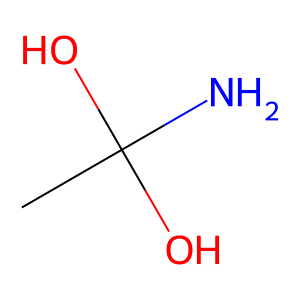


**Molecule 2:** `CC1cIc-cSNN1`  
- **logP:** 0.83  
- **MolWt:** 260.14  
- **TPSA:** 24.06  
- **QED:** 0.383  
- **SA Score:** 6.30  
- **SASA:** 238.38  


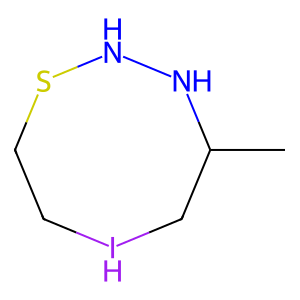


**Molecule 3:** `OCOCN-NCF`  
- **logP:** -1.07  
- **MolWt:** 124.11  
- **TPSA:** 53.52  
- **QED:** 0.189  
- **SA Score:** 4.48  
- **SASA:** 177.12  


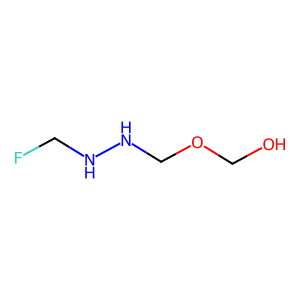


**Molecule 4:** `O1nCsCC1S`  
- **logP:** 0.47  
- **MolWt:** 137.23  
- **TPSA:** 21.26  
- **QED:** 0.474  
- **SA Score:** 5.67  
- **SASA:** 156.25  


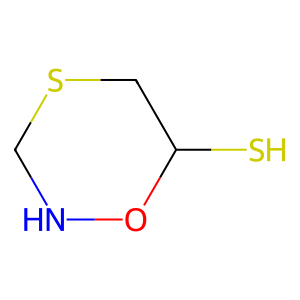


**Molecule 5:** `Cc1NCc-C1`  
- **logP:** 0.76  
- **MolWt:** 85.15  
- **TPSA:** 12.03  
- **QED:** 0.458  
- **SA Score:** 2.95  
- **SASA:** 155.48  


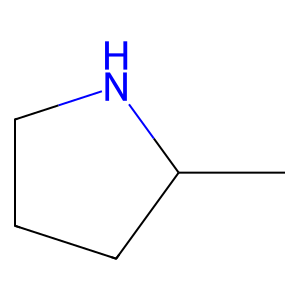


**Molecule 6:** `CCCC1nCNC1`  
- **logP:** 0.31  
- **MolWt:** 114.19  
- **TPSA:** 24.06  
- **QED:** 0.539  
- **SA Score:** 3.69  
- **SASA:** 196.02  


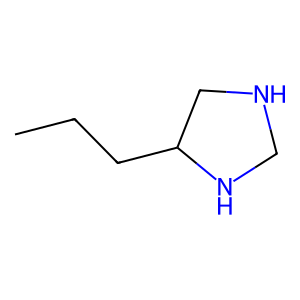


**Molecule 7:** `S=1OCOCcc1`  
- **logP:** 0.33  
- **MolWt:** 118.16  
- **TPSA:** 18.46  
- **QED:** 0.365  
- **SA Score:** 6.27  
- **SASA:** 136.54  


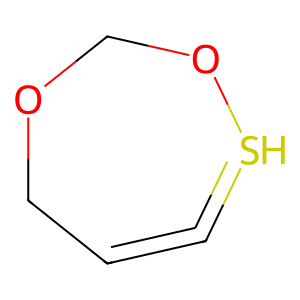


**Molecule 8:** `C=1SIccSc1`  
- **logP:** 3.03  
- **MolWt:** 244.12  
- **TPSA:** 0.00  
- **QED:** 0.601  
- **SA Score:** 6.20  
- **SASA:** 160.85  


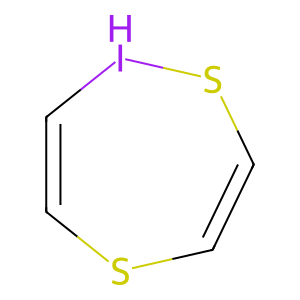

In [186]:
#Implement Lipinski-Rule of Five and show top-k molecules that pass filter along with properties.
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, QED, AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdFreeSASA import CalcSASA, classifyAtoms, SASAOpts
from rdkit.Chem import RDConfig
from IPython.display import display, Markdown

# Load sascorer from RDKit contrib
sascorer_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
if sascorer_path not in sys.path:
    sys.path.append(sascorer_path)

import sascorer

# Show top valid molecules with properties
top_k = 10
subset = valid_smiles[:top_k]

for i, smi in enumerate(subset):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Invalid SMILES: {smi}")
        continue

    # Compute descriptors
    logp    = Crippen.MolLogP(mol)
    molwt   = Descriptors.MolWt(mol)
    qed     = QED.qed(mol)
    sa_score = sascorer.calculateScore(mol)
    tpsa    = rdMolDescriptors.CalcTPSA(mol)

    # Try to compute SASA (requires 3D structure)
    try:
        mol3d = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        radii = classifyAtoms(mol3d, SASAOpts())
        sasa  = CalcSASA(mol3d, radii)
    except Exception as e:
        sasa = None

    # Format values safely
    props = f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** {sasa:.2f}
""" if sasa is not None else f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** N/A
"""

    display(Markdown(props))
    display(Draw.MolToImage(mol, size=(300, 300)))

In [187]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import numpy as np

def plot_smiles_clusters(smiles_list, max_clusters=10):
    # Convert SMILES to Morgan fingerprints
    fps = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            fps.append(fp)
            valid_smiles.append(smi)

    if not fps:
        print("No valid molecules found.")
        return

    # Convert fingerprints to numpy array
    arr = np.array([np.array(list(fp.ToBitString()), dtype=int) for fp in fps])

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate='auto')
    reduced = tsne.fit_transform(arr)

    # Find optimal number of clusters using GMM with BIC
    bic_scores = []
    models = []
    for n in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(reduced)
        bic = gmm.bic(reduced)
        bic_scores.append(bic)
        models.append(gmm)

    # Choose best model
    best_n = np.argmin(bic_scores) + 2  # +2 because range starts at 2
    best_gmm = models[best_n - 2]
    labels = best_gmm.predict(reduced)

    # Plot t-SNE with clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolors='k')
    plt.title(f'GMM Clustering of Molecules (Optimal Clusters: {best_n})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()

    # Optional: return clustering info
    #return {
     #   "reduced_coords": reduced,
      #  "labels": labels,
       # "bic_scores": bic_scores,
       # "optimal_n": best_n,
       # "valid_smiles": valid_smiles
   # }

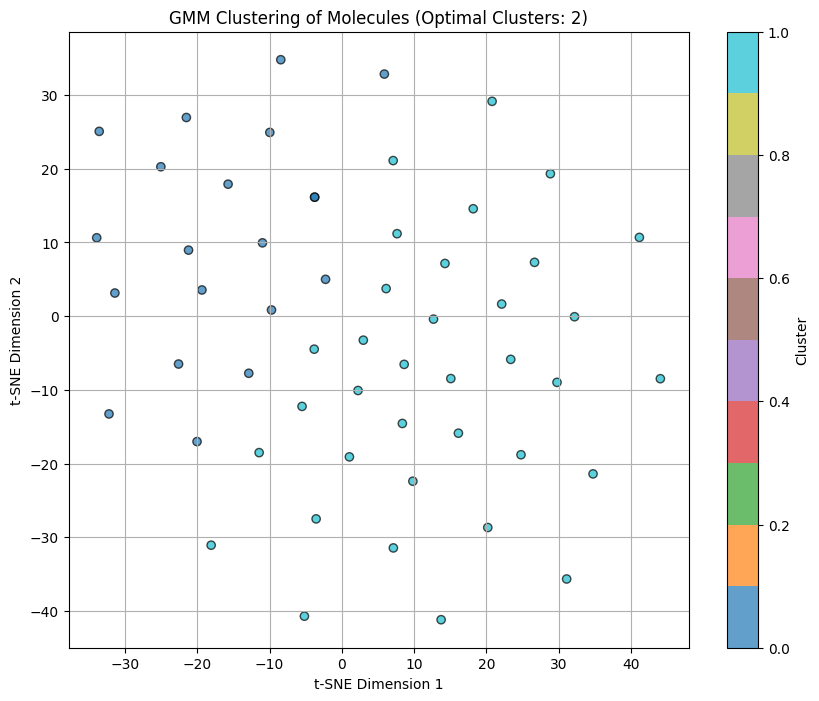

In [182]:
plot_smiles_clusters(valid_smiles, max_clusters=10) #From the plot it seems that molecule has no distinct clusters. Train with more data for better results.